# Final Modeling Work
THe purpose of this notebook is to work on constructing the final models to use in this project presentation, training/validating on 2015-2018 data, and then testing on 2019 data.

## Initial Setup

Importing packages:

In [4]:
import pickle
from sqlalchemy import create_engine
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline, make_pipeline

Importing the regression and classification functions:

In [6]:
from location_regression_functions import *
from pitch_cat_functions import *

Importing the functions from the pipeline script:

In [7]:
from classification_location_combo_2 import *

Pickling in initial data to work with (removed outliers from Pipeline_Part_2.ipynb):

In [8]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [9]:
with open('../Data/removed_outliers_pre_2019.pickle','rb') as read_file:
    pitch_df = pickle.load(read_file)

In [10]:
pitch_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,last_100_ch,last_100_cu,last_100_si,last_100_fc,last_100_kc,last_100_fs,last_100_kn,last_100_ep,last_100_fo,last_100_sc
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0,0,0,0,0,0,0,0,0,0
1,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0,0,0,0,0,0,0,0,0,0
2,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0,0,0,0,0,0,0,0,0,0
3,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0,0,0,0,0,0,0,0,0,0
4,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0,0,0,0,0,0,0,0,0,0


In Feature_Engineering.ipynb, I calculated counts by pitch type for the last 10 pitches the pitcher has thrown.  I'll be bringing that in now to utilize for modeling:

In [11]:
with open('../Data/last_10_data.pickle','rb') as read_file:
    last10_5_df = pickle.load(read_file)

In [12]:
last10_5_df.shape

(3555834, 32)

Merging this onto the other data, on the indices:

In [13]:
last_10_5_only = last10_5_df[['last_10_ff', 'last_10_sl', 'last_10_ft', 'last_10_ch',
       'last_10_cu', 'last_10_si', 'last_10_fc', 'last_10_kc', 'last_10_fs',
       'last_10_kn', 'last_10_ep', 'last_10_fo', 'last_10_sc', 'last_5_ff',
       'last_5_sl', 'last_5_ft', 'last_5_ch', 'last_5_cu', 'last_5_si',
       'last_5_fc', 'last_5_kc', 'last_5_fs', 'last_5_kn', 'last_5_ep',
       'last_5_fo', 'last_5_sc']]

In [14]:
combined_df = pitch_df.merge(last_10_5_only, how='left', left_index=True, right_index=True)

In [15]:
combined_df.isnull().sum().tail(15)

last_10_fo    0
last_10_sc    0
last_5_ff     0
last_5_sl     0
last_5_ft     0
last_5_ch     0
last_5_cu     0
last_5_si     0
last_5_fc     0
last_5_kc     0
last_5_fs     0
last_5_kn     0
last_5_ep     0
last_5_fo     0
last_5_sc     0
dtype: int64

No nulls, so everything merged right.

In [16]:
combined_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate',
       'Cluster', 'last_100_ff', 'last_100_sl', 'last_100_ft', 'last_100_ch',
       'last_100_cu', 'last_100_si', 'last_100_fc', 'last_100_kc',
       'last_100_fs', 'last_100_kn', 'last_100_ep'

For my final modeling, I will work with the top 50 pitchers in the list:

In [19]:
pitcher_list_50 = combined_df.pitcher_full_name.value_counts().head(50).index
pitcher_list_50

Index(['Max Scherzer', 'Justin Verlander', 'Chris Sale', 'Chris Archer',
       'Jose Quintana', 'Jon Lester', 'Corey Kluber', 'Rick Porcello',
       'Gio Gonzalez', 'Julio Teheran', 'Zack Greinke', 'Jake Arrieta',
       'Cole Hamels', 'Jacob deGrom', 'Gerrit Cole', 'Dallas Keuchel',
       'Trevor Bauer', 'Jake Odorizzi', 'Kyle Gibson', 'James Shields',
       'Marco Estrada', 'J.A. Happ', 'Kevin Gausman', 'Tanner Roark',
       'Mike Leake', 'David Price', 'Kyle Hendricks', 'Ian Kennedy',
       'Carlos Martinez', 'Carlos Carrasco', 'Mike Fiers', 'Andrew Cashner',
       'Jeff Samardzija', 'Madison Bumgarner', 'CC Sabathia',
       'Masahiro Tanaka', 'Jason Hammel', 'Robbie Ray', 'Wade Miley',
       'Bartolo Colon', 'Clayton Kershaw', 'Danny Duffy', 'Patrick Corbin',
       'Chase Anderson', 'Johnny Cueto', 'Sonny Gray', 'Francisco Liriano',
       'Jordan Zimmermann', 'Hector Santiago', 'Felix Hernandez'],
      dtype='object')

In [20]:
combined_df.pitcher_full_name.value_counts().head(50).sum()

548765

Pickling out combined_df:

In [138]:
with open('../Data/actual_final_df.pickle', 'wb') as to_write:
    pickle.dump(combined_df, to_write)

So the overall range of pitches is from 8.1k to 13.2k, covering over 750k total pitches.  This seems like a good group to utilize for this project's purposes.

## Baselining the various models on the groups:

### Random Forest Classifier, Linear Regression Locations:

First, I'll utilize Random Forest and Lin. Regression, with the last_10 counts as the metric (i.e. over last 100):

In [19]:
output_df = multiple_pitcher_predictions(pitcher_list_75, combined_df, split_size = 0.2, class_method = 'RandomForest')

Pitch Modeling for Max Scherzer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}
Actual Test Size: 0.2457937776106777
Accuracy: 0.5239005736137667
Precision: (0.4177784186687723,)
Recall: 0.225317620436316
Random Forest Pitch Classification confusion matrix results:
[[1219  123   29    4    8    0]
 [ 377  121    5    1    0    1]
 [ 321   19   18    4    3    0]
 [ 199    6    5    2    1    0]
 [ 112    3    8    0    8    0]
 [  11    5    0    0    0    2]]
Linear Regression:
Val Px R^2: 0.058271587081607845
Val Px MAE: 0.6684472851887782 ft.
Val Pz R^2: 0.1318515808072902
Val Pz MAE: 0.6182048792703414 ft.




Pitch Modeling for Justin Verlander
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5}
Actual Test Size: 0.24915958077911807


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6273809523809524
Precision: (0.28206017802433997,)
Recall: 0.19405056912390006
Random Forest Pitch Classification confusion matrix results:
[[1491   48   26    2    0    0]
 [ 375   69   17    0    0    0]
 [ 324   24   20    1    0    0]
 [ 108    3    0    1    0    0]
 [   8    0    0    0    0    0]
 [   3    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.09194037774141761
Val Px MAE: 0.5985705397669561 ft.
Val Pz R^2: 0.17271211262701314
Val Pz MAE: 0.6464033025162671 ft.




Pitch Modeling for Chris Sale
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FA': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FS': 4}
Actual Test Size: 0.24589511394168573
Accuracy: 0.47673006879805746
Precision: (0.4517541304443103,)
Recall: 0.46212156878345
Random Forest Pitch Classification confusion matrix results:
[[614  83 103  34]
 [265 189  51 179]
 [262  79 130  71]
 [ 13 121  32 245]]
Linear Regression:
Val Px R^2: 0.017437136934990383
Val Px MAE: 0.6716306543995008 ft.
Val Pz R^2: 0.0036664694484707105
Val Pz MAE: 0.6451308352852807 ft.




Pitch Modeling for Chris Archer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.25790754257907544


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5738993710691824
Precision: (0.36109471976747265,)
Recall: 0.30871600228130436
Random Forest Pitch Classification confusion matrix results:
[[813 363  11  10   0]
 [428 624  10  10   0]
 [146  59  14   4   0]
 [  8  22   2   9   0]
 [  6   4   0   1   0]]
Linear Regression:
Val Px R^2: 0.18158363824090917
Val Px MAE: 0.5558438365364791 ft.
Val Pz R^2: 0.09716816825285435
Val Pz MAE: 0.7436292739798052 ft.




Pitch Modeling for Jose Quintana
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'PO': 5, 'FA': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4}
Actual Test Size: 0.24901664145234492
Accuracy: 0.4945321992709599
Precision: (0.36496504741596275,)
Recall: 0.3128624945004933
Random Forest Pitch Classification confusion matrix results:
[[955 123  36   4  33]
 [444 140  46   4  31]
 [126  36  95   1   0]
 [142  34  16   1   3]
 [150  19   0   0  30]]
Linear Regression:
Val Px R^2: -0.02335108583091583
Val Px MAE: 0.6492433800053866 ft.
Val Pz R^2: 0.013905710706296759
Val Pz MAE: 0.6978465837907428 ft.




Pitch Modeling for Jon Lester
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4}
Actual Test Size: 0.24186093247588425
Accuracy: 0.4781886165351059
Precision: (0.37744694459889094,)
Recall: 0.24663884231177194
Random Forest Pitch Classification confusion matrix results:
[[993 103  16  14   6]
 [433 123  15   4   2]
 [241  45  17   1   3]
 [192  26   1  13   1]
 [118  30   4   1   5]]
Linear Regression:
Val Px R^2: 0.0811382155514414
Val Px MAE: 0.6994442824459574 ft.
Val Pz R^2: 0.19503650343975132
Val Pz MAE: 0.5665669935805631 ft.




Pitch Modeling for Corey Kluber
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5}
Actual Test Size: 0.24817813765182187
Accuracy: 0.3743882544861338
Precision: (0.364864130077826,)
Recall: 0.3048741112709002
Random Forest Pitch Classification confusion matrix results:
[[450 126  55  85  77   1]
 [179 186  27  50  67   3]
 [180  78  57  54  22   2]
 [145  27  34  98   0   1]
 [122  60   6   0 121   2]
 [ 63  21   4  18  25   6]]
Linear Regression:
Val Px R^2: 0.10747377827531301
Val Px MAE: 0.6476149447969682 ft.
Val Pz R^2: 0.03909021558598247
Val Pz MAE: 0.6761248944887494 ft.




Pitch Modeling for Rick Porcello
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'EP': 5, 'PO': 6, 'SI': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CU': 3, 'CH': 4, 'SI': 5}
Actual Test Size: 0.24761324395693682
Accuracy: 0.4360131255127153
Precision: (0.374805563370941,)
Recall: 0.3381836728668678
Random Forest Pitch Classification confusion matrix results:
[[570 160  52  23  18]
 [195 339  53  25  24]
 [149 100  87   9  15]
 [166 101  35  27  14]
 [ 94  93  30  19  40]]
Linear Regression:
Val Px R^2: 0.023188447948950697
Val Px MAE: 0.6169396658134098 ft.
Val Pz R^2: 0.0666785343931201
Val Pz MAE: 0.7065649953733851 ft.




Pitch Modeling for Gio Gonzalez
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3, 'UN': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3}
Actual Test Size: 0.24457917994039666
Accuracy: 0.40756302521008403
Precision: (0.38203740203760783,)
Recall: 0.36252394824516887
Random Forest Pitch Classification confusion matrix results:
[[515 124  87  52]
 [262 292  50  57]
 [257 100  84  41]
 [208 124  48  79]]
Linear Regression:
Val Px R^2: 0.05593897390667091
Val Px MAE: 0.6582435169876769 ft.
Val Pz R^2: 0.19593168913113335
Val Pz MAE: 0.6554106328524162 ft.




Pitch Modeling for Julio Teheran
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.24285564744059457
Accuracy: 0.44310344827586207
Precision: (0.3533527411089012,)
Recall: 0.27099104200889496
Random Forest Pitch Classification confusion matrix results:
[[804 107  63   5  10]
 [381  90  48   3   2]
 [234  40 118   9   5]
 [151  13  28   9   4]
 [148  21  14   6   7]]
Linear Regression:
Val Px R^2: 0.13837823962827978
Val Px MAE: 0.6600640788844006 ft.
Val Pz R^2: 0.09583781060543284
Val Pz MAE: 0.6325740048644292 ft.




Pitch Modeling for Zack Greinke
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'EP': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4}
Actual Test Size: 0.25753541378208544
Accuracy: 0.44168734491315137
Precision: (0.36736762325681616,)
Recall: 0.2905980347374205
Random Forest Pitch Classification confusion matrix results:
[[761 126  91  12   7]
 [270 181  19   2   9]
 [303  36 106   9  11]
 [193  24  25   8   1]
 [150  41  17   4  12]]
Linear Regression:
Val Px R^2: 0.13892329621814226
Val Px MAE: 0.6422287684106918 ft.
Val Pz R^2: 0.08538297381057103
Val Pz MAE: 0.6466332726991059 ft.




Pitch Modeling for Jake Arrieta
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'CU': 2, 'FF': 3, 'CH': 4}
Actual Test Size: 0.2452431289640592
Accuracy: 0.5172413793103449
Precision: (0.3998142533343686,)
Recall: 0.2878265443166491
Random Forest Pitch Classification confusion matrix results:
[[993 101  16  31   2]
 [329 120  21  23   0]
 [200  55  16  13   0]
 [153  34   9  70   0]
 [108  18   2   5   1]]
Linear Regression:
Val Px R^2: 0.08326291084032578
Val Px MAE: 0.6388077432310122 ft.
Val Pz R^2: 0.03717117226315325
Val Pz MAE: 0.6847540387173181 ft.




Pitch Modeling for Cole Hamels
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}
Actual Test Size: 0.25623995715050885
Accuracy: 0.36789297658862874
Precision: (0.27158728965603524,)
Recall: 0.26318373875844925
Random Forest Pitch Classification confusion matrix results:
[[453 101 103  31  24   1]
 [165 188  79  25  24   1]
 [167  80 165  50  17   1]
 [169  67  88  48  10   2]
 [137  59  58  26  26   0]
 [  9   3   5   9   1   0]]
Linear Regression:
Val Px R^2: -0.008985365168926007
Val Px MAE: 0.7041241806746348 ft.
Val Pz R^2: 0.07325888323529262
Val Pz MAE: 0.6634209760557677 ft.




Pitch Modeling for Jacob deGrom
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.25792397342337436
Accuracy: 0.4379222972972973
Precision: (0.37165586105320014,)
Recall: 0.26183462485738207
Random Forest Pitch Classification confusion matrix results:
[[869  72  40  14   8]
 [365  67  35  11   2]
 [257  27  73   6   3]
 [230  23  17  20   2]
 [165  20  28   6   8]]
Linear Regression:
Val Px R^2: 0.14088400345596974
Val Px MAE: 0.600102313387698 ft.
Val Pz R^2: 0.14969521618343862
Val Pz MAE: 0.6501946960305347 ft.




Pitch Modeling for Gerrit Cole
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6}
Actual Test Size: 0.251761899598829


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5107665805340224
Precision: (0.277583469892477,)
Recall: 0.1953201141300675
Random Forest Pitch Classification confusion matrix results:
[[1092   44   16   27    6    7    0]
 [ 389   40    6   16    0    5    0]
 [ 238   12    8   13    0    3    0]
 [  93    7    1   37    0    0    0]
 [ 105    7    1    8    1    1    0]
 [ 122    5    2    0    1    8    0]
 [   1    0    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.04540204370216849
Val Px MAE: 0.6368287889793511 ft.
Val Pz R^2: 0.029437621388939683
Val Pz MAE: 0.6850540605751333 ft.




Pitch Modeling for Dallas Keuchel
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'CH': 3, 'FF': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FF': 4}
Actual Test Size: 0.2510112605225757
Accuracy: 0.5060975609756098
Precision: (0.4013105621994277,)
Recall: 0.2766256141017386
Random Forest Pitch Classification confusion matrix results:
[[1000   72   23   16   12]
 [ 330   93   15    9    5]
 [ 194   29   26   12    8]
 [ 169   20   12   22    4]
 [ 174   16    7    7   21]]
Linear Regression:
Val Px R^2: 0.020927237240974672
Val Px MAE: 0.6938329421859841 ft.
Val Pz R^2: 0.06001118691303897
Val Pz MAE: 0.6473476925520036 ft.




Pitch Modeling for Trevor Bauer
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'CU': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'KC': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'SL': 6}
Actual Test Size: 0.25561674008810575
Accuracy: 0.45196036191296857
Precision: (0.4150757254495176,)
Recall: 0.3714118804477103
Random Forest Pitch Classification confusion matrix results:
[[581  65  91  28  20  19   6]
 [116 118  29  23   6  26   7]
 [111  16 172   5   2   0  16]
 [147  43  42  36   9  21   3]
 [131  32  32  16  17  19   1]
 [ 63  40   0  16   9  83   0]
 [ 33   7  16   3   2   1  42]]
Linear Regression:
Val Px R^2: 0.07669610483228473
Val Px MAE: 0.5787945747726557 ft.
Val Pz R^2: 0.12199086378575574
Val Pz MAE: 0.750907220041188 ft.




Pitch Modeling for Jake Odorizzi
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'FC': 4, 'CU': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'FT': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.2508779631255487
Accuracy: 0.47506561679790027
Precision: (0.42811882461631323,)
Recall: 0.32194264728639205
Random Forest Pitch Classification confusion matrix results:
[[740 110  68  27  28   3]
 [293  91  80   8   6   0]
 [ 79  39 166   3   4   0]
 [154   5  27  39   6   1]
 [133   8  21   5  48   0]
 [ 59  12  10   7   4   2]]
Linear Regression:
Val Px R^2: 0.17628005565436022
Val Px MAE: 0.5866843950612551 ft.
Val Pz R^2: 0.0724131000997239
Val Pz MAE: 0.7348502150082189 ft.




Pitch Modeling for Kyle Gibson
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2442907334211682
Accuracy: 0.40898876404494383
Precision: (0.35055317312355894,)
Recall: 0.29332548627695315
Random Forest Pitch Classification confusion matrix results:
[[600 116  44  31   5]
 [256 172  56  28   3]
 [230  50 104  12   6]
 [185  69  25  28   2]
 [ 99  73  16   9   6]]
Linear Regression:
Val Px R^2: 0.05948275866103048
Val Px MAE: 0.6956944037992874 ft.
Val Pz R^2: 0.16489555550920032
Val Pz MAE: 0.6371229371186713 ft.




Pitch Modeling for James Shields
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'KC': 2, 'FT': 3, 'CH': 4, 'EP': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'KC': 3, 'FT': 4}
Actual Test Size: 0.24977954144620812
Accuracy: 0.40158870255957635
Precision: (0.3871478905292555,)
Recall: 0.3787825337596813
Random Forest Pitch Classification confusion matrix results:
[[359 116  65  64  39]
 [136 151  80  78  17]
 [ 53  74 172  68  39]
 [ 76  83  94 154  30]
 [ 92  50  56  46  74]]
Linear Regression:
Val Px R^2: 0.11393245663131046
Val Px MAE: 0.6950398021605314 ft.
Val Pz R^2: 0.09116632930992496
Val Pz MAE: 0.6186101768524582 ft.




Pitch Modeling for Marco Estrada
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3}
Actual Test Size: 0.23696682464454977
Accuracy: 0.4823255813953488
Precision: (0.3346964960015349,)
Recall: 0.29675484890937054
Random Forest Pitch Classification confusion matrix results:
[[839 160  14   3]
 [536 173  13   1]
 [139  40  25   1]
 [160  38   8   0]]
Linear Regression:
Val Px R^2: 0.16857341495735867
Val Px MAE: 0.5345630529939726 ft.
Val Pz R^2: 0.0398658867961349
Val Pz MAE: 0.7537642089571711 ft.




Pitch Modeling for J.A. Happ
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.25151108126259236
Accuracy: 0.5549621717846017
Precision: (0.39411729420450353,)
Recall: 0.24173321876274087
Random Forest Pitch Classification confusion matrix results:
[[1157   48   12    8    2]
 [ 310   67    2    3    1]
 [ 244   25   16    3    0]
 [ 182   26    3    6    0]
 [ 123    6    2    0    1]]
Linear Regression:
Val Px R^2: 0.07243415190887992
Val Px MAE: 0.6270270405165523 ft.
Val Pz R^2: 0.19794884842980065
Val Pz MAE: 0.6245263354379944 ft.




Pitch Modeling for Kevin Gausman
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3}
Actual Test Size: 0.2519075403949731
Accuracy: 0.6227171492204899
Precision: (0.3263188201960904,)
Recall: 0.2622911391011737
Random Forest Pitch Classification confusion matrix results:
[[1357   43   11    0]
 [ 478   36    1    1]
 [ 266   11    5    1]
 [  32    2    1    0]]
Linear Regression:
Val Px R^2: 0.08464000998823418
Val Px MAE: 0.6236545929792447 ft.
Val Pz R^2: 0.1560385770566869
Val Pz MAE: 0.6270550902892972 ft.




Pitch Modeling for Tanner Roark
Here is the coding for last pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6}
Actual Test Size: 0.24703758040853177
Accuracy: 0.4550022841480128
Precision: (0.2996099426695341,)
Recall: 0.3055564125241899
Random Forest Pitch Classification confusion matrix results:
[[517   0   4   8   0   1   0]
 [  4 337  47  22  64   8   1]
 [137 101  43   5  24   7   0]
 [107 120  10  23  25   5   0]
 [ 36 153  30  13  67  13   0]
 [ 77 109   8  10  37   9   0]
 [  0   5   0   1   1   0   0]]
Linear Regression:
Val Px R^2: 0.09563435069857684
Val Px MAE: 0.6510602514548838 ft.
Val Pz R^2: 0.044110662164695835
Val Pz MAE: 0.6724858727478198 ft.




Pitch Modeling for Mike Leake
Here is the coding for last pitch type:
{'SI': 0, 'FC': 1, 'KC': 2, 'CH': 3, 'SL': 4, 'FF': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FC': 1, 'CH': 2, 'SL': 3, 'KC': 4, 'FF': 5}
Actual Test Size: 0.25230520977408943
Accuracy: 0.46916400182731843
Precision: (0.34493374301191054,)
Recall: 0.22291408470408233
Random Forest Pitch Classification confusion matrix results:
[[901  48  21  18   6   1]
 [305  64  27  15   5   0]
 [183  36  25   8   1   1]
 [152  23   5  30   2   0]
 [168  19  18   6   6   0]
 [ 78   3   5   8   0   1]]
Linear Regression:
Val Px R^2: 0.07789788569677192
Val Px MAE: 0.6738113740955802 ft.
Val Pz R^2: 0.026300668644102854
Val Pz MAE: 0.5624580307569726 ft.




Pitch Modeling for David Price
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'FC': 3, 'KC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CH': 1, 'FC': 2, 'FF': 3, 'KC': 4}
Actual Test Size: 0.23567678612188997
Accuracy: 0.3922518159806295
Precision: (0.33921773176959835,)
Recall: 0.3157893357252407
Random Forest Pitch Classification confusion matrix results:
[[444  81  58  86   5]
 [208 107  59  74   6]
 [203  62  91  51   5]
 [115  67  33 162   8]
 [ 65  15  26  28   6]]
Linear Regression:
Val Px R^2: 0.021347430312655402
Val Px MAE: 0.6602391154180777 ft.
Val Pz R^2: 0.021707639606602602
Val Pz MAE: 0.6267608477473275 ft.




Pitch Modeling for Kyle Hendricks
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4}
Actual Test Size: 0.25280963967095355
Accuracy: 0.5604949587534372
Precision: (0.44132370088222495,)
Recall: 0.3472604888235311
Random Forest Pitch Classification confusion matrix results:
[[885 120  30   9  11]
 [293 219  36   4  12]
 [101  73  95   8   1]
 [ 74  18  19  10   5]
 [110  27   3   5  14]]
Linear Regression:
Val Px R^2: 0.16037392835993225
Val Px MAE: 0.6326638636233454 ft.
Val Pz R^2: 0.024880930552421243
Val Pz MAE: 0.646682549578579 ft.




Pitch Modeling for Ian Kennedy
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'SL': 2, 'CH': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Actual Test Size: 0.24054271587903875
Accuracy: 0.5430210325047801
Precision: (0.3724771743605027,)
Recall: 0.305821189726958
Random Forest Pitch Classification confusion matrix results:
[[986  20   4  44   7]
 [248  14   2  38   1]
 [202  11   5  35   9]
 [103   8   2 123  11]
 [181   4   1  25   8]]
Linear Regression:
Val Px R^2: 0.11321039664138666
Val Px MAE: 0.6150375355610843 ft.
Val Pz R^2: 0.0885822615848878
Val Pz MAE: 0.6642113344370831 ft.




Pitch Modeling for Carlos Martinez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.25189063408958695
Accuracy: 0.43048498845265587
Precision: (0.3902163833572565,)
Recall: 0.38852729535735037
Random Forest Pitch Classification confusion matrix results:
[[390 117  47  49  38  10]
 [142 245  50  52  79   8]
 [101 108  53  39  33  11]
 [ 81  54  27 119   0   2]
 [ 77  47  14   0 108   9]
 [ 15  12   6   1   4  17]]
Linear Regression:
Val Px R^2: 0.017833328381430258
Val Px MAE: 0.6825228633890702 ft.
Val Pz R^2: -0.0026098510738310488
Val Pz MAE: 0.6556656112490571 ft.




Pitch Modeling for Carlos Carrasco
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5, 'AB': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.24554088487375492
Accuracy: 0.41415094339622643
Precision: (0.359697285787137,)
Recall: 0.31478881327486125
Random Forest Pitch Classification confusion matrix results:
[[589  89  74  34  20]
 [179 108  30  28  11]
 [177  53 100  30  13]
 [152  36  53  57  10]
 [160  48  33  12  24]]
Linear Regression:
Val Px R^2: 0.07442085628713235
Val Px MAE: 0.6864061872885712 ft.
Val Pz R^2: 0.06784506596690099
Val Pz MAE: 0.607886505444054 ft.




Pitch Modeling for Mike Fiers
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'SL': 3, 'FT': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'FC': 5}
Actual Test Size: 0.2488328664799253
Accuracy: 0.4709193245778612
Precision: (0.3563828732336541,)
Recall: 0.2716606239952892
Random Forest Pitch Classification confusion matrix results:
[[828  37  33  16  23  12]
 [295  47  15   7  26   2]
 [243  25  46   7  16   1]
 [ 96   9   5  21   6   0]
 [ 64  28  17  13  59   0]
 [119   9   3   0   1   3]]
Linear Regression:
Val Px R^2: 0.03857746279345964
Val Px MAE: 0.6109639538861497 ft.
Val Pz R^2: 0.026899570020256003
Val Pz MAE: 0.7453368713878211 ft.




Pitch Modeling for Andrew Cashner
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2474616292798111
Accuracy: 0.48377862595419846
Precision: (0.4043512082463524,)
Recall: 0.32272710568503044
Random Forest Pitch Classification confusion matrix results:
[[487 202  27   9   3]
 [155 452  37   7   8]
 [123 190  55   4   2]
 [ 83 105  13  15   5]
 [ 84  21   2   2   5]]
Linear Regression:
Val Px R^2: 0.057709262850153764
Val Px MAE: 0.6558226918955343 ft.
Val Pz R^2: 0.08272332201565924
Val Pz MAE: 0.6713871442700761 ft.




Pitch Modeling for Jeff Samardzija
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7, 'PO': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7}
Actual Test Size: 0.24790218173099976


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.36895551257253384
Precision: (0.2797027809552183,)
Recall: 0.21016885992629805
Random Forest Pitch Classification confusion matrix results:
[[412  89  83  31   6   5   5   0]
 [161 190  56  19   7   9   4   0]
 [182 106  92  15   2   4   2   0]
 [102  58  21  51   0   1   0   0]
 [ 91  44  19   2   8   2   2   0]
 [ 19  63  12   0   0   6   0   0]
 [ 68   4   1   3   4   0   4   0]
 [  1   0   2   0   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.053228049118808074
Val Px MAE: 0.6784992916726595 ft.
Val Pz R^2: 0.07217284152969294
Val Pz MAE: 0.6254703456607423 ft.




Pitch Modeling for Madison Bumgarner
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}
Actual Test Size: 0.25685846079145425
Accuracy: 0.4116257088846881
Precision: (0.32998122697774895,)
Recall: 0.33448858631735806
Random Forest Pitch Classification confusion matrix results:
[[426 139   5  18  27   1]
 [235 149   9  10   0   0]
 [ 83  48 130  20  96   2]
 [177  45  46  41  60   2]
 [ 12   0  96  21 125   0]
 [ 30  16  33   3  11   0]]
Linear Regression:
Val Px R^2: 0.03552881349771286
Val Px MAE: 0.659873487281801 ft.
Val Pz R^2: 0.15392822323772437
Val Pz MAE: 0.673860573711784 ft.




Pitch Modeling for CC Sabathia
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}
Actual Test Size: 0.25182215743440234
Accuracy: 0.432223830197781
Precision: (0.4195111399430774,)
Recall: 0.40541792498074597
Random Forest Pitch Classification confusion matrix results:
[[321  97  69  91   9]
 [185 192 124  56  14]
 [ 32  76 223   0   8]
 [159  40   5 142   3]
 [ 72  42  66  29  18]]
Linear Regression:
Val Px R^2: -0.004649309630874399
Val Px MAE: 0.6898308363002134 ft.
Val Pz R^2: 0.04723438495111776
Val Pz MAE: 0.6784447388439785 ft.




Pitch Modeling for Masahiro Tanaka
Here is the coding for last pitch type:
{'SL': 0, 'FS': 1, 'FF': 2, 'SI': 3, 'CU': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FS': 1, 'SI': 2, 'FF': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.24416495344056113
Accuracy: 0.3818722139673105
Precision: (0.32399853199053896,)
Recall: 0.2743000853566178
Random Forest Pitch Classification confusion matrix results:
[[289 189  30  48   9  10]
 [164 326  38  29   9   1]
 [ 94 120  77  17   2   5]
 [ 90 103  15  66   4   4]
 [ 61  49  14  23   9   2]
 [ 41  42  14  21   0   4]]
Linear Regression:
Val Px R^2: 0.1578837631773784
Val Px MAE: 0.578077175633778 ft.
Val Pz R^2: 0.07766249871032171
Val Pz MAE: 0.6604225930589388 ft.




Pitch Modeling for Jason Hammel
Here is the coding for last pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24849600982197667
Accuracy: 0.4214426877470356
Precision: (0.27104864984261967,)
Recall: 0.2813029914965639
Random Forest Pitch Classification confusion matrix results:
[[435 174  96   5   2]
 [245 238  64   3   1]
 [212 105 179   4   0]
 [ 80  59  38   1   0]
 [ 43  19  21   0   0]]
Linear Regression:
Val Px R^2: 0.08848886433592085
Val Px MAE: 0.6118128787426846 ft.
Val Pz R^2: 0.030571748944813737
Val Pz MAE: 0.7311863414204666 ft.




Pitch Modeling for Robbie Ray
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.25488257107540174
Accuracy: 0.5290979631425801
Precision: (0.4033918592254233,)
Recall: 0.29478822601025995
Random Forest Pitch Classification confusion matrix results:
[[907  74  53  26   1]
 [336  53  55   8   0]
 [144  19 114   2   1]
 [176   6   1  16   0]
 [ 47   5  17   0   1]]
Linear Regression:
Val Px R^2: 0.04557524889393716
Val Px MAE: 0.6718301237620781 ft.
Val Pz R^2: 0.08448392895991941
Val Pz MAE: 0.7086758672453567 ft.




Pitch Modeling for Wade Miley
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'CU': 4, 'FC': 5}
Actual Test Size: 0.24762140121092302
Accuracy: 0.37475049900199603
Precision: (0.3525038692067078,)
Recall: 0.3450464446458779
Random Forest Pitch Classification confusion matrix results:
[[377  93  44  57  15  34]
 [142 134  24  32   8  28]
 [187  58  45  16   5  36]
 [144  54  11  73   5   4]
 [ 95  40   8  14  16  40]
 [ 20  20   4   0  15 106]]
Linear Regression:
Val Px R^2: 0.019875314104661812
Val Px MAE: 0.6709090275725247 ft.
Val Pz R^2: 0.06276467547531905
Val Pz MAE: 0.6529197359694393 ft.




Pitch Modeling for Bartolo Colon
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}
Actual Test Size: 0.249342846413819


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5953815261044176
Precision: (0.22762604807154835,)
Recall: 0.2310321950234549
Random Forest Pitch Classification confusion matrix results:
[[1079   77    2    0    0]
 [ 371  107    1    0    0]
 [ 155    6    0    0    0]
 [ 169    6    0    0    0]
 [  15    4    0    0    0]]
Linear Regression:
Val Px R^2: 0.1795237978834211
Val Px MAE: 0.6347951219740997 ft.
Val Pz R^2: 0.06813818677126837
Val Pz MAE: 0.5591892836002266 ft.




Pitch Modeling for Clayton Kershaw
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}
Actual Test Size: 0.23694978301301922


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5342752485609629
Precision: (0.4503786947474956,)
Recall: 0.3023363424333066
Random Forest Pitch Classification confusion matrix results:
[[722 172  44   1   0]
 [344 236  52   0   0]
 [164  82  58   0   0]
 [ 16   5   2   5   0]
 [  2   4   2   0   0]]
Linear Regression:
Val Px R^2: 0.05220196589050874
Val Px MAE: 0.5318695183116975 ft.
Val Pz R^2: 0.08982676651249355
Val Pz MAE: 0.7104393606243931 ft.




Pitch Modeling for Danny Duffy
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'EP': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.25015816778438565


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4157814871016692
Precision: (0.31927927707394155,)
Recall: 0.2784001124257749
Random Forest Pitch Classification confusion matrix results:
[[530  64  46  39  48   0]
 [196 122  26  21  39   0]
 [182  60  49  25  31   0]
 [178  33  14  62   2   0]
 [106  28  13   2  59   0]
 [  1   0   0   1   0   0]]
Linear Regression:
Val Px R^2: 0.042470691188507104
Val Px MAE: 0.6162273026316288 ft.
Val Pz R^2: 0.08953549004074779
Val Pz MAE: 0.6725169582134807 ft.




Pitch Modeling for Patrick Corbin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FT': 1, 'FF': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2522695307505434
Accuracy: 0.4647744551444501
Precision: (0.3964006159064668,)
Recall: 0.319242770452223
Random Forest Pitch Classification confusion matrix results:
[[425 117 118   3   2]
 [188 324  77   2   8]
 [210 151 159   4   2]
 [ 31  73  21   5   0]
 [  6  41   2   0   4]]
Linear Regression:
Val Px R^2: 0.0705842413141824
Val Px MAE: 0.6417227012262514 ft.
Val Pz R^2: 0.11171515982957536
Val Pz MAE: 0.6516647962352331 ft.




Pitch Modeling for Chase Anderson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4}
Actual Test Size: 0.25365290951038194
Accuracy: 0.43961596766043454
Precision: (0.32706311248869935,)
Recall: 0.2561427983057217
Random Forest Pitch Classification confusion matrix results:
[[728  69  32  26   5]
 [307  73   8  16   3]
 [240  23  22  25   4]
 [176  40  12  44   2]
 [ 98  11   8   4   3]]
Linear Regression:
Val Px R^2: 0.0823614045156581
Val Px MAE: 0.6688399611945646 ft.
Val Pz R^2: 0.04052608341816044
Val Pz MAE: 0.6474494372923439 ft.




Pitch Modeling for Johnny Cueto
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'FA': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.24676986056031724


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.33851736651114567
Precision: (0.2721481049803256,)
Recall: 0.26152464753053845
Random Forest Pitch Classification confusion matrix results:
[[281  67  57  47  51   0]
 [146 153  49  47  27   0]
 [130  55 104  47  21   0]
 [142  69  42  70  20   0]
 [118  61  50  21  45   0]
 [  1   3   2   3   0   0]]
Linear Regression:
Val Px R^2: 0.010080491132470004
Val Px MAE: 0.7203600082697215 ft.
Val Pz R^2: 0.11703272958905653
Val Pz MAE: 0.6506756170017062 ft.




Pitch Modeling for Sonny Gray
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.24948559670781892


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.43402061855670104
Precision: (0.32090126287434345,)
Recall: 0.2918364923196046
Random Forest Pitch Classification confusion matrix results:
[[380 144  46  77  10   0]
 [170 278  23  33   6   0]
 [124  86  65  20   4   0]
 [ 95  87   9 114   1   0]
 [ 78  38  10   2   5   0]
 [ 15   2   2  16   0   0]]
Linear Regression:
Val Px R^2: 0.12117183526738096
Val Px MAE: 0.5615326613646465 ft.
Val Pz R^2: 0.06967478581333175
Val Pz MAE: 0.7151724157572146 ft.




Pitch Modeling for Francisco Liriano
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}
Actual Test Size: 0.2455455846013786


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4968220338983051
Precision: (0.36859804077530545,)
Recall: 0.2793149094108195
Random Forest Pitch Classification confusion matrix results:
[[596 169  54   4   0]
 [306 283  32   1   0]
 [210  73  53   2   0]
 [ 57  31   5   6   0]
 [  0   6   0   0   0]]
Linear Regression:
Val Px R^2: 0.055662016005985526
Val Px MAE: 0.6943155365047876 ft.
Val Pz R^2: 0.01462096809495006
Val Pz MAE: 0.7057846741241073 ft.




Pitch Modeling for Jordan Zimmermann
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FT': 4}
Actual Test Size: 0.252071638599305
Accuracy: 0.5137857900318133
Precision: (0.31311915468784596,)
Recall: 0.24698153080341684
Random Forest Pitch Classification confusion matrix results:
[[797 132  14   1   3]
 [350 160   7   0   2]
 [246  30   8   1   2]
 [ 53   5   4   0   1]
 [ 45  19   1   1   4]]
Linear Regression:
Val Px R^2: 0.08281882388783901
Val Px MAE: 0.6295073753047122 ft.
Val Pz R^2: 0.12315813748298288
Val Pz MAE: 0.6124422744709299 ft.




Pitch Modeling for Hector Santiago
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6}
Actual Test Size: 0.2514377424100575


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6101063829787234
Precision: (0.21634956065759633,)
Recall: 0.15095441801374412
Random Forest Pitch Classification confusion matrix results:
[[1121   29    2    6    1    0    0]
 [ 345   23    0    1    1    0    2]
 [ 109    4    1    0    0    0    0]
 [  99    5    0    2    0    0    0]
 [  82    4    0    0    0    0    2]
 [  20    3    0    0    0    0    1]
 [  16    1    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.06889265611463502
Val Px MAE: 0.6948895656954716 ft.
Val Pz R^2: 0.03771482996257303
Val Pz MAE: 0.6323781352255343 ft.




Pitch Modeling for Felix Hernandez
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'CH': 2, 'FF': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'CU': 2, 'FF': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.23355131456025624


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3977142857142857
Precision: (0.28941159898113183,)
Recall: 0.2539616092054599
Random Forest Pitch Classification confusion matrix results:
[[372  88  83  18   4   0]
 [170 153  69  17   4   0]
 [153 101 128  21   4   0]
 [ 93  77  59  40   1   0]
 [ 49  22  14   5   3   0]
 [  2   0   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.03748921696100316
Val Px MAE: 0.6442627625344469 ft.
Val Pz R^2: 0.0142390963938821
Val Pz MAE: 0.67465872734684 ft.




Pitch Modeling for Jeremy Hellickson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'CU': 3, 'KC': 4, 'FC': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'CU': 3, 'KC': 4, 'FC': 5, 'SL': 6}
Actual Test Size: 0.252508814754543
Accuracy: 0.38990332975295383
Precision: (0.32196506378728895,)
Recall: 0.22474979017024152
Random Forest Pitch Classification confusion matrix results:
[[462 145  26  10  19  13   2]
 [256 173  22  17  13   7   4]
 [132  58  43   9   1   0   0]
 [ 94  33  14  26   0   0   1]
 [ 72  30   0   0  15   4   0]
 [ 54  26   0   0   6   5   0]
 [ 41  22   5   0   0   0   2]]
Linear Regression:
Val Px R^2: 0.023425763109197195
Val Px MAE: 0.6745401216393387 ft.
Val Pz R^2: 0.01595349424049497
Val Pz MAE: 0.6388209423738929 ft.




Pitch Modeling for Mike Foltynewicz
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24962772438066874
Accuracy: 0.4598698481561822
Precision: (0.3833469664996632,)
Recall: 0.2727697192020915
Random Forest Pitch Classification confusion matrix results:
[[646 108  32   4   1]
 [241 157  23   2   2]
 [225  65  37   3   0]
 [153  17  14   2   3]
 [ 88   8   6   1   6]]
Linear Regression:
Val Px R^2: 0.10205593548931846
Val Px MAE: 0.6402852800449718 ft.
Val Pz R^2: 0.045607146070225424
Val Pz MAE: 0.6681383751388466 ft.




Pitch Modeling for Michael Wacha
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'FT': 4}
Actual Test Size: 0.24552289815447711


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5400890868596881
Precision: (0.32954287983078123,)
Recall: 0.23375842457053175
Random Forest Pitch Classification confusion matrix results:
[[894  52  13   6   0]
 [268  57  11   1   0]
 [261  15  15   1   0]
 [160  16   3   4   0]
 [ 18   0   1   0   0]]
Linear Regression:
Val Px R^2: 0.05490439680620218
Val Px MAE: 0.5906359794017212 ft.
Val Pz R^2: 0.03435035188374702
Val Pz MAE: 0.722024665769775 ft.




Pitch Modeling for Yovani Gallardo
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.25106793440815767
Accuracy: 0.33150384193194293
Precision: (0.3056070956962298,)
Recall: 0.2605198789014296
Random Forest Pitch Classification confusion matrix results:
[[255 171  80  16   4]
 [173 224  75  10   1]
 [154 123 110   6   3]
 [111  79  50   7   5]
 [ 67  54  27   9   8]]
Linear Regression:
Val Px R^2: 0.09762250694230157
Val Px MAE: 0.6458207608898412 ft.
Val Pz R^2: 0.13622105025065256
Val Pz MAE: 0.6947918366049395 ft.




Pitch Modeling for Stephen Strasburg
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'FT': 3, 'SL': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Actual Test Size: 0.2553603541292018
Accuracy: 0.4978331527627302
Precision: (0.3817931869347551,)
Recall: 0.2581988964084462
Random Forest Pitch Classification confusion matrix results:
[[830  38  21  10   4]
 [284  37  11  14   1]
 [232  12  22  10   0]
 [117  12   4  28   1]
 [144   5   5   2   2]]
Linear Regression:
Val Px R^2: 0.02546265158160743
Val Px MAE: 0.6413205541879494 ft.
Val Pz R^2: 0.0800518016615217
Val Pz MAE: 0.6823205833519727 ft.




Pitch Modeling for Lance Lynn
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'SL': 5, 'PO': 6, 'FA': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'SL': 5}
Actual Test Size: 0.247032537355118
Accuracy: 0.5025438100621821
Precision: (0.3828497692876585,)
Recall: 0.21108905984227652
Random Forest Pitch Classification confusion matrix results:
[[589 179   2   6   1   0]
 [334 296   5   3   0   0]
 [ 70  61   2   1   0   0]
 [ 79  24   0   1   0   0]
 [ 26  39   1   0   0   0]
 [ 45   4   0   0   0   1]]
Linear Regression:
Val Px R^2: 0.12866639828733228
Val Px MAE: 0.7203732101247818 ft.
Val Pz R^2: 0.13811594420326245
Val Pz MAE: 0.5932243647331963 ft.




Pitch Modeling for Anibal Sanchez
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'CU': 3, 'SI': 4, 'FC': 5, 'CH': 6, 'PO': 7, 'FA': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SI': 2, 'SL': 3, 'FC': 4, 'CU': 5, 'CH': 6}
Actual Test Size: 0.24793619700573669
Accuracy: 0.34198645598194133
Precision: (0.25177953648654866,)
Recall: 0.21334020648638455
Random Forest Pitch Classification confusion matrix results:
[[414  53  40  42  27   9   0]
 [177  70  27   9  21   6   2]
 [132  38  55  22  14   3   1]
 [109  22  22  31   6   3   0]
 [101  32  11   9  25   4   2]
 [122  15  26  10   7  11   1]
 [ 20   7   3   3   8   0   0]]
Linear Regression:
Val Px R^2: 0.05262076928068704
Val Px MAE: 0.6368942449704488 ft.
Val Pz R^2: 0.015217415754348984
Val Pz MAE: 0.6703934858951632 ft.




Pitch Modeling for Matt Moore
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FC': 3, 'FT': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FC': 3, 'FT': 4}
Actual Test Size: 0.25028296547821166
Accuracy: 0.5421141888072357
Precision: (0.3036278491337808,)
Recall: 0.23376839375314834
Random Forest Pitch Classification confusion matrix results:
[[900  50   9  11   3]
 [313  41   3   4   0]
 [205  11   1  12   2]
 [121   7   4  16   0]
 [ 48   7   0   0   1]]
Linear Regression:
Val Px R^2: 0.021870299637704704
Val Px MAE: 0.6353803267473601 ft.
Val Pz R^2: 0.03184442488959971
Val Pz MAE: 0.6848737518020324 ft.




Pitch Modeling for Martin Perez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4}
Actual Test Size: 0.2453908818064885
Accuracy: 0.37216074548631334
Precision: (0.3020619370642094,)
Recall: 0.2408434145488981
Random Forest Pitch Classification confusion matrix results:
[[503  63  50   7   2]
 [269  69  38   4   2]
 [226  45  59   3   2]
 [123  35  22   4   2]
 [121  34  27   3   4]]
Linear Regression:
Val Px R^2: 0.010904159148367731
Val Px MAE: 0.6617826394525319 ft.
Val Pz R^2: 0.029319033750064172
Val Pz MAE: 0.648829655162201 ft.




Pitch Modeling for Aaron Nola
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'UN': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'CU': 0, 'FF': 1, 'CH': 2, 'SI': 3, 'FT': 4}
Actual Test Size: 0.2489596785765533
Accuracy: 0.41210374639769454
Precision: (0.3691065072559042,)
Recall: 0.3787382576581134
Random Forest Pitch Classification confusion matrix results:
[[236 184  25  95  19]
 [132 265  35  37  19]
 [ 70  89  32  49  21]
 [ 34  33   1 162   0]
 [ 67  89  21   0  20]]
Linear Regression:
Val Px R^2: 0.10117086733454361
Val Px MAE: 0.6571326820591145 ft.
Val Pz R^2: 0.008604164300998862
Val Pz MAE: 0.5911069509926199 ft.




Pitch Modeling for Ivan Nova
Here is the coding for last pitch type:
{'FT': 0, 'CU': 1, 'FF': 2, 'CH': 3, 'SL': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CU': 1, 'FF': 2, 'CH': 3, 'SL': 4}
Actual Test Size: 0.24759166067577282


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5267131242740999
Precision: (0.3932792852577083,)
Recall: 0.2966267232183859
Random Forest Pitch Classification confusion matrix results:
[[669  57  63   1   0]
 [216 138  48   2   0]
 [212  48  96   1   0]
 [ 95  16  40   4   0]
 [ 10   5   1   0   0]]
Linear Regression:
Val Px R^2: 0.025113245160502617
Val Px MAE: 0.6742861431422592 ft.
Val Pz R^2: 0.01929314569978602
Val Pz MAE: 0.6658951968350888 ft.




Pitch Modeling for Jhoulys Chacin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4, 'FS': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4, 'FC': 5, 'FS': 6}
Actual Test Size: 0.2591619214483866
Accuracy: 0.4467605633802817
Precision: (0.33604654334078227,)
Recall: 0.23972826235550773
Random Forest Pitch Classification confusion matrix results:
[[335 193  55  11   3   0   2]
 [190 343  36   2   1   5   1]
 [126  85  98  10   7   3   0]
 [ 71  14  12  10   1   0   0]
 [ 68  17  10   0   4   0   0]
 [ 12  11   8   0   1   2   0]
 [  8  19   0   0   0   0   1]]
Linear Regression:
Val Px R^2: 0.09238376516863367
Val Px MAE: 0.6615930614464538 ft.
Val Pz R^2: 0.025454793669035025
Val Pz MAE: 0.6639408094946954 ft.




Pitch Modeling for John Lackey
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24373907979033196
Accuracy: 0.44683393070489846
Precision: (0.43664904230344403,)
Recall: 0.2988311918706134
Random Forest Pitch Classification confusion matrix results:
[[441 103  67   5   0]
 [195 180  73   3   1]
 [175  82 117   5   0]
 [ 97  28  25   9   0]
 [ 42  13  10   2   1]]
Linear Regression:
Val Px R^2: 0.09225978621654929
Val Px MAE: 0.6652513200476784 ft.
Val Pz R^2: 0.056961836047721204
Val Pz MAE: 0.6645304538678074 ft.




Pitch Modeling for R.A. Dickey
Here is the coding for last pitch type:
{'KN': 0, 'FF': 1, 'EP': 2, 'PO': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'KN': 0, 'FF': 1}
Actual Test Size: 0.2464891749561147
Accuracy: 0.8795252225519288
Precision: (0.6874180005247967,)
Recall: 0.5381485215278102
Random Forest Pitch Classification confusion matrix results:
[[1464   19]
 [ 184   18]]
Linear Regression:
Val Px R^2: 0.018856920963605472
Val Px MAE: 0.6238898781459672 ft.
Val Pz R^2: 0.034703983089927504
Val Pz MAE: 0.6857509814368805 ft.




Pitch Modeling for Eduardo Rodriguez
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'SL': 2, 'FT': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'SL': 2, 'FT': 3, 'FC': 4}
Actual Test Size: 0.24977986498385676
Accuracy: 0.5223266745005876
Precision: (0.3323900237360401,)
Recall: 0.2468325038472745
Random Forest Pitch Classification confusion matrix results:
[[825  38  14  14  17]
 [276  27   5  12   4]
 [168   6   6   7   2]
 [132   6   2  22   8]
 [ 82  15   1   4   9]]
Linear Regression:
Val Px R^2: 0.03253424251738268
Val Px MAE: 0.7055308701146465 ft.
Val Pz R^2: 0.03707458289168086
Val Pz MAE: 0.6570245955790969 ft.




Pitch Modeling for Collin McHugh
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'CH': 5}
Actual Test Size: 0.24963246104087033
Accuracy: 0.43992932862190814
Precision: (0.41626567158114774,)
Recall: 0.29488547931389925
Random Forest Pitch Classification confusion matrix results:
[[298 143  71  18   1   2]
 [151 289  54   2   4   0]
 [142 129 133   7   7   0]
 [ 65   1   3  21   0   0]
 [ 25  25  15   0   4   0]
 [ 24  46  14   0   2   2]]
Linear Regression:
Val Px R^2: 0.08987612010490942
Val Px MAE: 0.6665249448870868 ft.
Val Pz R^2: 0.1282129731902194
Val Pz MAE: 0.6853913978110168 ft.




Pitch Modeling for Alex Wood
Here is the coding for last pitch type:
{'FT': 0, 'KC': 1, 'CH': 2, 'SI': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'KC': 1, 'CH': 2, 'SI': 3}
Actual Test Size: 0.24584619908836935
Accuracy: 0.5293062200956937
Precision: (0.4934830458602161,)
Recall: 0.5275587408394714
Random Forest Pitch Classification confusion matrix results:
[[537  66  62   0]
 [230  93  50  44]
 [204  59  65  53]
 [  0  17   2 190]]
Linear Regression:
Val Px R^2: 0.025098838402368706
Val Px MAE: 0.6625102099156638 ft.
Val Pz R^2: 0.041057317339881605
Val Pz MAE: 0.6346000794523335 ft.




Pitch Modeling for Drew Pomeranz
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'CH': 3, 'FT': 4, 'FS': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'FS': 5, 'CU': 6}
Actual Test Size: 0.24583640383198233
Accuracy: 0.5179856115107914
Precision: (0.3446744729057636,)
Recall: 0.2564598797346434
Random Forest Pitch Classification confusion matrix results:
[[611 212   3  13   4]
 [317 242   7   6   5]
 [ 72  46   5   2   0]
 [ 30  31   0   1   0]
 [ 25  28   1   2   5]]
Linear Regression:
Val Px R^2: 0.0255065349838689
Val Px MAE: 0.6156737560979431 ft.
Val Pz R^2: 0.048500973259807734
Val Pz MAE: 0.7484257747822132 ft.




Pitch Modeling for Luis Severino
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FT': 4}
Actual Test Size: 0.2599521101466627


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.542314335060449
Precision: (0.2331358241104738,)
Recall: 0.2356840810430195
Random Forest Pitch Classification confusion matrix results:
[[727 186   9   0   0]
 [340 213   5   0   0]
 [184  58   2   0   0]
 [ 11   1   0   0   0]
 [  1   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.13635079574320697
Val Px MAE: 0.5876505930258942 ft.
Val Pz R^2: 0.1447000645149018
Val Pz MAE: 0.6500921866360141 ft.




Pitch Modeling for Jimmy Nelson
Here is the coding for last pitch type:
{'SI': 0, 'FF': 1, 'KC': 2, 'SL': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FF': 1, 'SL': 2, 'KC': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.24201455950081713


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.47882136279926335
Precision: (0.33510508860565935,)
Recall: 0.3096692009583813
Random Forest Pitch Classification confusion matrix results:
[[531  58  48  37   0]
 [182 134  52  24   0]
 [133  65  76  12   0]
 [139  54  23  39   0]
 [ 12   6   2   2   0]]
Linear Regression:
Val Px R^2: -0.004080164227574068
Val Px MAE: 0.6678320632699859 ft.
Val Pz R^2: 0.046829347707229685
Val Pz MAE: 0.6879538396613444 ft.




Pitch Modeling for Dan Straily
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.2481326561099492


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4912703190848886
Precision: (0.3828216271158314,)
Recall: 0.2817503818645812
Random Forest Pitch Classification confusion matrix results:
[[606 122  17   1   0]
 [294 167  13   2   0]
 [210  65  30   7   0]
 [ 40  21  13  13   0]
 [ 29   9   2   0   0]]
Linear Regression:
Val Px R^2: 0.1323245178988962
Val Px MAE: 0.5900593530584779 ft.
Val Pz R^2: 0.056674363802917904
Val Pz MAE: 0.7112523985052241 ft.




Pitch Modeling for Matt Harvey
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2525298293309168
Accuracy: 0.4383971291866029
Precision: (0.31917559334890344,)
Recall: 0.29711002918475465
Random Forest Pitch Classification confusion matrix results:
[[491  84  36   5  10]
 [129 187  43   7   2]
 [175  98  44   6   2]
 [115  60  17   9   2]
 [ 89  44  13   2   2]]
Linear Regression:
Val Px R^2: 0.12479466554733942
Val Px MAE: 0.6041315775049597 ft.
Val Pz R^2: 0.12627932476564663
Val Pz MAE: 0.6781858199863914 ft.




Pitch Modeling for Carlos Rodon
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}
Actual Test Size: 0.2551797684338818
Accuracy: 0.4626865671641791
Precision: (0.41301410610675104,)
Recall: 0.3938976272305434
Random Forest Pitch Classification confusion matrix results:
[[381 137 104  18]
 [170 191  66  10]
 [122  79 189  10]
 [ 89  30  65  14]]
Linear Regression:
Val Px R^2: -0.008676038971795474
Val Px MAE: 0.6778613955386353 ft.
Val Pz R^2: 0.028189542159308245
Val Pz MAE: 0.6818633821492857 ft.




Pitch Modeling for Marcus Stroman
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'PO': 6, 'AB': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4, 'CU': 5}
Actual Test Size: 0.23724720796860851
Accuracy: 0.5025445292620865
Precision: (0.3493290517501367,)
Recall: 0.24686200080980422
Random Forest Pitch Classification confusion matrix results:
[[632  69  23  10   3   0]
 [183 113  14   8   2   3]
 [127  28  31   6   2   1]
 [129  12  10  10   0   2]
 [ 62  21   2   3   2   0]
 [ 50   8   4   0   0   2]]
Linear Regression:
Val Px R^2: 0.09313174955821013
Val Px MAE: 0.6282791812561409 ft.
Val Pz R^2: 0.013841937197528797
Val Pz MAE: 0.6678555920810765 ft.




Pitch Modeling for Ervin Santana
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3}
Actual Test Size: 0.24047728315741165
Accuracy: 0.5152671755725191
Precision: (0.4340903649057812,)
Recall: 0.37169823620178954
Random Forest Pitch Classification confusion matrix results:
[[464 181  16  19]
 [249 303  12  25]
 [ 99  38  17   9]
 [ 55  55   4  26]]
Linear Regression:
Val Px R^2: 0.03613977640194155
Val Px MAE: 0.6834811278915125 ft.
Val Pz R^2: 0.05840860036983442
Val Pz MAE: 0.6767665206686868 ft.






### XGBoost Classifier, Linear Regression Locations:

Repeating the same features, but w/XGBoost classifier as a comparison:

In [20]:
xgboost_df = multiple_pitcher_predictions(pitcher_list_75, combined_df, split_size = 0.2, class_method = 'XGBoost')

Pitch Modeling for Max Scherzer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}
Actual Test Size: 0.2457937776106777


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:47:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.5273422562141491
Precision: (0.353340860158925,)
Recall: 0.2724046279767741
XGBoost Pitch Classification confusion matrix results:
[[1124  163   54   14   24    4]
 [ 304  178   18    1    0    4]
 [ 262   37   50   10    6    0]
 [ 185   10    6    6    5    1]
 [  97    2    8    5   18    1]
 [   9    5    1    0    0    3]]
Linear Regression:
Val Px R^2: 0.05901617368720913
Val Px MAE: 0.6681506039285653 ft.
Val Pz R^2: 0.1315014660701851
Val Pz MAE: 0.6184115535204816 ft.




Pitch Modeling for Justin Verlander
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5}
Actual Test Size: 0.24915958077911807


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:48:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.6154761904761905
Precision: (0.33545083312023066,)
Recall: 0.23128583374456668
XGBoost Pitch Classification confusion matrix results:
[[1413   82   63    7    1    1]
 [ 336   88   34    2    1    0]
 [ 285   37   43    4    0    0]
 [  91    7    8    6    0    0]
 [   7    0    0    0    1    0]
 [   3    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.09186305370795744
Val Px MAE: 0.5985839610978884 ft.
Val Pz R^2: 0.17265086282190367
Val Pz MAE: 0.6464138555748258 ft.




Pitch Modeling for Chris Sale
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FA': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FS': 4}
Actual Test Size: 0.24589511394168573
[19:48:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4836098745447187
Precision: (0.4653095150279283,)
Recall: 0.4728107054951407
XGBoost Pitch Classification confusion matrix results:
[[566 118 121  29]
 [221 231  66 166]
 [244  79 159  60]
 [ 16 117  39 239]]
Linear Regression:
Val Px R^2: 0.0195570741482769
Val Px MAE: 0.6709423181194636 ft.
Val Pz R^2: 0.0034106783637884996
Val Pz MAE: 0.6451995598831202 ft.




Pitch Modeling for Chris Archer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.25790754257907544
[19:49:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.565251572327044
Precision: (0.41270920248898746,)
Recall: 0.34963294091176345
XGBoost Pitch Classification confusion matrix results:
[[768 371  47  10   1]
 [406 626  23  16   1]
 [130  58  31   4   0]
 [  9  17   3  12   0]
 [  4   3   0   3   1]]
Linear Regression:
Val Px R^2: 0.18155384152789278
Val Px MAE: 0.5557433334412824 ft.
Val Pz R^2: 0.09758633251483873
Val Pz MAE: 0.7434697058319101 ft.




Pitch Modeling for Jose Quintana
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'PO': 5, 'FA': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4}
Actual Test Size: 0.24901664145234492
[19:49:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.47630619684082626
Precision: (0.37051464372954596,)
Recall: 0.3204817176162128
XGBoost Pitch Classification confusion matrix results:
[[848 201  45  14  43]
 [378 194  46  14  33]
 [105  61  87   5   0]
 [136  34  17   7   2]
 [124  32   0   3  40]]
Linear Regression:
Val Px R^2: -0.02735745850679372
Val Px MAE: 0.6494475112649234 ft.
Val Pz R^2: 0.015596904927057231
Val Pz MAE: 0.6967813894200516 ft.




Pitch Modeling for Jon Lester
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4}
Actual Test Size: 0.24186093247588425


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.4669713336103033
Precision: (0.35450557874042765,)
Recall: 0.28254279450293623
XGBoost Pitch Classification confusion matrix results:
[[867 155  63  30  17]
 [349 164  38  18   8]
 [174  63  57  10   3]
 [157  44   6  25   1]
 [ 96  33  17   1  11]]
Linear Regression:
Val Px R^2: 0.08266529896636077
Val Px MAE: 0.6989233059362998 ft.
Val Pz R^2: 0.19501315237279881
Val Pz MAE: 0.5663381451965629 ft.




Pitch Modeling for Corey Kluber
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5}
Actual Test Size: 0.24817813765182187


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.37765089722675366
Precision: (0.3522131794203132,)
Recall: 0.32733691662253
XGBoost Pitch Classification confusion matrix results:
[[419 136  69  83  73  14]
 [171 197  34  50  48  12]
 [166  70  62  62  21  12]
 [131  26  36 103   0   9]
 [118  55   4   0 123  11]
 [ 49  25   7  13  21  22]]
Linear Regression:
Val Px R^2: 0.10786219980005196
Val Px MAE: 0.6471819987086929 ft.
Val Pz R^2: 0.039628011172083144
Val Pz MAE: 0.6761734641530867 ft.




Pitch Modeling for Rick Porcello
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'EP': 5, 'PO': 6, 'SI': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CU': 3, 'CH': 4, 'SI': 5}
Actual Test Size: 0.24761324395693682


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.440935192780968
Precision: (0.38824399888655237,)
Recall: 0.36363757321082596
XGBoost Pitch Classification confusion matrix results:
[[536 141  67  51  28]
 [175 322  59  43  37]
 [121  99  95  22  23]
 [128  88  40  64  23]
 [ 99  65  33  21  58]]
Linear Regression:
Val Px R^2: 0.03241199283561591
Val Px MAE: 0.6139460924719831 ft.
Val Pz R^2: 0.06885989362976164
Val Pz MAE: 0.7055033919560169 ft.




Pitch Modeling for Gio Gonzalez
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3, 'UN': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3}
Actual Test Size: 0.24457917994039666
[19:50:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4092436974789916
Precision: (0.3946986037149447,)
Recall: 0.37884778818792286
XGBoost Pitch Classification confusion matrix results:
[[458 162  97  61]
 [233 276  65  87]
 [213  79 132  58]
 [181 109  61 108]]
Linear Regression:
Val Px R^2: 0.05878630193201795
Val Px MAE: 0.6575987489161341 ft.
Val Pz R^2: 0.1956898896414737
Val Pz MAE: 0.6560922814825703 ft.




Pitch Modeling for Julio Teheran
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.24285564744059457
[19:51:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.45
Precision: (0.3630603249240705,)
Recall: 0.3145221741999807
XGBoost Pitch Classification confusion matrix results:
[[701 156  77  19  36]
 [295 163  49   8   9]
 [186  49 136  21  14]
 [113  18  35  30   9]
 [113  28  30  11  14]]
Linear Regression:
Val Px R^2: 0.14123225331277756
Val Px MAE: 0.6593326962728705 ft.
Val Pz R^2: 0.09660201222332898
Val Pz MAE: 0.6317713234382153 ft.




Pitch Modeling for Zack Greinke
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'EP': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4}
Actual Test Size: 0.25753541378208544
[19:51:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.43961952026468154
Precision: (0.3621129885339994,)
Recall: 0.3174438779278253
XGBoost Pitch Classification confusion matrix results:
[[688 137 116  35  21]
 [234 187  31  15  14]
 [234  46 137  33  15]
 [140  30  43  29   9]
 [125  49  22   6  22]]
Linear Regression:
Val Px R^2: 0.14244789110817568
Val Px MAE: 0.6416973456626082 ft.
Val Pz R^2: 0.08394138901987591
Val Pz MAE: 0.647535830288681 ft.




Pitch Modeling for Jake Arrieta
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'CU': 2, 'FF': 3, 'CH': 4}
Actual Test Size: 0.2452431289640592
[19:51:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5176724137931035
Precision: (0.39995295064244096,)
Recall: 0.3312210200582522
XGBoost Pitch Classification confusion matrix results:
[[928 108  47  43  17]
 [281 130  38  35   9]
 [153  53  53  15  10]
 [136  34  19  75   2]
 [ 90  14   6   9  15]]
Linear Regression:
Val Px R^2: 0.08186259079431313
Val Px MAE: 0.6394575126196328 ft.
Val Pz R^2: 0.037511189955714674
Val Pz MAE: 0.6845974942540707 ft.




Pitch Modeling for Cole Hamels
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}
Actual Test Size: 0.25623995715050885
[19:52:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.35994983277591974
Precision: (0.30065313656011833,)
Recall: 0.2891071768611515
XGBoost Pitch Classification confusion matrix results:
[[394 100 115  56  46   2]
 [135 164  94  48  39   2]
 [113  87 171  69  36   4]
 [126  58  94  71  31   4]
 [ 98  60  57  29  58   4]
 [  6   5   6   7   0   3]]
Linear Regression:
Val Px R^2: -0.0024203849226525076
Val Px MAE: 0.704964736162413 ft.
Val Pz R^2: 0.07324787264607069
Val Pz MAE: 0.663449004707706 ft.




Pitch Modeling for Jacob deGrom
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.25792397342337436
[19:52:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.43158783783783783
Precision: (0.35287278993131255,)
Recall: 0.29134971783992425
XGBoost Pitch Classification confusion matrix results:
[[769 117  54  32  31]
 [301 101  42  25  11]
 [223  28  86  21   8]
 [168  45  26  47   6]
 [144  29  24  11  19]]
Linear Regression:
Val Px R^2: 0.14487118574427416
Val Px MAE: 0.5994004044435872 ft.
Val Pz R^2: 0.15069940951599248
Val Pz MAE: 0.6499745681314739 ft.




Pitch Modeling for Gerrit Cole
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6}
Actual Test Size: 0.251761899598829


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:52:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5030146425495263
Precision: (0.2802740749830052,)
Recall: 0.21888209114270246
XGBoost Pitch Classification confusion matrix results:
[[1013   88   22   30   22   17    0]
 [ 333   76   15   18    5    9    0]
 [ 213   19   18   16    2    6    0]
 [  76   12    7   41    2    0    0]
 [  87    9    4    9    9    5    0]
 [ 112    7    3    0    5   11    0]
 [   1    0    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.04463408372079358
Val Px MAE: 0.6368378746013006 ft.
Val Pz R^2: 0.024349815888167203
Val Pz MAE: 0.6867523645436141 ft.




Pitch Modeling for Dallas Keuchel
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'CH': 3, 'FF': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FF': 4}
Actual Test Size: 0.2510112605225757


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.4965156794425087
Precision: (0.3777236405411336,)
Recall: 0.3135952515037558
XGBoost Pitch Classification confusion matrix results:
[[892 120  47  38  26]
 [264 131  25  22  10]
 [153  32  48  26  10]
 [135  28  18  32  14]
 [131  26  17  14  37]]
Linear Regression:
Val Px R^2: 0.015765054622560948
Val Px MAE: 0.6998404908512647 ft.
Val Pz R^2: 0.06000599657540384
Val Pz MAE: 0.6471327162186321 ft.




Pitch Modeling for Trevor Bauer
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'CU': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'KC': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'SL': 6}
Actual Test Size: 0.25561674008810575
[19:53:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4433433864713486
Precision: (0.4147244600874189,)
Recall: 0.37608683091422007
XGBoost Pitch Classification confusion matrix results:
[[534  75  93  40  36  26   6]
 [ 99 119  28  26  22  26   5]
 [104  18 171  12   8   0   9]
 [138  40  37  37  18  25   6]
 [116  27  26  18  40  19   2]
 [ 62  35   0  11  12  90   1]
 [ 27   9  22   5   2   1  38]]
Linear Regression:
Val Px R^2: 0.0750422500300566
Val Px MAE: 0.5791632096893731 ft.
Val Pz R^2: 0.12105166990197269
Val Pz MAE: 0.7509261580486798 ft.




Pitch Modeling for Jake Odorizzi
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'FC': 4, 'CU': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'FT': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.2508779631255487


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.47331583552055995
Precision: (0.40714271584721845,)
Recall: 0.34147549112279024
XGBoost Pitch Classification confusion matrix results:
[[685 144  61  43  35   8]
 [248 128  70  17  11   4]
 [ 74  43 154  10   8   2]
 [121  16  20  61  13   1]
 [119  16  22   9  48   1]
 [ 55  18  10   2   3   6]]
Linear Regression:
Val Px R^2: 0.17861416490043813
Val Px MAE: 0.5834854876243446 ft.
Val Pz R^2: 0.07232331413007143
Val Pz MAE: 0.7349783132878004 ft.




Pitch Modeling for Kyle Gibson
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2442907334211682


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.40584269662921346
Precision: (0.3373542829984152,)
Recall: 0.3193487593299641
XGBoost Pitch Classification confusion matrix results:
[[511 110  82  77  16]
 [200 178  63  52  22]
 [168  54 143  26  11]
 [136  75  31  57  10]
 [ 77  61  28  23  14]]
Linear Regression:
Val Px R^2: 0.06645424913031517
Val Px MAE: 0.6941180109895807 ft.
Val Pz R^2: 0.16497084132981965
Val Pz MAE: 0.6369870090211438 ft.




Pitch Modeling for James Shields
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'KC': 2, 'FT': 3, 'CH': 4, 'EP': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'KC': 3, 'FT': 4}
Actual Test Size: 0.24977954144620812


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.4183583406884378
Precision: (0.40095450145883793,)
Recall: 0.39745323055364057
XGBoost Pitch Classification confusion matrix results:
[[357 115  69  58  44]
 [122 161  67  79  33]
 [ 53  57 173  78  45]
 [ 72  84  70 176  35]
 [ 85  54  62  36  81]]
Linear Regression:
Val Px R^2: 0.10943491802337268
Val Px MAE: 0.6949152779017309 ft.
Val Pz R^2: 0.09121639089992795
Val Pz MAE: 0.6184957854062 ft.




Pitch Modeling for Marco Estrada
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3}
Actual Test Size: 0.23696682464454977
[19:55:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.49023255813953487
Precision: (0.3964807249337216,)
Recall: 0.3258263003215057
XGBoost Pitch Classification confusion matrix results:
[[781 193  29  13]
 [456 228  27  12]
 [119  50  34   2]
 [135  48  12  11]]
Linear Regression:
Val Px R^2: 0.16676180037709476
Val Px MAE: 0.5359439049606142 ft.
Val Pz R^2: 0.03979179050135295
Val Pz MAE: 0.7538173343225002 ft.




Pitch Modeling for J.A. Happ
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.25151108126259236
[19:55:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5425011125945706
Precision: (0.3456973476953976,)
Recall: 0.2734187543955775
XGBoost Pitch Classification confusion matrix results:
[[1072   68   38   32   17]
 [ 252   89   16   19    7]
 [ 211   33   29    8    7]
 [ 155   32    7   20    3]
 [ 102    8    8    5    9]]
Linear Regression:
Val Px R^2: 0.07452053831884697
Val Px MAE: 0.6273078575351191 ft.
Val Pz R^2: 0.1976442930975203
Val Pz MAE: 0.6246121428807851 ft.




Pitch Modeling for Kevin Gausman
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3}
Actual Test Size: 0.2519075403949731
[19:55:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.6240534521158129
Precision: (0.43369630324403513,)
Recall: 0.31499471046810823
XGBoost Pitch Classification confusion matrix results:
[[1276   97   35    3]
 [ 403  101    9    3]
 [ 240   21   21    1]
 [  30    2    0    3]]
Linear Regression:
Val Px R^2: 0.0850190498225154
Val Px MAE: 0.6236338159048892 ft.
Val Pz R^2: 0.15622117568734684
Val Pz MAE: 0.6270401721070524 ft.




Pitch Modeling for Tanner Roark
Here is the coding for last pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6}
Actual Test Size: 0.24703758040853177
[19:56:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4371859296482412
Precision: (0.30272101956895625,)
Recall: 0.3089966223561646
XGBoost Pitch Classification confusion matrix results:
[[470   0  31  15   0  14   0]
 [  4 276  67  36  76  23   1]
 [117  88  72  10  22   8   0]
 [ 96  82  22  34  32  24   0]
 [ 33 124  41  22  75  16   1]
 [ 68  77  16  25  34  30   0]
 [  0   4   0   2   1   0   0]]
Linear Regression:
Val Px R^2: 0.09517249625901847
Val Px MAE: 0.6511827241529473 ft.
Val Pz R^2: 0.04456652413716533
Val Pz MAE: 0.6722213078749478 ft.




Pitch Modeling for Mike Leake
Here is the coding for last pitch type:
{'SI': 0, 'FC': 1, 'KC': 2, 'CH': 3, 'SL': 4, 'FF': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FC': 1, 'CH': 2, 'SL': 3, 'KC': 4, 'FF': 5}
Actual Test Size: 0.25230520977408943
[19:56:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.43261763362265876
Precision: (0.273764208773246,)
Recall: 0.22944843374998955
XGBoost Pitch Classification confusion matrix results:
[[776  89  54  43  26   7]
 [268  81  36  20   9   2]
 [153  44  34  14   9   0]
 [137  23  11  39   2   0]
 [140  29  24   7  16   1]
 [ 70   9   6   6   3   1]]
Linear Regression:
Val Px R^2: 0.06865863409086836
Val Px MAE: 0.6749337921618251 ft.
Val Pz R^2: 0.026533567195805463
Val Pz MAE: 0.5624024734993616 ft.




Pitch Modeling for David Price
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'FC': 3, 'KC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CH': 1, 'FC': 2, 'FF': 3, 'KC': 4}
Actual Test Size: 0.23567678612188997
[19:56:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.398547215496368
Precision: (0.3625334626833828,)
Recall: 0.3364449271943018
XGBoost Pitch Classification confusion matrix results:
[[402 107  79  77   9]
 [161 126  80  77  10]
 [165  74 127  38   8]
 [102  71  48 154  10]
 [ 51  26  25  24  14]]
Linear Regression:
Val Px R^2: 0.02155839670628923
Val Px MAE: 0.6602306772748402 ft.
Val Pz R^2: 0.022346769364209207
Val Pz MAE: 0.6265116083769579 ft.




Pitch Modeling for Kyle Hendricks
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4}
Actual Test Size: 0.25280963967095355
[19:57:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5572868927589367
Precision: (0.42941758971534993,)
Recall: 0.3707894866877676
XGBoost Pitch Classification confusion matrix results:
[[822 145  51  15  22]
 [241 260  35  12  16]
 [ 93  73  93  14   5]
 [ 64  25  18  13   6]
 [ 90  26   6   9  28]]
Linear Regression:
Val Px R^2: 0.15910845201234491
Val Px MAE: 0.6336173956255844 ft.
Val Pz R^2: 0.024823585153395
Val Pz MAE: 0.6466965165177828 ft.




Pitch Modeling for Ian Kennedy
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'SL': 2, 'CH': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Actual Test Size: 0.24054271587903875
[19:57:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5305927342256214
Precision: (0.39600038786784925,)
Recall: 0.3339165025170755
XGBoost Pitch Classification confusion matrix results:
[[901  64  21  45  30]
 [206  50   7  28  12]
 [185  14  19  30  14]
 [ 93  17  10 109  18]
 [153   9   5  21  31]]
Linear Regression:
Val Px R^2: 0.11500488313263268
Val Px MAE: 0.6142850435323316 ft.
Val Pz R^2: 0.08868388433488195
Val Pz MAE: 0.6640631422144997 ft.




Pitch Modeling for Carlos Martinez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.25189063408958695
[19:57:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4314087759815243
Precision: (0.3935224681535338,)
Recall: 0.3873996818749908
XGBoost Pitch Classification confusion matrix results:
[[364 120  56  61  40  10]
 [125 249  72  50  73   7]
 [ 81  94  93  30  38   9]
 [ 72  52  41 115   1   2]
 [ 64  63  20   1  98   9]
 [ 13   3  12   0  12  15]]
Linear Regression:
Val Px R^2: 0.01912962023052045
Val Px MAE: 0.6820065595307181 ft.
Val Pz R^2: 0.00018240714490636023
Val Pz MAE: 0.6544823521478023 ft.




Pitch Modeling for Carlos Carrasco
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5, 'AB': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.24554088487375492
[19:58:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.41367924528301886
Precision: (0.3576550665624517,)
Recall: 0.33899456045269655
XGBoost Pitch Classification confusion matrix results:
[[524  99  89  52  42]
 [132 131  30  36  27]
 [143  56 111  34  29]
 [131  44  54  59  20]
 [112  56  39  18  52]]
Linear Regression:
Val Px R^2: 0.06979721882867673
Val Px MAE: 0.689817100052358 ft.
Val Pz R^2: 0.06411312658756096
Val Pz MAE: 0.6091778422727842 ft.




Pitch Modeling for Mike Fiers
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'SL': 3, 'FT': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'FC': 5}
Actual Test Size: 0.2488328664799253
[19:58:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.45825515947467166
Precision: (0.35324487559664036,)
Recall: 0.3045060894308205
XGBoost Pitch Classification confusion matrix results:
[[735  70  63  27  27  27]
 [228  65  42  14  35   8]
 [201  33  70  12  14   8]
 [ 69  12   9  35   8   4]
 [ 50  30  29  14  58   0]
 [ 99   8  14   0   0  14]]
Linear Regression:
Val Px R^2: 0.04125993956237506
Val Px MAE: 0.6107681691290624 ft.
Val Pz R^2: 0.027388251233622096
Val Pz MAE: 0.7451875369748147 ft.




Pitch Modeling for Andrew Cashner
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2474616292798111
[19:58:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4775763358778626
Precision: (0.39596870888952285,)
Recall: 0.35107335173177495
XGBoost Pitch Classification confusion matrix results:
[[446 191  50  32   9]
 [137 408  83  16  15]
 [107 149 104  10   4]
 [ 63  99  21  31   7]
 [ 61  23  10   8  12]]
Linear Regression:
Val Px R^2: 0.05684420217666075
Val Px MAE: 0.6560201684771851 ft.
Val Pz R^2: 0.08257880665266504
Val Pz MAE: 0.671445046186252 ft.




Pitch Modeling for Jeff Samardzija
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7, 'PO': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7}
Actual Test Size: 0.24790218173099976


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.3670212765957447
Precision: (0.2885214503300746,)
Recall: 0.24139075197298043
XGBoost Pitch Classification confusion matrix results:
[[362  88 102  30  23   7  17   2]
 [131 182  73  17  22  13   8   0]
 [156  91 109  15  16   9   7   0]
 [ 84  52  33  52   4   8   0   0]
 [ 73  38  22   2  26   6   1   0]
 [ 16  52  10   2   3  17   0   0]
 [ 53  11   3   1   5   0  11   0]
 [  1   0   2   0   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.05062716973678327
Val Px MAE: 0.6789008495678872 ft.
Val Pz R^2: 0.07179856014214991
Val Pz MAE: 0.6255733991453342 ft.




Pitch Modeling for Madison Bumgarner
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}
Actual Test Size: 0.25685846079145425


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.39177693761814747
Precision: (0.3503193919328078,)
Recall: 0.3353284196923343
XGBoost Pitch Classification confusion matrix results:
[[354 163  15  47  32   5]
 [220 141  10  29   0   3]
 [ 74  47 114  46  95   3]
 [141  40  53  86  46   5]
 [  8   0  85  30 130   1]
 [ 27  10  25  13  14   4]]
Linear Regression:
Val Px R^2: 0.034709711298630874
Val Px MAE: 0.6601087939618034 ft.
Val Pz R^2: 0.1538356450481737
Val Pz MAE: 0.6737767343341589 ft.




Pitch Modeling for CC Sabathia
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}
Actual Test Size: 0.25182215743440234
[19:59:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.42739990352146645
Precision: (0.41087222108980237,)
Recall: 0.4119233631872651
XGBoost Pitch Classification confusion matrix results:
[[270 123  62 112  20]
 [137 216 125  71  22]
 [ 29  75 216   0  19]
 [123  62   2 147  15]
 [ 58  40  61  31  37]]
Linear Regression:
Val Px R^2: -0.009079247553631209
Val Px MAE: 0.6895661192054272 ft.
Val Pz R^2: 0.0477548791649921
Val Pz MAE: 0.6783014105134452 ft.




Pitch Modeling for Masahiro Tanaka
Here is the coding for last pitch type:
{'SL': 0, 'FS': 1, 'FF': 2, 'SI': 3, 'CU': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FS': 1, 'SI': 2, 'FF': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.24416495344056113
[20:00:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.3680039623576028
Precision: (0.32351994690217784,)
Recall: 0.281929159223421
XGBoost Pitch Classification confusion matrix results:
[[278 166  47  59  16   9]
 [154 296  66  34   8   9]
 [102  92  74  29   7  11]
 [ 95  94  13  62   8  10]
 [ 51  45  16  22  21   3]
 [ 38  35  16  17   4  12]]
Linear Regression:
Val Px R^2: 0.15845833112201102
Val Px MAE: 0.5779738015299326 ft.
Val Pz R^2: 0.0779384384966949
Val Pz MAE: 0.6601642285134232 ft.




Pitch Modeling for Jason Hammel
Here is the coding for last pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24849600982197667
[20:00:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4224308300395257
Precision: (0.33355837105258707,)
Recall: 0.29602961581844
XGBoost Pitch Classification confusion matrix results:
[[397 187 111  12   5]
 [206 249  86   6   4]
 [190  98 198  13   1]
 [ 68  56  45   9   0]
 [ 30  28  23   0   2]]
Linear Regression:
Val Px R^2: 0.08664262914616316
Val Px MAE: 0.6121105813645139 ft.
Val Pz R^2: 0.03076120679259675
Val Pz MAE: 0.7315623762472082 ft.




Pitch Modeling for Robbie Ray
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.25488257107540174
[20:00:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5368574199806013
Precision: (0.4275680354667779,)
Recall: 0.34418248168268295
XGBoost Pitch Classification confusion matrix results:
[[833 109  69  39  11]
 [271 113  62   5   1]
 [112  39 123   4   2]
 [154  11   2  32   0]
 [ 33   5  26   0   6]]
Linear Regression:
Val Px R^2: 0.045779477372673516
Val Px MAE: 0.6706893146135587 ft.
Val Pz R^2: 0.08419047688839865
Val Pz MAE: 0.7085615102344777 ft.




Pitch Modeling for Wade Miley
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'CU': 4, 'FC': 5}
Actual Test Size: 0.24762140121092302
[20:01:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.3847305389221557
Precision: (0.37029152706197194,)
Recall: 0.3653142698772443
XGBoost Pitch Classification confusion matrix results:
[[338  81  58  74  44  25]
 [108 135  43  39  19  24]
 [157  57  79  20  11  23]
 [124  50  19  84   9   5]
 [ 77  28  19  19  40  30]
 [ 17  19  10   1  23  95]]
Linear Regression:
Val Px R^2: 0.022103501454523777
Val Px MAE: 0.6686394923204919 ft.
Val Pz R^2: 0.062871335953123
Val Pz MAE: 0.6527019122125765 ft.




Pitch Modeling for Bartolo Colon
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}
Actual Test Size: 0.249342846413819
[20:01:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.6004016064257028
Precision: (0.40280214161956424,)
Recall: 0.28803787215193694
XGBoost Pitch Classification confusion matrix results:
[[1012  121   11   13    1]
 [ 297  173    3    4    2]
 [ 138   18    3    2    0]
 [ 155   12    3    5    0]
 [  13    3    0    0    3]]
Linear Regression:
Val Px R^2: 0.17974418720210195
Val Px MAE: 0.6347490891586645 ft.
Val Pz R^2: 0.06810084913775627
Val Pz MAE: 0.5591843090717499 ft.




Pitch Modeling for Clayton Kershaw
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}
Actual Test Size: 0.23694978301301922
[20:01:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5473574045002616
Precision: (0.41414889827910895,)
Recall: 0.34107584648927697
XGBoost Pitch Classification confusion matrix results:
[[688 181  67   3   0]
 [300 253  79   0   0]
 [120  84  98   2   0]
 [ 16   3   2   7   0]
 [  2   3   3   0   0]]
Linear Regression:
Val Px R^2: 0.0529217561412767
Val Px MAE: 0.5317478503182357 ft.
Val Pz R^2: 0.08989353321178295
Val Pz MAE: 0.7104705210540816 ft.




Pitch Modeling for Danny Duffy
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'EP': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.25015816778438565
[20:02:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4132524026302479
Precision: (0.31040791925257566,)
Recall: 0.29469557413706843
XGBoost Pitch Classification confusion matrix results:
[[472  75  48  79  53   0]
 [160 133  28  39  44   0]
 [153  59  59  35  41   0]
 [133  44  23  86   2   1]
 [ 86  24  28   3  67   0]
 [  2   0   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.04309824755991676
Val Px MAE: 0.6154655965994731 ft.
Val Pz R^2: 0.08947809884037039
Val Pz MAE: 0.6725621884639098 ft.




Pitch Modeling for Patrick Corbin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FT': 1, 'FF': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2522695307505434
[20:02:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4647744551444501
Precision: (0.3976798623850819,)
Recall: 0.35255650361705543
XGBoost Pitch Classification confusion matrix results:
[[406 107 139   6   7]
 [180 302  92   9  16]
 [173 150 185  12   6]
 [ 35  60  21  14   0]
 [ 10  29   4   0  10]]
Linear Regression:
Val Px R^2: 0.06876937581209142
Val Px MAE: 0.6432221560888494 ft.
Val Pz R^2: 0.11193666779489597
Val Pz MAE: 0.6516162369472671 ft.




Pitch Modeling for Chase Anderson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4}
Actual Test Size: 0.25365290951038194
[20:02:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4269833249115715
Precision: (0.33211987888646505,)
Recall: 0.28220418338196945
XGBoost Pitch Classification confusion matrix results:
[[624 132  51  38  15]
 [236 115  23  25   8]
 [178  50  51  30   5]
 [146  54  24  46   4]
 [ 79  19  12   5   9]]
Linear Regression:
Val Px R^2: 0.0825857634119953
Val Px MAE: 0.6691918745948909 ft.
Val Pz R^2: 0.04055145241329661
Val Pz MAE: 0.6473954689962107 ft.




Pitch Modeling for Johnny Cueto
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'FA': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.24676986056031724
[20:02:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.33488854328667705
Precision: (0.2705751695898438,)
Recall: 0.2640835475880838
XGBoost Pitch Classification confusion matrix results:
[[250  71  69  56  57   0]
 [121 151  63  42  45   0]
 [119  46 102  58  32   0]
 [121  66  45  86  25   0]
 [105  54  57  22  57   0]
 [  2   2   3   2   0   0]]
Linear Regression:
Val Px R^2: 0.009348667513059294
Val Px MAE: 0.7207033418425682 ft.
Val Pz R^2: 0.11743532875253448
Val Pz MAE: 0.6504570077052275 ft.




Pitch Modeling for Sonny Gray
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.24948559670781892
[20:03:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4252577319587629
Precision: (0.3521076439624689,)
Recall: 0.31103489946555907
XGBoost Pitch Classification confusion matrix results:
[[354 144  62  73  20   4]
 [158 257  29  50  16   0]
 [101  85  72  25  14   2]
 [ 89  71  20 124   0   2]
 [ 55  42  14   6  16   0]
 [ 13   1   2  17   0   2]]
Linear Regression:
Val Px R^2: 0.12149719535206716
Val Px MAE: 0.5611673743688593 ft.
Val Pz R^2: 0.06981463728783632
Val Pz MAE: 0.715134840269507 ft.




Pitch Modeling for Francisco Liriano
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}
Actual Test Size: 0.2455455846013786
[20:03:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4782838983050847
Precision: (0.2999154796529694,)
Recall: 0.2816145492629967
XGBoost Pitch Classification confusion matrix results:
[[504 218  92   9   0]
 [248 306  60   8   0]
 [164  79  89   6   0]
 [ 56  28  11   4   0]
 [  0   5   1   0   0]]
Linear Regression:
Val Px R^2: 0.05343703215457818
Val Px MAE: 0.6931817676346773 ft.
Val Pz R^2: 0.011665477260513257
Val Pz MAE: 0.7070141782934178 ft.




Pitch Modeling for Jordan Zimmermann
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FT': 4}
Actual Test Size: 0.252071638599305
[20:03:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5015906680805938
Precision: (0.306751718126105,)
Recall: 0.2624246194438589
XGBoost Pitch Classification confusion matrix results:
[[734 154  45   7   7]
 [309 178  25   3   4]
 [206  44  27   6   4]
 [ 47   6   8   0   2]
 [ 40  16   5   2   7]]
Linear Regression:
Val Px R^2: 0.08369934587104888
Val Px MAE: 0.6292036971000176 ft.
Val Pz R^2: 0.1234598198788488
Val Pz MAE: 0.6125181058005499 ft.




Pitch Modeling for Hector Santiago
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6}
Actual Test Size: 0.2514377424100575


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.6053191489361702
Precision: (0.40838422737210417,)
Recall: 0.1789152392261407
XGBoost Pitch Classification confusion matrix results:
[[1072   54    8   20    4    0    1]
 [ 314   49    2    5    0    0    2]
 [ 100    8    4    2    0    0    0]
 [  90    3    4    9    0    0    0]
 [  73    9    1    0    3    0    2]
 [  18    2    0    0    1    1    2]
 [  15    2    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.06888762233652301
Val Px MAE: 0.6947230633964104 ft.
Val Pz R^2: 0.03765971372650723
Val Pz MAE: 0.6324070774327567 ft.




Pitch Modeling for Felix Hernandez
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'CH': 2, 'FF': 3, 'SL': 4

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'CU': 2, 'FF': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.23355131456025624
[20:04:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.396
Precision: (0.2934321699745216,)
Recall: 0.2721976517298848
XGBoost Pitch Classification confusion matrix results:
[[336  81  99  37  12   0]
 [131 144  85  43  10   0]
 [133  97 136  34   7   0]
 [ 85  53  61  67   4   0]
 [ 50  17   9   7  10   0]
 [  1   1   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.032933219038979944
Val Px MAE: 0.6471076744864008 ft.
Val Pz R^2: 0.01227556625391335
Val Pz MAE: 0.6755203299913046 ft.




Pitch Modeling for Jeremy Hellickson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'CU': 3, 'KC': 4, 'FC': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'CU': 3, 'KC': 4, 'FC': 5, 'SL': 6}
Actual Test Size: 0.252508814754543


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.3952738990332975
Precision: (0.32490437661722854,)
Recall: 0.2763291166998205
XGBoost Pitch Classification confusion matrix results:
[[402 150  43  27  22  26   7]
 [194 184  40  32  15  14  13]
 [ 99  61  61  11   3   0   8]
 [ 69  34  15  46   0   0   4]
 [ 46  38   3   0  21  13   0]
 [ 48  22   0   0   7  14   0]
 [ 29  22   6   5   0   0   8]]
Linear Regression:
Val Px R^2: 0.022051398741692485
Val Px MAE: 0.6744192229596025 ft.
Val Pz R^2: 0.0167559311079003
Val Pz MAE: 0.6384858615232445 ft.




Pitch Modeling for Mike Foltynewicz
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24962772438066874
[20:05:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.44577006507592193
Precision: (0.35781116221300613,)
Recall: 0.29587539683561925
XGBoost Pitch Classification confusion matrix results:
[[547 156  61  14  13]
 [181 195  34   6   9]
 [186  79  52   7   6]
 [125  27  12  22   3]
 [ 75  13  11   4   6]]
Linear Regression:
Val Px R^2: 0.102089860868958
Val Px MAE: 0.6400681247882681 ft.
Val Pz R^2: 0.04524586151069254
Val Pz MAE: 0.6679551303454907 ft.




Pitch Modeling for Michael Wacha
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'FT': 4}
Actual Test Size: 0.24552289815447711
[20:05:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5178173719376392
Precision: (0.32143087666677245,)
Recall: 0.26315313665964457
XGBoost Pitch Classification confusion matrix results:
[[793  96  52  22   2]
 [225  89  16   6   1]
 [207  35  39  10   1]
 [141  22  11   8   1]
 [ 16   0   2   0   1]]
Linear Regression:
Val Px R^2: 0.05745499651536412
Val Px MAE: 0.58974389250569 ft.
Val Pz R^2: 0.03446791522685366
Val Pz MAE: 0.7219530978182873 ft.




Pitch Modeling for Yovani Gallardo
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.25106793440815767
[20:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.3353457738748628
Precision: (0.29649007657321214,)
Recall: 0.27325336829552405
XGBoost Pitch Classification confusion matrix results:
[[253 142  87  30  14]
 [152 217  78  29   7]
 [130 138 103  14  11]
 [ 97  77  42  26  10]
 [ 59  54  35   5  12]]
Linear Regression:
Val Px R^2: 0.1107816643147741
Val Px MAE: 0.6404998174927594 ft.
Val Pz R^2: 0.13540201605380497
Val Pz MAE: 0.6954675942590559 ft.




Pitch Modeling for Stephen Strasburg
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'FT': 3, 'SL': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Actual Test Size: 0.2553603541292018
[20:06:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4658721560130011
Precision: (0.32158990229399514,)
Recall: 0.27316904040859774
XGBoost Pitch Classification confusion matrix results:
[[712  83  56  30  22]
 [227  67  26  17  10]
 [172  37  46  15   6]
 [102  21   9  25   5]
 [118  15   9   6  10]]
Linear Regression:
Val Px R^2: 0.027179161048689116
Val Px MAE: 0.6408739971389508 ft.
Val Pz R^2: 0.08030554209347474
Val Pz MAE: 0.6823903965771365 ft.




Pitch Modeling for Lance Lynn
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'SL': 5, 'PO': 6, 'FA': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'SL': 5}
Actual Test Size: 0.247032537355118
[20:06:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5132843414358395
Precision: (0.3840379401951184,)
Recall: 0.24403097213056038
XGBoost Pitch Classification confusion matrix results:
[[540 204  15  14   1   3]
 [271 347  17   2   0   1]
 [ 66  53  11   3   1   0]
 [ 72  22   5   5   0   0]
 [ 26  35   4   0   1   0]
 [ 35  11   0   0   0   4]]
Linear Regression:
Val Px R^2: 0.12720532161397713
Val Px MAE: 0.721372842288731 ft.
Val Pz R^2: 0.13809851414705998
Val Pz MAE: 0.5931850058829944 ft.




Pitch Modeling for Anibal Sanchez
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'CU': 3, 'SI': 4, 'FC': 5, 'CH': 6, 'PO': 7, 'FA': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SI': 2, 'SL': 3, 'FC': 4, 'CU': 5, 'CH': 6}
Actual Test Size: 0.24793619700573669
[20:06:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.3306997742663657
Precision: (0.284504140351224,)
Recall: 0.242059202320215
XGBoost Pitch Classification confusion matrix results:
[[349  64  51  61  37  21   2]
 [137  83  38  20  21   9   4]
 [108  50  50  26  20   9   2]
 [ 92  23  18  46  10   3   1]
 [ 85  40  10   6  30   8   5]
 [ 89  26  24  20  10  23   0]
 [ 13  10   5   2   6   0   5]]
Linear Regression:
Val Px R^2: 0.052804802814214624
Val Px MAE: 0.6368191773203196 ft.
Val Pz R^2: 0.015367396173064374
Val Pz MAE: 0.6702931125848615 ft.




Pitch Modeling for Matt Moore
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FC': 3, 'FT': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FC': 3, 'FT': 4}
Actual Test Size: 0.25028296547821166
[20:06:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5296777840587903
Precision: (0.3443644020586908,)
Recall: 0.2797291758450809
XGBoost Pitch Classification confusion matrix results:
[[819  79  35  33   7]
 [250  71  17  13  10]
 [171  21  19  18   2]
 [102  16  10  20   0]
 [ 38   9   1   0   8]]
Linear Regression:
Val Px R^2: 0.021805749747872194
Val Px MAE: 0.6353522929326795 ft.
Val Pz R^2: 0.03184933712369553
Val Pz MAE: 0.6848529182760376 ft.




Pitch Modeling for Martin Perez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4}
Actual Test Size: 0.2453908818064885
[20:07:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.37973209085614446
Precision: (0.31284212419909724,)
Recall: 0.2787093389311635
XGBoost Pitch Classification confusion matrix results:
[[436  95  68  12  14]
 [186  96  63  15  22]
 [179  48  83  11  14]
 [ 99  37  31  13   6]
 [ 89  41  25  10  24]]
Linear Regression:
Val Px R^2: 0.009281344167216932
Val Px MAE: 0.6608119652587598 ft.
Val Pz R^2: 0.031419703360357154
Val Pz MAE: 0.6483677590678891 ft.




Pitch Modeling for Aaron Nola
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'UN': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'CU': 0, 'FF': 1, 'CH': 2, 'SI': 3, 'FT': 4}
Actual Test Size: 0.2489596785765533
[20:07:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.42305475504322765
Precision: (0.39258377723724425,)
Recall: 0.40205396437248825
XGBoost Pitch Classification confusion matrix results:
[[239 170  43  76  31]
 [115 248  44  42  39]
 [ 71  78  51  42  19]
 [ 42  23   6 159   0]
 [ 48  83  29   0  37]]
Linear Regression:
Val Px R^2: 0.09568398097818898
Val Px MAE: 0.6598613137980761 ft.
Val Pz R^2: 0.00837062723936599
Val Pz MAE: 0.5911403786541661 ft.




Pitch Modeling for Ivan Nova
Here is the coding for last pitch type:
{'FT': 0, 'CU': 1, 'FF': 2, 'CH': 3, 'SL': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CU': 1, 'FF': 2, 'CH': 3, 'SL': 4}
Actual Test Size: 0.24759166067577282
[20:07:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5203252032520326
Precision: (0.3626845463984655,)
Recall: 0.3218240002986062
XGBoost Pitch Classification confusion matrix results:
[[605  92  75  18   0]
 [189 160  45  10   0]
 [180  55 109  13   0]
 [ 79  22  32  22   0]
 [ 10   5   1   0   0]]
Linear Regression:
Val Px R^2: 0.02268259118984617
Val Px MAE: 0.67704454621102 ft.
Val Pz R^2: 0.01891898554375615
Val Pz MAE: 0.6662370316351328 ft.




Pitch Modeling for Jhoulys Chacin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4, 'FS': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4, 'FC': 5, 'FS': 6}
Actual Test Size: 0.2591619214483866
[20:08:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.44
Precision: (0.310674924140514,)
Recall: 0.25445916910620786
XGBoost Pitch Classification confusion matrix results:
[[327 164  66  20  17   2   3]
 [200 329  31   3   8   4   3]
 [104  90 101  14  14   5   1]
 [ 50  16  19  14   9   0   0]
 [ 55  17  18   5   4   0   0]
 [ 13   7   9   0   1   4   0]
 [ 13  13   0   0   0   0   2]]
Linear Regression:
Val Px R^2: 0.09356677747852249
Val Px MAE: 0.6610365641055201 ft.
Val Pz R^2: 0.026168543829015123
Val Pz MAE: 0.6638493450897579 ft.




Pitch Modeling for John Lackey
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24373907979033196
[20:08:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4378733572281959
Precision: (0.3608510864610505,)
Recall: 0.31726167626763957
XGBoost Pitch Classification confusion matrix results:
[[382 116  87  27   4]
 [171 188  73  17   3]
 [148  72 137  20   2]
 [ 78  28  29  23   1]
 [ 31  17  12   5   3]]
Linear Regression:
Val Px R^2: 0.0878326161865931
Val Px MAE: 0.6679508119769716 ft.
Val Pz R^2: 0.055410121288412384
Val Pz MAE: 0.6652268257102087 ft.




Pitch Modeling for R.A. Dickey
Here is the coding for last pitch type:
{'KN': 0, 'FF': 1, 'EP': 2, 'PO': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'KN': 0, 'FF': 1}
Actual Test Size: 0.2464891749561147
[20:08:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.8765578635014837
Precision: (0.6871898263027295,)
Recall: 0.602743635793114
XGBoost Pitch Classification confusion matrix results:
[[1428   55]
 [ 153   49]]
Linear Regression:
Val Px R^2: 0.01601595074682649
Val Px MAE: 0.6248500301326235 ft.
Val Pz R^2: 0.03375492023050042
Val Pz MAE: 0.6861812194814492 ft.




Pitch Modeling for Eduardo Rodriguez
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'SL': 2, 'FT': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'SL': 2, 'FT': 3, 'FC': 4}
Actual Test Size: 0.24977986498385676
[20:08:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5141010575793185
Precision: (0.35095869079141573,)
Recall: 0.2840959433254501
XGBoost Pitch Classification confusion matrix results:
[[756  70  24  34  24]
 [227  56  13  15  13]
 [141  17  20   5   6]
 [114  16   6  25   9]
 [ 71  12   4   6  18]]
Linear Regression:
Val Px R^2: 0.03194543626164925
Val Px MAE: 0.7060475293462843 ft.
Val Pz R^2: 0.03733504194018822
Val Pz MAE: 0.6570321379918292 ft.




Pitch Modeling for Collin McHugh
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'CH': 5}
Actual Test Size: 0.24963246104087033
[20:09:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4293286219081272
Precision: (0.38713532975160275,)
Recall: 0.314299920276144
XGBoost Pitch Classification confusion matrix results:
[[272 126 100  21   8   6]
 [148 266  72   3   9   2]
 [128 115 150   9  14   2]
 [ 54   2   7  25   2   0]
 [ 23  22  14   1   8   1]
 [ 22  30  24   1   3   8]]
Linear Regression:
Val Px R^2: 0.09134143667889072
Val Px MAE: 0.6656043074716028 ft.
Val Pz R^2: 0.127909692968747
Val Pz MAE: 0.6853564238300734 ft.




Pitch Modeling for Alex Wood
Here is the coding for last pitch type:
{'FT': 0, 'KC': 1, 'CH': 2, 'SI': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'KC': 1, 'CH': 2, 'SI': 3}
Actual Test Size: 0.24584619908836935
[20:09:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5053827751196173
Precision: (0.4924089794636531,)
Recall: 0.5137336712725717
XGBoost Pitch Classification confusion matrix results:
[[458 104 103   0]
 [204 112  69  32]
 [170  67 101  43]
 [  0  22  13 174]]
Linear Regression:
Val Px R^2: 0.025281230733761095
Val Px MAE: 0.6623363321126322 ft.
Val Pz R^2: 0.04268637970497002
Val Pz MAE: 0.6346345600900648 ft.




Pitch Modeling for Drew Pomeranz
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'CH': 3, 'FT': 4, 'FS': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'FS': 5, 'CU': 6}
Actual Test Size: 0.24583640383198233


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:09:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.5275779376498801
Precision: (0.41854641325112907,)
Recall: 0.3079300729321989
XGBoost Pitch Classification confusion matrix results:
[[567 246  10  13   7]
 [273 281  11   9   3]
 [ 61  44  17   1   2]
 [ 27  28   0   7   0]
 [ 19  31   3   0   8]]
Linear Regression:
Val Px R^2: 0.025784273465622953
Val Px MAE: 0.6149233499696977 ft.
Val Pz R^2: 0.05041567630965016
Val Pz MAE: 0.7476869545457211 ft.




Pitch Modeling for Luis Severino
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FT': 4}
Actual Test Size: 0.2599521101466627
[20:09:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5400115141047783
Precision: (0.2696956745197979,)
Recall: 0.24980627750610235
XGBoost Pitch Classification confusion matrix results:
[[679 207  35   1   0]
 [305 238  15   0   0]
 [153  69  21   1   0]
 [ 10   2   0   0   0]
 [  1   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.13639746172846046
Val Px MAE: 0.5878886320868184 ft.
Val Pz R^2: 0.14437005640964484
Val Pz MAE: 0.6502321588727387 ft.




Pitch Modeling for Jimmy Nelson
Here is the coding for last pitch type:
{'SI': 0, 'FF': 1, 'KC': 2, 'SL': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FF': 1, 'SL': 2, 'KC': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.24201455950081713
[20:10:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.45058317986494784
Precision: (0.32000448108418444,)
Recall: 0.30679079986251523
XGBoost Pitch Classification confusion matrix results:
[[467  76  71  59   1]
 [174 123  60  33   2]
 [126  56  88  16   0]
 [115  45  38  56   1]
 [ 11   7   1   3   0]]
Linear Regression:
Val Px R^2: -0.017176006446166348
Val Px MAE: 0.6685402508762217 ft.
Val Pz R^2: 0.04706923542024877
Val Pz MAE: 0.688774674917628 ft.




Pitch Modeling for Dan Straily
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.2481326561099492
[20:10:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4852498494882601
Precision: (0.4024031538616346,)
Recall: 0.3028520282890038
XGBoost Pitch Classification confusion matrix results:
[[546 149  44   5   2]
 [250 186  33   6   1]
 [172  77  57   4   2]
 [ 39  20  12  16   0]
 [ 27   7   5   0   1]]
Linear Regression:
Val Px R^2: 0.13149816358207178
Val Px MAE: 0.5902493108178173 ft.
Val Pz R^2: 0.05667138257613635
Val Pz MAE: 0.7113296886755456 ft.




Pitch Modeling for Matt Harvey
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2525298293309168


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.4342105263157895
Precision: (0.36314508761090586,)
Recall: 0.3222998377404353
XGBoost Pitch Classification confusion matrix results:
[[437  79  77  23  10]
 [125 166  49  22   6]
 [144  78  88  12   3]
 [ 93  48  32  24   6]
 [ 72  36  25   6  11]]
Linear Regression:
Val Px R^2: 0.12463880921532944
Val Px MAE: 0.6042373167997539 ft.
Val Pz R^2: 0.12620876576503148
Val Pz MAE: 0.6782263831081004 ft.




Pitch Modeling for Carlos Rodon
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}
Actual Test Size: 0.2551797684338818
[20:10:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.44298507462686565
Precision: (0.4018875039130311,)
Recall: 0.3934872736951899
XGBoost Pitch Classification confusion matrix results:
[[341 142 114  43]
 [146 191  76  24]
 [123  76 179  22]
 [ 79  33  55  31]]
Linear Regression:
Val Px R^2: -0.018032346325630444
Val Px MAE: 0.6829477671358377 ft.
Val Pz R^2: 0.025424874723461
Val Pz MAE: 0.6820615816526212 ft.




Pitch Modeling for Marcus Stroman
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'PO': 6, 'AB': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4, 'CU': 5}
Actual Test Size: 0.23724720796860851
[20:11:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.477735368956743
Precision: (0.32205171929674875,)
Recall: 0.26637965642488665
XGBoost Pitch Classification confusion matrix results:
[[571  81  46  20  16   3]
 [160 109  17  26   7   4]
 [104  32  37  12   3   7]
 [103  22  11  20   5   2]
 [ 49  24   3   4  10   0]
 [ 43   7   5   4   1   4]]
Linear Regression:
Val Px R^2: 0.09405185204479738
Val Px MAE: 0.6272385775927812 ft.
Val Pz R^2: 0.013995792174799515
Val Pz MAE: 0.6677529461546431 ft.




Pitch Modeling for Ervin Santana
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3}
Actual Test Size: 0.24047728315741165
[20:11:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5190839694656488
Precision: (0.45530166485544055,)
Recall: 0.4082885177621415
XGBoost Pitch Classification confusion matrix results:
[[423 209  27  21]
 [218 323  20  28]
 [ 71  45  37  10]
 [ 44  52  11  33]]
Linear Regression:
Val Px R^2: 0.039617616087211927
Val Px MAE: 0.6829732530622066 ft.
Val Pz R^2: 0.058127903866545094
Val Pz MAE: 0.678514153317751 ft.






Here are the preliminary results, based off of that (INSERT TABLE)

## Last 5 Pitches

Similar to the above, but only utilizing pitch counts from teh previous 5 pitches thrown:

In [147]:
from classification_location_combo_2_l_5 import *

In [25]:
output_df = multiple_pitcher_predictions_l5(pitcher_list_75, combined_df, split_size = 0.2, class_method = 'RandomForest')

Pitch Modeling for Max Scherzer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}
Actual Test Size: 0.2457937776106777


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5315487571701721
Precision: (0.31470872436009556,)
Recall: 0.21568988016762328
Random Forest Pitch Classification confusion matrix results:
[[1228  113   24    8   10    0]
 [ 364  132    8    0    1    0]
 [ 316   27   16    4    2    0]
 [ 198    8    5    2    0    0]
 [ 108    2    9    0   12    0]
 [  10    8    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.05873480763347605
Val Px MAE: 0.6683539681901369 ft.
Val Pz R^2: 0.1324098086745631
Val Pz MAE: 0.6180584438205188 ft.




Pitch Modeling for Justin Verlander
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5}
Actual Test Size: 0.24915958077911807


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6313492063492063
Precision: (0.2564940004118519,)
Recall: 0.1949486467946052
Random Forest Pitch Classification confusion matrix results:
[[1499   46   22    0    0    0]
 [ 378   67   15    1    0    0]
 [ 326   18   25    0    0    0]
 [ 107    4    1    0    0    0]
 [   8    0    0    0    0    0]
 [   3    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.09193813851514687
Val Px MAE: 0.5985686224339658 ft.
Val Pz R^2: 0.17268371591080378
Val Pz MAE: 0.6464131520375885 ft.




Pitch Modeling for Chris Sale
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FA': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FS': 4}
Actual Test Size: 0.24589511394168573
Accuracy: 0.481181707810603
Precision: (0.45995952124475653,)
Recall: 0.4671721120466165
Random Forest Pitch Classification confusion matrix results:
[[613 101  87  33]
 [260 194  54 176]
 [265  69 135  73]
 [ 14 118  32 247]]
Linear Regression:
Val Px R^2: 0.01827833466355755
Val Px MAE: 0.6714653089317234 ft.
Val Pz R^2: 0.003708822656430799
Val Pz MAE: 0.6451424487291182 ft.




Pitch Modeling for Chris Archer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.25790754257907544
Accuracy: 0.5825471698113207
Precision: (0.6128268889852067,)
Recall: 0.35100224502085453
Random Forest Pitch Classification confusion matrix results:
[[813 369  11   4   0]
 [417 639   8   8   0]
 [138  66  16   3   0]
 [ 10  17   1  13   0]
 [  5   4   0   1   1]]
Linear Regression:
Val Px R^2: 0.18173079910449796
Val Px MAE: 0.5557188808872021 ft.
Val Pz R^2: 0.097389040141167
Val Pz MAE: 0.74359780876516 ft.




Pitch Modeling for Jose Quintana
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'PO': 5, 'FA': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4}
Actual Test Size: 0.24901664145234492
Accuracy: 0.4941271769947347
Precision: (0.38391660381028936,)
Recall: 0.3172649460568732
Random Forest Pitch Classification confusion matrix results:
[[944 141  40   1  25]
 [427 144  55   2  37]
 [126  32  99   1   0]
 [145  30  18   1   2]
 [146  21   0   0  32]]
Linear Regression:
Val Px R^2: -0.021307187248642778
Val Px MAE: 0.6481314794982781 ft.
Val Pz R^2: 0.011380814334529643
Val Pz MAE: 0.6976686864044579 ft.




Pitch Modeling for Jon Lester
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4}
Actual Test Size: 0.24186093247588425
Accuracy: 0.4665558786871624
Precision: (0.34142191051791126,)
Recall: 0.2358159440503361
Random Forest Pitch Classification confusion matrix results:
[[972 124  19  16   1]
 [430 128   6  10   3]
 [248  46   8   3   2]
 [186  33   3  11   0]
 [119  27   6   2   4]]
Linear Regression:
Val Px R^2: 0.07789960020664854
Val Px MAE: 0.7011997408950897 ft.
Val Pz R^2: 0.19520806989221484
Val Pz MAE: 0.5666086502049454 ft.




Pitch Modeling for Corey Kluber
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5}
Actual Test Size: 0.24817813765182187
Accuracy: 0.37601957585644374
Precision: (0.3223066151818798,)
Recall: 0.301030799060019
Random Forest Pitch Classification confusion matrix results:
[[466 118  55  73  78   4]
 [189 179  24  58  59   3]
 [177  79  53  60  21   3]
 [151  22  29 101   0   2]
 [125  58   5   0 121   2]
 [ 70  20   5  16  24   2]]
Linear Regression:
Val Px R^2: 0.10802076258421633
Val Px MAE: 0.6468601570954425 ft.
Val Pz R^2: 0.03880468418121519
Val Pz MAE: 0.6760775050943303 ft.




Pitch Modeling for Rick Porcello
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'EP': 5, 'PO': 6, 'SI': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CU': 3, 'CH': 4, 'SI': 5}
Actual Test Size: 0.24761324395693682
Accuracy: 0.42411812961443807
Precision: (0.35356232648720287,)
Recall: 0.3295717278717867
Random Forest Pitch Classification confusion matrix results:
[[556 160  54  25  28]
 [202 325  51  33  25]
 [147  99  90   4  20]
 [163 102  36  24  18]
 [ 99  86  34  18  39]]
Linear Regression:
Val Px R^2: 0.024962036774290874
Val Px MAE: 0.6159910768054193 ft.
Val Pz R^2: 0.06610186265464169
Val Pz MAE: 0.706702030269441 ft.




Pitch Modeling for Gio Gonzalez
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3, 'UN': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3}
Actual Test Size: 0.24457917994039666
Accuracy: 0.4117647058823529
Precision: (0.3913624367292773,)
Recall: 0.3644205081429273
Random Forest Pitch Classification confusion matrix results:
[[523 144  62  49]
 [252 304  54  51]
 [272 108  75  27]
 [213 129  39  78]]
Linear Regression:
Val Px R^2: 0.05139165947746538
Val Px MAE: 0.6597212966617554 ft.
Val Pz R^2: 0.19578438400263187
Val Pz MAE: 0.6560036956739203 ft.




Pitch Modeling for Julio Teheran
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.24285564744059457
Accuracy: 0.44913793103448274
Precision: (0.3639007594617055,)
Recall: 0.2729610482526007
Random Forest Pitch Classification confusion matrix results:
[[822  90  62   7   8]
 [382  96  42   3   1]
 [245  40 106   8   7]
 [149  13  28  11   4]
 [148  16  17   8   7]]
Linear Regression:
Val Px R^2: 0.14192023205751303
Val Px MAE: 0.6587077654427306 ft.
Val Pz R^2: 0.09611237890989421
Val Pz MAE: 0.6320811565013332 ft.




Pitch Modeling for Zack Greinke
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'EP': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4}
Actual Test Size: 0.25753541378208544
Accuracy: 0.44706368899917287
Precision: (0.37923629336673753,)
Recall: 0.2944188450402454
Random Forest Pitch Classification confusion matrix results:
[[766 130  88  10   3]
 [280 180  16   0   5]
 [292  37 117  10   9]
 [183  28  32   5   3]
 [149  42  17   3  13]]
Linear Regression:
Val Px R^2: 0.142576364523878
Val Px MAE: 0.640678865662526 ft.
Val Pz R^2: 0.0855155075053684
Val Pz MAE: 0.6467610573290333 ft.




Pitch Modeling for Jake Arrieta
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'CU': 2, 'FF': 3, 'CH': 4}
Actual Test Size: 0.2452431289640592
Accuracy: 0.5081896551724138
Precision: (0.4471559614417887,)
Recall: 0.28156903516346043
Random Forest Pitch Classification confusion matrix results:
[[989 103   9  40   2]
 [345 105  11  32   0]
 [201  47  20  15   1]
 [151  43  11  61   0]
 [108  16   2   4   4]]
Linear Regression:
Val Px R^2: 0.08417192124179107
Val Px MAE: 0.6380682973847245 ft.
Val Pz R^2: 0.03690374300641863
Val Pz MAE: 0.6847444328559724 ft.




Pitch Modeling for Cole Hamels
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}
Actual Test Size: 0.25623995715050885
Accuracy: 0.3770903010033445
Precision: (0.28656598335210665,)
Recall: 0.27151294147258576
Random Forest Pitch Classification confusion matrix results:
[[457 104  91  42  19   0]
 [167 183  85  27  19   1]
 [169  71 180  40  18   2]
 [160  74  83  52  12   3]
 [135  65  50  25  30   1]
 [ 10   5   3   9   0   0]]
Linear Regression:
Val Px R^2: -0.00772462443720201
Val Px MAE: 0.70397497025633 ft.
Val Pz R^2: 0.07293657594508607
Val Pz MAE: 0.6635160253963441 ft.




Pitch Modeling for Jacob deGrom
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.25792397342337436
Accuracy: 0.44341216216216217
Precision: (0.36087209692576183,)
Recall: 0.26091867000317503
Random Forest Pitch Classification confusion matrix results:
[[892  59  31  14   7]
 [385  60  29   4   2]
 [249  29  74  10   4]
 [222  27  23  18   2]
 [172  16  25   8   6]]
Linear Regression:
Val Px R^2: 0.14568228152491725
Val Px MAE: 0.597891242835642 ft.
Val Pz R^2: 0.1505143869592649
Val Pz MAE: 0.6506256179511978 ft.




Pitch Modeling for Gerrit Cole
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6}
Actual Test Size: 0.251761899598829


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5211024978466839
Precision: (0.2916144182389573,)
Recall: 0.1990159797240331
Random Forest Pitch Classification confusion matrix results:
[[1116   40   13   17    3    3    0]
 [ 382   41   11   17    1    4    0]
 [ 243   13    5   11    0    2    0]
 [  90    6    1   41    0    0    0]
 [ 108    5    0    7    1    2    0]
 [ 127    3    1    0    1    6    0]
 [   1    0    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.0441540481287912
Val Px MAE: 0.6361151831493839 ft.
Val Pz R^2: 0.0287701836844374
Val Pz MAE: 0.68546845952549 ft.




Pitch Modeling for Dallas Keuchel
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'CH': 3, 'FF': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FF': 4}
Actual Test Size: 0.2510112605225757
Accuracy: 0.5091463414634146
Precision: (0.41538420698515965,)
Recall: 0.28549811554702353
Random Forest Pitch Classification confusion matrix results:
[[995  80  15  22  11]
 [331  93  13   9   6]
 [197  21  32   9  10]
 [158  23  15  26   5]
 [163  21   6  12  23]]
Linear Regression:
Val Px R^2: 0.026303303774836473
Val Px MAE: 0.6917971128460805 ft.
Val Pz R^2: 0.058478341196457784
Val Pz MAE: 0.64779113476391 ft.




Pitch Modeling for Trevor Bauer
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'CU': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'KC': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'SL': 6}
Actual Test Size: 0.25561674008810575
Accuracy: 0.44549763033175355
Precision: (0.41377405487933766,)
Recall: 0.3702885604125195
Random Forest Pitch Classification confusion matrix results:
[[570  73  96  24  18  24   5]
 [112 126  27  17   5  31   7]
 [118  18 166   5   5   0  10]
 [159  45  45  24   3  23   2]
 [138  30  31  13  15  17   4]
 [ 65  37   0  14   6  89   0]
 [ 32   5  17   1   3   2  44]]
Linear Regression:
Val Px R^2: 0.07660913911538436
Val Px MAE: 0.5788340718238176 ft.
Val Pz R^2: 0.12214219497202206
Val Pz MAE: 0.750670319075984 ft.




Pitch Modeling for Jake Odorizzi
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'FC': 4, 'CU': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'FT': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.2508779631255487
Accuracy: 0.4671916010498688
Precision: (0.3964938281713491,)
Recall: 0.3028632245827374
Random Forest Pitch Classification confusion matrix results:
[[751 109  67  22  25   2]
 [290  94  74  15   3   2]
 [ 80  44 153   8   6   0]
 [155   9  25  36   6   1]
 [140  16  23   4  32   0]
 [ 61  11  10   7   3   2]]
Linear Regression:
Val Px R^2: 0.17436570992674538
Val Px MAE: 0.5857739088239386 ft.
Val Pz R^2: 0.0724490357622356
Val Pz MAE: 0.7349340548672891 ft.




Pitch Modeling for Kyle Gibson
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2442907334211682
Accuracy: 0.4098876404494382
Precision: (0.3830155895060056,)
Recall: 0.2970548401043232
Random Forest Pitch Classification confusion matrix results:
[[597 116  48  30   5]
 [258 175  52  25   5]
 [222  69  95  14   2]
 [190  57  24  37   1]
 [109  67  12   7   8]]
Linear Regression:
Val Px R^2: 0.05793558874127247
Val Px MAE: 0.6975485885898115 ft.
Val Pz R^2: 0.16454577505784196
Val Pz MAE: 0.6371590486632608 ft.




Pitch Modeling for James Shields
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'KC': 2, 'FT': 3, 'CH': 4, 'EP': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'KC': 3, 'FT': 4}
Actual Test Size: 0.24977954144620812
Accuracy: 0.40511915269196824
Precision: (0.38974203842346217,)
Recall: 0.38124977720113595
Random Forest Pitch Classification confusion matrix results:
[[352 116  76  68  31]
 [133 166  68  76  19]
 [ 51  72 173  69  41]
 [ 75  92  81 164  25]
 [ 98  53  63  41  63]]
Linear Regression:
Val Px R^2: 0.1116411320749695
Val Px MAE: 0.6956037310366876 ft.
Val Pz R^2: 0.09199136035185806
Val Pz MAE: 0.6181746355955685 ft.




Pitch Modeling for Marco Estrada
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3}
Actual Test Size: 0.23696682464454977
Accuracy: 0.48790697674418604
Precision: (0.33768075980392154,)
Recall: 0.300381898595916
Random Forest Pitch Classification confusion matrix results:
[[853 143  18   2]
 [540 170  13   0]
 [141  38  26   0]
 [166  33   7   0]]
Linear Regression:
Val Px R^2: 0.16807951631876816
Val Px MAE: 0.5354094504807353 ft.
Val Pz R^2: 0.039913596969124554
Val Pz MAE: 0.7537285833272408 ft.




Pitch Modeling for J.A. Happ
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.25151108126259236
Accuracy: 0.5522919448153093
Precision: (0.3904693053798422,)
Recall: 0.24249867946599807
Random Forest Pitch Classification confusion matrix results:
[[1154   49   14    6    4]
 [ 301   68    5    6    3]
 [ 258   22    7    1    0]
 [ 185   24    1    7    0]
 [ 114    7    6    0    5]]
Linear Regression:
Val Px R^2: 0.07336155384077236
Val Px MAE: 0.6267863195794905 ft.
Val Pz R^2: 0.19820597465121026
Val Pz MAE: 0.624484662193551 ft.




Pitch Modeling for Kevin Gausman
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3}
Actual Test Size: 0.2519075403949731
Accuracy: 0.6244988864142539
Precision: (0.403941808791027,)
Recall: 0.27005711344394573
Random Forest Pitch Classification confusion matrix results:
[[1361   35   14    1]
 [ 481   34    0    1]
 [ 267    9    6    1]
 [  33    1    0    1]]
Linear Regression:
Val Px R^2: 0.08468985501091475
Val Px MAE: 0.6237014210203183 ft.
Val Pz R^2: 0.15608479731885672
Val Pz MAE: 0.6270381618343265 ft.




Pitch Modeling for Tanner Roark
Here is the coding for last pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6}
Actual Test Size: 0.24703758040853177
Accuracy: 0.4577432617633623
Precision: (0.30356156354225344,)
Recall: 0.3053248116248972
Random Forest Pitch Classification confusion matrix results:
[[518   0   4   7   0   1   0]
 [  4 354  36  35  46   7   1]
 [137 107  43   7  19   4   0]
 [108 120  13  22  22   5   0]
 [ 36 162  31  19  56   8   0]
 [ 81 114   5   9  32   9   0]
 [  0   5   0   2   0   0   0]]
Linear Regression:
Val Px R^2: 0.09399201631321952
Val Px MAE: 0.6517314364494103 ft.
Val Pz R^2: 0.04377981679366383
Val Pz MAE: 0.6724561900402426 ft.




Pitch Modeling for Mike Leake
Here is the coding for last pitch type:
{'SI': 0, 'FC': 1, 'KC': 2, 'CH': 3, 'SL': 4, 'FF': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FC': 1, 'CH': 2, 'SL': 3, 'KC': 4, 'FF': 5}
Actual Test Size: 0.25230520977408943
Accuracy: 0.46368204659661943
Precision: (0.29181731190436017,)
Recall: 0.21553375057463667
Random Forest Pitch Classification confusion matrix results:
[[892  60  23  17   3   0]
 [300  72  25  15   3   1]
 [186  36  21   8   3   0]
 [154  27   5  25   0   1]
 [172  23  11   5   5   1]
 [ 81   5   5   4   0   0]]
Linear Regression:
Val Px R^2: 0.07224187822107786
Val Px MAE: 0.6757847309333775 ft.
Val Pz R^2: 0.02639410388681762
Val Pz MAE: 0.5624871239893164 ft.




Pitch Modeling for David Price
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'FC': 3, 'KC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CH': 1, 'FC': 2, 'FF': 3, 'KC': 4}
Actual Test Size: 0.23567678612188997
Accuracy: 0.40290556900726393
Precision: (0.33890042039948687,)
Recall: 0.3248050994224591
Random Forest Pitch Classification confusion matrix results:
[[436  87  68  80   3]
 [183 123  77  65   6]
 [206  57  97  48   4]
 [111  66  31 173   4]
 [ 56  26  24  31   3]]
Linear Regression:
Val Px R^2: 0.020333060156415783
Val Px MAE: 0.6607567021155022 ft.
Val Pz R^2: 0.021820664499161757
Val Pz MAE: 0.6266628899288148 ft.




Pitch Modeling for Kyle Hendricks
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4}
Actual Test Size: 0.25280963967095355
Accuracy: 0.5673693858845096
Precision: (0.45182712007398207,)
Recall: 0.3549669517168183
Random Forest Pitch Classification confusion matrix results:
[[880 124  26  13  12]
 [280 238  28   6  12]
 [105  72  95   4   2]
 [ 73  20  18  12   3]
 [110  25   5   6  13]]
Linear Regression:
Val Px R^2: 0.1601246618714609
Val Px MAE: 0.6334361231583164 ft.
Val Pz R^2: 0.02484213142680647
Val Pz MAE: 0.6466908745120982 ft.




Pitch Modeling for Ian Kennedy
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'SL': 2, 'CH': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Actual Test Size: 0.24054271587903875
Accuracy: 0.5382409177820268
Precision: (0.34162289416988,)
Recall: 0.3026596557200197
Random Forest Pitch Classification confusion matrix results:
[[977  34   5  37   8]
 [246  20   3  31   3]
 [210   6   2  36   8]
 [105  11   1 118  12]
 [183   5   1  21   9]]
Linear Regression:
Val Px R^2: 0.11416366152578306
Val Px MAE: 0.6151621074866039 ft.
Val Pz R^2: 0.08872981650985179
Val Pz MAE: 0.6641091041370109 ft.




Pitch Modeling for Carlos Martinez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.25189063408958695
Accuracy: 0.4212471131639723
Precision: (0.3837315869444549,)
Recall: 0.3815013333661936
Random Forest Pitch Classification confusion matrix results:
[[373 127  42  60  38  11]
 [153 229  46  50  91   7]
 [ 98  93  65  43  33  13]
 [ 87  51  28 115   0   2]
 [ 75  45  11   0 115   9]
 [ 18   9   7   1   5  15]]
Linear Regression:
Val Px R^2: 0.021116204041320863
Val Px MAE: 0.6820340019579935 ft.
Val Pz R^2: 0.0033930845558423073
Val Pz MAE: 0.6535025744289886 ft.




Pitch Modeling for Carlos Carrasco
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5, 'AB': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.24554088487375492
Accuracy: 0.4066037735849057
Precision: (0.3482820230186124,)
Recall: 0.3050638788544653
Random Forest Pitch Classification confusion matrix results:
[[592  93  74  32  15]
 [170 109  31  31  15]
 [188  59  84  30  12]
 [160  35  51  51  11]
 [157  44  33  17  26]]
Linear Regression:
Val Px R^2: 0.0639861716537925
Val Px MAE: 0.6898674845541904 ft.
Val Pz R^2: 0.06448050216742196
Val Pz MAE: 0.6088136088747531 ft.




Pitch Modeling for Mike Fiers
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'SL': 3, 'FT': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'FC': 5}
Actual Test Size: 0.2488328664799253
Accuracy: 0.474671669793621
Precision: (0.36074669756399896,)
Recall: 0.28083419189391234
Random Forest Pitch Classification confusion matrix results:
[[824  40  28  17  26  14]
 [274  49  26   8  33   2]
 [233  24  52   8  16   5]
 [ 93   8   4  28   4   0]
 [ 68  26  17  15  55   0]
 [120   8   2   1   0   4]]
Linear Regression:
Val Px R^2: 0.03714168210192337
Val Px MAE: 0.6115038450671723 ft.
Val Pz R^2: 0.027019129770758377
Val Pz MAE: 0.7451417773175818 ft.




Pitch Modeling for Andrew Cashner
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2474616292798111
Accuracy: 0.4833015267175573
Precision: (0.37784575050330427,)
Recall: 0.31826044442942175
Random Forest Pitch Classification confusion matrix results:
[[482 203  30  11   2]
 [160 454  36   6   3]
 [124 181  63   5   1]
 [ 77 111  17  12   4]
 [ 77  26   5   4   2]]
Linear Regression:
Val Px R^2: 0.05753734309665759
Val Px MAE: 0.6561803251476732 ft.
Val Pz R^2: 0.08279344922522536
Val Pz MAE: 0.671356999592444 ft.




Pitch Modeling for Jeff Samardzija
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7, 'PO': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7}
Actual Test Size: 0.24790218173099976


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.36315280464216637
Precision: (0.2812693564534801,)
Recall: 0.2119575716496188
Random Forest Pitch Classification confusion matrix results:
[[403  93  86  28   6   4  11   0]
 [149 192  67  16   7   6   9   0]
 [195 101  78  19   2   6   2   0]
 [ 91  51  35  54   0   2   0   0]
 [ 86  45  19   2  11   1   4   0]
 [ 18  58  10   1   3  10   0   0]
 [ 67   4   4   4   2   0   3   0]
 [  2   0   1   0   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.05090926432506937
Val Px MAE: 0.679412163124359 ft.
Val Pz R^2: 0.0724123554695092
Val Pz MAE: 0.6255370316434256 ft.




Pitch Modeling for Madison Bumgarner
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}
Actual Test Size: 0.25685846079145425
Accuracy: 0.41540642722117205
Precision: (0.3346082777110611,)
Recall: 0.3408969010102239
Random Forest Pitch Classification confusion matrix results:
[[416 143   6  20  30   1]
 [226 160   7  10   0   0]
 [ 93  39 133  18  93   3]
 [171  52  44  38  65   1]
 [ 10   0  90  19 132   3]
 [ 34  13  34   3   9   0]]
Linear Regression:
Val Px R^2: 0.034207436008554026
Val Px MAE: 0.6602580810279234 ft.
Val Pz R^2: 0.15342936849157185
Val Pz MAE: 0.6740514572566273 ft.




Pitch Modeling for CC Sabathia
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}
Actual Test Size: 0.25182215743440234
Accuracy: 0.41775205016883743
Precision: (0.4173716770627216,)
Recall: 0.39796576715168674
Random Forest Pitch Classification confusion matrix results:
[[311 110  65  90  11]
 [196 170 128  67  10]
 [ 31  75 226   0   7]
 [162  41   4 133   9]
 [ 64  45  62  30  26]]
Linear Regression:
Val Px R^2: -0.012315762392317353
Val Px MAE: 0.6913394015903069 ft.
Val Pz R^2: 0.047554228337024496
Val Pz MAE: 0.6782996788898726 ft.




Pitch Modeling for Masahiro Tanaka
Here is the coding for last pitch type:
{'SL': 0, 'FS': 1, 'FF': 2, 'SI': 3, 'CU': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FS': 1, 'SI': 2, 'FF': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.24416495344056113
Accuracy: 0.37493808816245666
Precision: (0.32388964969962425,)
Recall: 0.2672616253641424
Random Forest Pitch Classification confusion matrix results:
[[296 190  32  47   6   4]
 [170 316  35  34   7   5]
 [ 93 119  76  18   2   7]
 [ 98 110  11  56   3   4]
 [ 53  56  16  25   8   0]
 [ 46  29  19  21   2   5]]
Linear Regression:
Val Px R^2: 0.1581623646147282
Val Px MAE: 0.5778039365034676 ft.
Val Pz R^2: 0.07796503767884466
Val Pz MAE: 0.660313806813456 ft.




Pitch Modeling for Jason Hammel
Here is the coding for last pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24849600982197667
Accuracy: 0.433300395256917
Precision: (0.29831246926231514,)
Recall: 0.29144949937804604
Random Forest Pitch Classification confusion matrix results:
[[434 165 110   2   1]
 [239 246  63   3   0]
 [204  98 195   3   0]
 [ 82  51  42   2   1]
 [ 37  25  20   1   0]]
Linear Regression:
Val Px R^2: 0.09426379764900239
Val Px MAE: 0.6112754831224897 ft.
Val Pz R^2: 0.028360281578337698
Val Pz MAE: 0.732144033718574 ft.




Pitch Modeling for Robbie Ray
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.25488257107540174
Accuracy: 0.539282250242483
Precision: (0.4890538875165607,)
Recall: 0.30923420032778803
Random Forest Pitch Classification confusion matrix results:
[[916  58  63  24   0]
 [334  53  58   7   0]
 [134  22 118   5   1]
 [168   6   2  23   0]
 [ 40   7  21   0   2]]
Linear Regression:
Val Px R^2: 0.03939320117270273
Val Px MAE: 0.6748086746827439 ft.
Val Pz R^2: 0.08524071155585433
Val Pz MAE: 0.7084222081764279 ft.




Pitch Modeling for Wade Miley
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'CU': 4, 'FC': 5}
Actual Test Size: 0.24762140121092302
Accuracy: 0.38672654690618763
Precision: (0.36292603274269547,)
Recall: 0.3540029578417099
Random Forest Pitch Classification confusion matrix results:
[[398  82  43  47  16  34]
 [135 131  33  31  11  27]
 [185  55  50  13  10  34]
 [150  49  14  67   7   4]
 [ 89  40  11  17  22  34]
 [ 17  20   7   1  13 107]]
Linear Regression:
Val Px R^2: 0.024029016703068673
Val Px MAE: 0.6694434580413022 ft.
Val Pz R^2: 0.06349816215763393
Val Pz MAE: 0.6525344007724836 ft.




Pitch Modeling for Bartolo Colon
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}
Actual Test Size: 0.249342846413819
Accuracy: 0.6019076305220884
Precision: (0.32091480610237577,)
Recall: 0.23727571518175675
Random Forest Pitch Classification confusion matrix results:
[[1082   72    2    2    0]
 [ 361  115    0    2    1]
 [ 147   10    1    3    0]
 [ 167    7    0    1    0]
 [  16    1    0    2    0]]
Linear Regression:
Val Px R^2: 0.17953603225100379
Val Px MAE: 0.6347887650545295 ft.
Val Pz R^2: 0.06819443979615303
Val Pz MAE: 0.5591843090717499 ft.




Pitch Modeling for Clayton Kershaw
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}
Actual Test Size: 0.23694978301301922


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.543171114599686
Precision: (0.4334706572285164,)
Recall: 0.292627496015892
Random Forest Pitch Classification confusion matrix results:
[[726 168  44   1   0]
 [350 235  47   0   0]
 [144  85  75   0   0]
 [ 18   7   1   2   0]
 [  3   3   2   0   0]]
Linear Regression:
Val Px R^2: 0.05351262617617403
Val Px MAE: 0.5314509968965802 ft.
Val Pz R^2: 0.08997544158300008
Val Pz MAE: 0.7104320287585841 ft.




Pitch Modeling for Danny Duffy
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'EP': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.25015816778438565


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.41982802225594334
Precision: (0.32245241377937645,)
Recall: 0.2890892049819651
Random Forest Pitch Classification confusion matrix results:
[[511  77  38  51  50   0]
 [181 134  29  27  33   0]
 [184  61  48  22  32   0]
 [164  34  17  72   2   0]
 [ 90  32  19   2  65   0]
 [  1   0   0   1   0   0]]
Linear Regression:
Val Px R^2: 0.042762459561301536
Val Px MAE: 0.6162036505933309 ft.
Val Pz R^2: 0.08952725822389529
Val Pz MAE: 0.6724349013686618 ft.




Pitch Modeling for Patrick Corbin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FT': 1, 'FF': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2522695307505434
Accuracy: 0.4637607704004055
Precision: (0.3809957364676058,)
Recall: 0.31749623367510516
Random Forest Pitch Classification confusion matrix results:
[[424 119 119   1   2]
 [189 322  79   5   4]
 [210 145 161   6   4]
 [ 25  69  32   4   0]
 [  7  41   1   0   4]]
Linear Regression:
Val Px R^2: 0.0702312690299467
Val Px MAE: 0.6418025495533695 ft.
Val Pz R^2: 0.11153406783229591
Val Pz MAE: 0.6517094384275226 ft.




Pitch Modeling for Chase Anderson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4}
Actual Test Size: 0.25365290951038194
Accuracy: 0.44113188479029813
Precision: (0.3208559109476322,)
Recall: 0.25688641675037116
Random Forest Pitch Classification confusion matrix results:
[[724  87  17  29   3]
 [305  80   8  12   2]
 [232  32  22  26   2]
 [173  39  14  46   2]
 [ 99  12   8   4   1]]
Linear Regression:
Val Px R^2: 0.08144779901616961
Val Px MAE: 0.6698002784812771 ft.
Val Pz R^2: 0.04096755939781549
Val Pz MAE: 0.6472244406194362 ft.




Pitch Modeling for Johnny Cueto
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'FA': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.24676986056031724


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3359253499222395
Precision: (0.2727328683806021,)
Recall: 0.25865765253334666
Random Forest Pitch Classification confusion matrix results:
[[282  71  58  42  50   0]
 [144 155  57  44  22   0]
 [143  55 101  38  20   0]
 [141  77  40  67  18   0]
 [134  59  38  21  43   0]
 [  1   2   3   3   0   0]]
Linear Regression:
Val Px R^2: 0.010954632054521074
Val Px MAE: 0.7212680605157132 ft.
Val Pz R^2: 0.11722520644156276
Val Pz MAE: 0.6505366167436599 ft.




Pitch Modeling for Sonny Gray
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.24948559670781892
Accuracy: 0.45
Precision: (0.5113917478409014,)
Recall: 0.31011667033799845
Random Forest Pitch Classification confusion matrix results:
[[382 154  37  76   8   0]
 [159 292  20  33   6   0]
 [111  90  73  23   2   0]
 [ 86  84  16 119   1   0]
 [ 71  45   8   3   6   0]
 [ 11   2   2  19   0   1]]
Linear Regression:
Val Px R^2: 0.12175916660271269
Val Px MAE: 0.5610894572196884 ft.
Val Pz R^2: 0.06954132427505266
Val Pz MAE: 0.7152246634024421 ft.




Pitch Modeling for Francisco Liriano
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}
Actual Test Size: 0.2455455846013786


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4904661016949153
Precision: (0.2898037924913098,)
Recall: 0.2666237580031249
Random Forest Pitch Classification confusion matrix results:
[[590 169  58   6   0]
 [305 285  31   1   0]
 [203  82  50   3   0]
 [ 64  31   3   1   0]
 [  2   4   0   0   0]]
Linear Regression:
Val Px R^2: 0.056875005005122214
Val Px MAE: 0.6926889510389099 ft.
Val Pz R^2: 0.015777450913534885
Val Pz MAE: 0.7048769578092892 ft.




Pitch Modeling for Jordan Zimmermann
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FT': 4}
Actual Test Size: 0.252071638599305
Accuracy: 0.5100742311770944
Precision: (0.3205836560921625,)
Recall: 0.25473048963780565
Random Forest Pitch Classification confusion matrix results:
[[792 135  16   2   2]
 [353 155   9   0   2]
 [243  33   7   0   4]
 [ 51   4   6   0   2]
 [ 40  19   2   1   8]]
Linear Regression:
Val Px R^2: 0.08502130083385373
Val Px MAE: 0.6295441063744505 ft.
Val Pz R^2: 0.12329094202524471
Val Pz MAE: 0.6124765486462582 ft.




Pitch Modeling for Hector Santiago
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6}
Actual Test Size: 0.2514377424100575


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6127659574468085
Precision: (0.17255200662377393,)
Recall: 0.15731510394800577
Random Forest Pitch Classification confusion matrix results:
[[1124   27    2    3    2    0    1]
 [ 342   27    0    0    1    0    2]
 [ 109    4    0    1    0    0    0]
 [ 100    4    2    0    0    0    0]
 [  82    4    2    0    0    0    0]
 [  21    2    0    0    0    0    1]
 [  13    3    0    0    0    0    1]]
Linear Regression:
Val Px R^2: 0.06905563570532602
Val Px MAE: 0.6947769317872831 ft.
Val Pz R^2: 0.03767841820947082
Val Pz MAE: 0.6323747957400856 ft.




Pitch Modeling for Felix Hernandez
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'CH': 2, 'FF': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'CU': 2, 'FF': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.23355131456025624


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4125714285714286
Precision: (0.30897839102238694,)
Recall: 0.267392176499705
Random Forest Pitch Classification confusion matrix results:
[[372  88  80  18   7   0]
 [167 162  60  18   6   0]
 [153  96 137  19   2   0]
 [105  61  57  47   0   0]
 [ 48  22  12   7   4   0]
 [  1   0   1   0   0   0]]
Linear Regression:
Val Px R^2: 0.030268218780374
Val Px MAE: 0.645572497663316 ft.
Val Pz R^2: 0.0121648222457581
Val Pz MAE: 0.675514696712688 ft.




Pitch Modeling for Jeremy Hellickson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'CU': 3, 'KC': 4, 'FC': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'CU': 3, 'KC': 4, 'FC': 5, 'SL': 6}
Actual Test Size: 0.252508814754543
Accuracy: 0.41245972073039744
Precision: (0.3490591359354313,)
Recall: 0.24220919199692928
Random Forest Pitch Classification confusion matrix results:
[[474 132  28  11  19  12   1]
 [235 194  26  13  10  12   2]
 [122  62  48   6   2   1   2]
 [ 93  39   8  26   0   0   2]
 [ 71  29   1   0  16   4   0]
 [ 56  21   2   0   4   8   0]
 [ 39  25   3   1   0   0   2]]
Linear Regression:
Val Px R^2: 0.022485965395230623
Val Px MAE: 0.6743120602110912 ft.
Val Pz R^2: 0.015209787099081384
Val Pz MAE: 0.6390882830588488 ft.




Pitch Modeling for Mike Foltynewicz
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24962772438066874
Accuracy: 0.45770065075921906
Precision: (0.4060341769639429,)
Recall: 0.26506139412274876
Random Forest Pitch Classification confusion matrix results:
[[656 102  30   3   0]
 [262 147  15   0   1]
 [228  66  33   2   1]
 [146  24  10   6   3]
 [ 90   9   7   1   2]]
Linear Regression:
Val Px R^2: 0.10724638697650068
Val Px MAE: 0.6379434917101978 ft.
Val Pz R^2: 0.0454107340679718
Val Pz MAE: 0.6676360742951912 ft.




Pitch Modeling for Michael Wacha
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'FT': 4}
Actual Test Size: 0.24552289815447711


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5233853006681515
Precision: (0.2670079165167326,)
Recall: 0.2211349083235709
Random Forest Pitch Classification confusion matrix results:
[[878  68  13   6   0]
 [281  45   8   3   0]
 [247  25  15   5   0]
 [166  11   4   2   0]
 [ 16   1   2   0   0]]
Linear Regression:
Val Px R^2: 0.060091465116934195
Val Px MAE: 0.5889395848813488 ft.
Val Pz R^2: 0.03425573364462953
Val Pz MAE: 0.7220445457562994 ft.




Pitch Modeling for Yovani Gallardo
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.25106793440815767
Accuracy: 0.3375411635565313
Precision: (0.31399064646050584,)
Recall: 0.2645594575516877
Random Forest Pitch Classification confusion matrix results:
[[270 162  75  14   5]
 [165 225  81  11   1]
 [153 135 102   3   3]
 [113  73  50  11   5]
 [ 63  63  24   8   7]]
Linear Regression:
Val Px R^2: 0.10406394186641121
Val Px MAE: 0.64408655717195 ft.
Val Pz R^2: 0.13636571405706577
Val Pz MAE: 0.6952878885560491 ft.




Pitch Modeling for Stephen Strasburg
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'FT': 3, 'SL': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Actual Test Size: 0.2553603541292018
Accuracy: 0.4962080173347779
Precision: (0.4765503913040486,)
Recall: 0.25544438199019315
Random Forest Pitch Classification confusion matrix results:
[[828  36  31   8   0]
 [293  35   8  11   0]
 [228  12  27   8   1]
 [116  20   6  19   1]
 [141   6   4   0   7]]
Linear Regression:
Val Px R^2: 0.02617990539551629
Val Px MAE: 0.641080601265508 ft.
Val Pz R^2: 0.08013840030253094
Val Pz MAE: 0.682303226605121 ft.




Pitch Modeling for Lance Lynn
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'SL': 5, 'PO': 6, 'FA': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'SL': 5}
Actual Test Size: 0.247032537355118


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5206331260599208
Precision: (0.39523629223533957,)
Recall: 0.22336658016019828
Random Forest Pitch Classification confusion matrix results:
[[595 175   2   5   0   0]
 [317 318   2   1   0   0]
 [ 76  54   3   0   1   0]
 [ 77  23   0   4   0   0]
 [ 30  35   0   0   1   0]
 [ 44   6   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.12967938206196827
Val Px MAE: 0.7201703253345683 ft.
Val Pz R^2: 0.13803165574790976
Val Pz MAE: 0.5932747440614546 ft.




Pitch Modeling for Anibal Sanchez
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'CU': 3, 'SI': 4, 'FC': 5, 'CH': 6, 'PO': 7, 'FA': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SI': 2, 'SL': 3, 'FC': 4, 'CU': 5, 'CH': 6}
Actual Test Size: 0.24793619700573669
Accuracy: 0.34029345372460496
Precision: (0.2608069883135315,)
Recall: 0.21350471328920015
Random Forest Pitch Classification confusion matrix results:
[[405  61  45  33  32   8   1]
 [161  85  29  14  17   4   2]
 [143  46  45  17  10   3   1]
 [119  24  18  28   2   2   0]
 [ 98  37   9   7  29   2   2]
 [119  24  20  10   7  11   1]
 [ 14  12   5   2   7   1   0]]
Linear Regression:
Val Px R^2: 0.05226739544589487
Val Px MAE: 0.6360059359732313 ft.
Val Pz R^2: 0.015683506911681855
Val Pz MAE: 0.6700973157283522 ft.




Pitch Modeling for Matt Moore
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FC': 3, 'FT': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FC': 3, 'FT': 4}
Actual Test Size: 0.25028296547821166
Accuracy: 0.5562464669304692
Precision: (0.3870925766185208,)
Recall: 0.2511410006861291
Random Forest Pitch Classification confusion matrix results:
[[909  44   5  12   3]
 [298  53   3   5   2]
 [205  12   3  10   1]
 [127   2   3  16   0]
 [ 47   5   1   0   3]]
Linear Regression:
Val Px R^2: 0.021644605730753885
Val Px MAE: 0.6354941876777781 ft.
Val Pz R^2: 0.03188124658314839
Val Pz MAE: 0.684834749227185 ft.




Pitch Modeling for Martin Perez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4}
Actual Test Size: 0.2453908818064885
Accuracy: 0.3832265579499126
Precision: (0.3174312332187361,)
Recall: 0.2508306415464785
Random Forest Pitch Classification confusion matrix results:
[[502  72  45   4   2]
 [247  91  39   3   2]
 [226  44  57   3   5]
 [125  37  21   3   0]
 [122  33  26   3   5]]
Linear Regression:
Val Px R^2: 0.012762034907635167
Val Px MAE: 0.6620890369772093 ft.
Val Pz R^2: 0.03005502693927986
Val Pz MAE: 0.6483313357972851 ft.




Pitch Modeling for Aaron Nola
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'UN': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'CU': 0, 'FF': 1, 'CH': 2, 'SI': 3, 'FT': 4}
Actual Test Size: 0.2489596785765533
Accuracy: 0.40057636887608067
Precision: (0.3782982412639937,)
Recall: 0.37879540301263803
Random Forest Pitch Classification confusion matrix results:
[[212 202  30  99  16]
 [139 254  35  40  20]
 [ 67  90  38  50  16]
 [ 34  29   1 166   0]
 [ 61  90  21   0  25]]
Linear Regression:
Val Px R^2: 0.10170458268753257
Val Px MAE: 0.6563450150884514 ft.
Val Pz R^2: 0.008404941311693892
Val Pz MAE: 0.5909600700593006 ft.




Pitch Modeling for Ivan Nova
Here is the coding for last pitch type:
{'FT': 0, 'CU': 1, 'FF': 2, 'CH': 3, 'SL': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CU': 1, 'FF': 2, 'CH': 3, 'SL': 4}
Actual Test Size: 0.24759166067577282


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5313588850174216
Precision: (0.3717136012323178,)
Recall: 0.3024527334918297
Random Forest Pitch Classification confusion matrix results:
[[667  56  63   4   0]
 [224 138  37   5   0]
 [205  46 105   1   0]
 [102  16  32   5   0]
 [ 12   3   1   0   0]]
Linear Regression:
Val Px R^2: 0.03067761579730277
Val Px MAE: 0.6713531287762945 ft.
Val Pz R^2: 0.02121880847330404
Val Pz MAE: 0.6657107734448797 ft.




Pitch Modeling for Jhoulys Chacin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4, 'FS': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4, 'FC': 5, 'FS': 6}
Actual Test Size: 0.2591619214483866


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4315492957746479
Precision: (0.3146987725051032,)
Recall: 0.22922156158623075
Random Forest Pitch Classification confusion matrix results:
[[332 198  40  18   9   2   0]
 [209 327  38   1   3   0   0]
 [134  92  88  10   5   0   0]
 [ 59  19  14  16   0   0   0]
 [ 62  19  14   3   1   0   0]
 [ 13   8  11   0   0   2   0]
 [  6  22   0   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.08980951503746304
Val Px MAE: 0.6621749974170337 ft.
Val Pz R^2: 0.025101630999356028
Val Pz MAE: 0.6642254109243413 ft.




Pitch Modeling for John Lackey
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24373907979033196
Accuracy: 0.4295101553166069
Precision: (0.3830868356091668,)
Recall: 0.28855410726030756
Random Forest Pitch Classification confusion matrix results:
[[419 121  73   2   1]
 [201 182  67   1   1]
 [171  93 107   7   1]
 [ 96  25  28  10   0]
 [ 41  16   6   4   1]]
Linear Regression:
Val Px R^2: 0.09376698763796187
Val Px MAE: 0.6648554204572877 ft.
Val Pz R^2: 0.056564642364757556
Val Pz MAE: 0.6645940266041901 ft.




Pitch Modeling for R.A. Dickey
Here is the coding for last pitch type:
{'KN': 0, 'FF': 1, 'EP': 2, 'PO': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'KN': 0, 'FF': 1}
Actual Test Size: 0.2464891749561147
Accuracy: 0.885459940652819
Precision: (0.7447587873119788,)
Recall: 0.562900996775335
Random Forest Pitch Classification confusion matrix results:
[[1464   19]
 [ 174   28]]
Linear Regression:
Val Px R^2: 0.017952464727669204
Val Px MAE: 0.6239248627590884 ft.
Val Pz R^2: 0.034182400353572784
Val Pz MAE: 0.686024384355653 ft.




Pitch Modeling for Eduardo Rodriguez
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'SL': 2, 'FT': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'SL': 2, 'FT': 3, 'FC': 4}
Actual Test Size: 0.24977986498385676
Accuracy: 0.5229142185663925
Precision: (0.3631262956513058,)
Recall: 0.2522870498183619
Random Forest Pitch Classification confusion matrix results:
[[819  41  16  15  17]
 [277  31   5   6   5]
 [167   5  10   5   2]
 [128  11   3  19   9]
 [ 87  11   0   2  11]]
Linear Regression:
Val Px R^2: 0.03238604118707711
Val Px MAE: 0.7057118967504304 ft.
Val Pz R^2: 0.03703382774250685
Val Pz MAE: 0.6570719311534274 ft.




Pitch Modeling for Collin McHugh
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'CH': 5}
Actual Test Size: 0.24963246104087033
Accuracy: 0.4363957597173145
Precision: (0.44080649013670253,)
Recall: 0.3018985054570532
Random Forest Pitch Classification confusion matrix results:
[[289 147  76  19   0   2]
 [144 286  65   2   2   1]
 [158 114 134   6   6   0]
 [ 62   3   2  23   0   0]
 [ 26  20  17   0   6   0]
 [ 27  39  17   0   2   3]]
Linear Regression:
Val Px R^2: 0.09086403023326295
Val Px MAE: 0.6658935050216315 ft.
Val Pz R^2: 0.1284681756741779
Val Pz MAE: 0.6853142490061601 ft.




Pitch Modeling for Alex Wood
Here is the coding for last pitch type:
{'FT': 0, 'KC': 1, 'CH': 2, 'SI': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'KC': 1, 'CH': 2, 'SI': 3}
Actual Test Size: 0.24584619908836935
Accuracy: 0.5568181818181818
Precision: (0.5364391420790903,)
Recall: 0.5590655047933817
Random Forest Pitch Classification confusion matrix results:
[[540  64  61   0]
 [219 112  48  38]
 [191  57  83  50]
 [  0  12   1 196]]
Linear Regression:
Val Px R^2: 0.024233728811825284
Val Px MAE: 0.6618702338661144 ft.
Val Pz R^2: 0.04131890322157061
Val Pz MAE: 0.6347375492410947 ft.




Pitch Modeling for Drew Pomeranz
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'CH': 3, 'FT': 4, 'FS': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'FS': 5, 'CU': 6}
Actual Test Size: 0.24583640383198233
Accuracy: 0.5203836930455635
Precision: (0.37009064912550727,)
Recall: 0.25072624552434014
Random Forest Pitch Classification confusion matrix results:
[[622 207   3   9   2]
 [326 237   6   7   1]
 [ 80  40   5   0   0]
 [ 40  20   0   2   0]
 [ 27  30   1   1   2]]
Linear Regression:
Val Px R^2: 0.029326653200584474
Val Px MAE: 0.6148487978042322 ft.
Val Pz R^2: 0.047392536475869274
Val Pz MAE: 0.7487435864185409 ft.




Pitch Modeling for Luis Severino
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FT': 4}
Actual Test Size: 0.2599521101466627


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5256188831318365
Precision: (0.2240857257753311,)
Recall: 0.22840288619622395
Random Forest Pitch Classification confusion matrix results:
[[705 206  11   0   0]
 [348 206   4   0   0]
 [187  55   2   0   0]
 [ 10   2   0   0   0]
 [  1   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.13655602495852948
Val Px MAE: 0.5879095253382505 ft.
Val Pz R^2: 0.14458933215454417
Val Pz MAE: 0.650081111701533 ft.




Pitch Modeling for Jimmy Nelson
Here is the coding for last pitch type:
{'SI': 0, 'FF': 1, 'KC': 2, 'SL': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FF': 1, 'SL': 2, 'KC': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.24201455950081713


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.470841006752609
Precision: (0.33009037737364777,)
Recall: 0.3065227073170369
Random Forest Pitch Classification confusion matrix results:
[[521  72  46  35   0]
 [185 127  52  28   0]
 [122  76  73  15   0]
 [134  49  26  46   0]
 [ 10   8   2   2   0]]
Linear Regression:
Val Px R^2: -0.00740581706109289
Val Px MAE: 0.667444573620123 ft.
Val Pz R^2: 0.04593000963005234
Val Pz MAE: 0.6875932714896276 ft.




Pitch Modeling for Dan Straily
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.2481326561099492


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.48946417820590005
Precision: (0.39929987910283476,)
Recall: 0.28394356220667205
Random Forest Pitch Classification confusion matrix results:
[[600 119  26   1   0]
 [294 166  14   2   0]
 [203  72  33   4   0]
 [ 43  17  13  14   0]
 [ 36   3   1   0   0]]
Linear Regression:
Val Px R^2: 0.13053685154272143
Val Px MAE: 0.5914636456847249 ft.
Val Pz R^2: 0.056160386036156806
Val Pz MAE: 0.7115206047283936 ft.




Pitch Modeling for Matt Harvey
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2525298293309168
Accuracy: 0.4354066985645933
Precision: (0.2782397764946862,)
Recall: 0.29072833288092115
Random Forest Pitch Classification confusion matrix results:
[[492  88  33   9   4]
 [129 188  44   6   1]
 [168 108  44   3   2]
 [114  63  21   3   2]
 [ 92  40  15   2   1]]
Linear Regression:
Val Px R^2: 0.1248429038772576
Val Px MAE: 0.604160825203304 ft.
Val Pz R^2: 0.12631734509237358
Val Pz MAE: 0.6781915462259519 ft.




Pitch Modeling for Carlos Rodon
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}
Actual Test Size: 0.2551797684338818
Accuracy: 0.45611940298507464
Precision: (0.42506544884764214,)
Recall: 0.3911129729069875
Random Forest Pitch Classification confusion matrix results:
[[381 126 115  18]
 [173 186  69   9]
 [124  89 177  10]
 [ 88  32  58  20]]
Linear Regression:
Val Px R^2: 0.0028662108002257547
Val Px MAE: 0.6743562645581616 ft.
Val Pz R^2: 0.027972235921009725
Val Pz MAE: 0.6812502028577783 ft.




Pitch Modeling for Marcus Stroman
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'PO': 6, 'AB': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4, 'CU': 5}
Actual Test Size: 0.23724720796860851
Accuracy: 0.5063613231552163
Precision: (0.3766691563160458,)
Recall: 0.24944127033868635
Random Forest Pitch Classification confusion matrix results:
[[633  69  26   8   1   0]
 [187 114  10  10   1   1]
 [126  26  35   5   3   0]
 [124  17   9  11   1   1]
 [ 60  22   4   2   2   0]
 [ 52   5   5   1   0   1]]
Linear Regression:
Val Px R^2: 0.09341950168318858
Val Px MAE: 0.6278679029222943 ft.
Val Pz R^2: 0.014031469697660226
Val Pz MAE: 0.667811298934789 ft.




Pitch Modeling for Ervin Santana
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3}
Actual Test Size: 0.24047728315741165
Accuracy: 0.5286259541984732
Precision: (0.47360042461256935,)
Recall: 0.39168475208784226
Random Forest Pitch Classification confusion matrix results:
[[467 183  13  17]
 [244 312  10  23]
 [ 82  50  21  10]
 [ 51  54   4  31]]
Linear Regression:
Val Px R^2: 0.04516615029379356
Val Px MAE: 0.6805034849679118 ft.
Val Pz R^2: 0.057993754152481425
Val Pz MAE: 0.6777665655281998 ft.






In [26]:
xgboost_df = multiple_pitcher_predictions_l5(pitcher_list_75, combined_df, split_size = 0.2, class_method = 'XGBoost')

Pitch Modeling for Max Scherzer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}
Actual Test Size: 0.2457937776106777
[20:31:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5177820267686425
Precision: (0.38953782814817056,)
Recall: 0.2833203603027569
XGBoost Pitch Classification confusion matrix results:
[[1095  173   66   16   32    1]
 [ 306  170   18    5    2    4]
 [ 267   30   51    8    9    0]
 [ 176   10    5   17    4    1]
 [  98    2    9    5   17    0]
 [   9    4    1    0    0    4]]
Linear Regression:
Val Px R^2: 0.05643553755031372
Val Px MAE: 0.6692557048672325 ft.
Val Pz R^2: 0.13085289096167674
Val Pz MAE: 0.618491959957633 ft.




Pitch Modeling for Justin Verlander
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5}
Actual Test Size: 0.24915958077911807
[20:32:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6186507936507937
Precision: (0.32121679281348725,)
Recall: 0.23395340899192965
XGBoost Pitch Classification confusion matrix results:
[[1416   88   54    9    0    0]
 [ 335   87   34    3    2    0]
 [ 274   43   49    2    1    0]
 [  92    7    7    6    0    0]
 [   6    1    0    0    1    0]
 [   2    0    0    1    0    0]]
Linear Regression:
Val Px R^2: 0.09182641013295645
Val Px MAE: 0.5985838187632739 ft.
Val Pz R^2: 0.172678476474722
Val Pz MAE: 0.6464085790455465 ft.




Pitch Modeling for Chris Sale
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FA': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FS': 4}
Actual Test Size: 0.24589511394168573
[20:32:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4775394577094294
Precision: (0.4569122049521559,)
Recall: 0.46799760193829587
XGBoost Pitch Classification confusion matrix results:
[[567 115 122  30]
 [232 215  74 163]
 [234  86 154  68]
 [ 21 105  41 244]]
Linear Regression:
Val Px R^2: 0.018043414483342013
Val Px MAE: 0.6712584598701039 ft.
Val Pz R^2: 0.003524507605354943
Val Pz MAE: 0.6452226878170287 ft.




Pitch Modeling for Chris Archer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.25790754257907544
[20:32:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5676100628930818
Precision: (0.40606877666762725,)
Recall: 0.36439707006366334
XGBoost Pitch Classification confusion matrix results:
[[768 376  39  12   2]
 [407 624  24  15   2]
 [116  67  37   3   0]
 [ 11  15   1  14   0]
 [  5   2   1   2   1]]
Linear Regression:
Val Px R^2: 0.1818721213997211
Val Px MAE: 0.5559190519574934 ft.
Val Pz R^2: 0.09732942906451891
Val Pz MAE: 0.743562998312352 ft.




Pitch Modeling for Jose Quintana
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'PO': 5, 'FA': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4}
Actual Test Size: 0.24901664145234492
[20:32:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.48116646415552855
Precision: (0.357054277660795,)
Recall: 0.3253577606221245
XGBoost Pitch Classification confusion matrix results:
[[855 192  52  16  36]
 [368 191  48  14  44]
 [ 94  57 102   5   0]
 [130  39  19   5   3]
 [114  47   0   3  35]]
Linear Regression:
Val Px R^2: -0.034677965897245144
Val Px MAE: 0.6522678374097416 ft.
Val Pz R^2: 0.013405009995200112
Val Pz MAE: 0.6973796851374447 ft.




Pitch Modeling for Jon Lester
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4}
Actual Test Size: 0.24186093247588425
[20:33:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4711258828417117
Precision: (0.3465702656131765,)
Recall: 0.28719882905526606
XGBoost Pitch Classification confusion matrix results:
[[863 161  54  36  18]
 [321 179  41  23  13]
 [187  51  56  10   3]
 [154  45   7  23   4]
 [ 95  29  18   3  13]]
Linear Regression:
Val Px R^2: 0.08126993620530543
Val Px MAE: 0.6995171471624543 ft.
Val Pz R^2: 0.19531906169795443
Val Pz MAE: 0.5664155693874381 ft.




Pitch Modeling for Corey Kluber
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5}
Actual Test Size: 0.24817813765182187
[20:33:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.383768352365416
Precision: (0.36496662722588163,)
Recall: 0.3410880286459084
XGBoost Pitch Classification confusion matrix results:
[[418 137  68  82  72  17]
 [157 193  32  62  52  16]
 [165  72  65  58  24   9]
 [126  22  33 114   0  10]
 [116  53  11   0 122   9]
 [ 54  18   3  14  19  29]]
Linear Regression:
Val Px R^2: 0.10918775845413264
Val Px MAE: 0.6461638107332326 ft.
Val Pz R^2: 0.03951622290264889
Val Pz MAE: 0.6758906580129141 ft.




Pitch Modeling for Rick Porcello
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'EP': 5, 'PO': 6, 'SI': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CU': 3, 'CH': 4, 'SI': 5}
Actual Test Size: 0.24761324395693682
[20:33:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.42904019688269074
Precision: (0.30381310095461694,)
Recall: 0.29204200268254926
XGBoost Pitch Classification confusion matrix results:
[[504 144  72  51  51   1]
 [156 344  51  46  38   1]
 [127  94  89  25  25   0]
 [131  91  40  61  20   0]
 [ 95  68  38  27  48   0]
 [  0   0   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.026072972856684196
Val Px MAE: 0.615412098042625 ft.
Val Pz R^2: 0.06706760184464622
Val Pz MAE: 0.7060265246738059 ft.




Pitch Modeling for Gio Gonzalez
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3, 'UN': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3}
Actual Test Size: 0.24457917994039666
[20:34:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4121848739495798
Precision: (0.39407213379602235,)
Recall: 0.38101704178552853
XGBoost Pitch Classification confusion matrix results:
[[459 141 102  76]
 [228 285  56  92]
 [220  79 129  54]
 [165 118  68 108]]
Linear Regression:
Val Px R^2: 0.060094354088380264
Val Px MAE: 0.6585665618366022 ft.
Val Pz R^2: 0.19730246936840223
Val Pz MAE: 0.6554861885939701 ft.




Pitch Modeling for Julio Teheran
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.24285564744059457
[20:34:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4581896551724138
Precision: (0.3836056630078956,)
Recall: 0.3230090706417824
XGBoost Pitch Classification confusion matrix results:
[[707 153  89  17  23]
 [284 175  52   4   9]
 [188  50 133  18  17]
 [105  19  39  28  14]
 [105  33  30   8  20]]
Linear Regression:
Val Px R^2: 0.13853916846146386
Val Px MAE: 0.660502633338346 ft.
Val Pz R^2: 0.09641998359771942
Val Pz MAE: 0.631936614361178 ft.




Pitch Modeling for Zack Greinke
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'EP': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4}
Actual Test Size: 0.25753541378208544
[20:34:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4425144747725393
Precision: (0.371701495603883,)
Recall: 0.32180349058356017
XGBoost Pitch Classification confusion matrix results:
[[686 135 124  34  18]
 [243 184  18  18  18]
 [235  41 148  20  21]
 [146  35  40  25   5]
 [125  40  22  10  27]]
Linear Regression:
Val Px R^2: 0.14124313549461376
Val Px MAE: 0.6398728327234222 ft.
Val Pz R^2: 0.0866257292377387
Val Pz MAE: 0.6468775386263517 ft.




Pitch Modeling for Jake Arrieta
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'CU': 2, 'FF': 3, 'CH': 4}
Actual Test Size: 0.2452431289640592
[20:34:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5116379310344827
Precision: (0.4073344947267512,)
Recall: 0.3309052645527102
XGBoost Pitch Classification confusion matrix results:
[[912 126  43  50  12]
 [281 134  34  32  12]
 [159  55  50  14   6]
 [132  40  18  73   3]
 [ 83  18  11   4  18]]
Linear Regression:
Val Px R^2: 0.08404012055774335
Val Px MAE: 0.6385271818577867 ft.
Val Pz R^2: 0.03685464562526819
Val Pz MAE: 0.6848904092066318 ft.




Pitch Modeling for Cole Hamels
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}
Actual Test Size: 0.25623995715050885
[20:35:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.358695652173913
Precision: (0.3070293837980503,)
Recall: 0.2836332242991499
XGBoost Pitch Classification confusion matrix results:
[[380 100 129  57  45   2]
 [138 179  99  35  30   1]
 [125  84 170  66  33   2]
 [127  71  87  69  27   3]
 [ 98  53  60  36  58   1]
 [  7   3   4   9   2   2]]
Linear Regression:
Val Px R^2: -0.0017476417277868528
Val Px MAE: 0.7045022699008081 ft.
Val Pz R^2: 0.07306517911028865
Val Pz MAE: 0.6637381274566151 ft.




Pitch Modeling for Jacob deGrom
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.25792397342337436
[20:35:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4379222972972973
Precision: (0.3719509353969457,)
Recall: 0.2948321087068507
XGBoost Pitch Classification confusion matrix results:
[[789 110  45  41  18]
 [314  89  46  25   6]
 [217  35  91  17   6]
 [165  48  25  47   7]
 [141  29  26  10  21]]
Linear Regression:
Val Px R^2: 0.1447446149886893
Val Px MAE: 0.5987953341313136 ft.
Val Pz R^2: 0.1482128014332681
Val Pz MAE: 0.6512433943184538 ft.




Pitch Modeling for Gerrit Cole
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6}
Actual Test Size: 0.251761899598829
[20:35:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5017226528854436
Precision: (0.28402901338959635,)
Recall: 0.2170569081876307
XGBoost Pitch Classification confusion matrix results:
[[1018   83   29   29   22   11    0]
 [ 330   67   25   21    5    8    0]
 [ 212   17   19   15    5    6    0]
 [  83   10    6   37    2    0    0]
 [  89    8    5    9    8    4    0]
 [ 110    6    3    0    3   16    0]
 [   1    0    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.04798104501534439
Val Px MAE: 0.635498616677848 ft.
Val Pz R^2: 0.029107476034705648
Val Pz MAE: 0.6850281166735251 ft.




Pitch Modeling for Dallas Keuchel
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'CH': 3, 'FF': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FF': 4}
Actual Test Size: 0.2510112605225757
[20:35:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.49956445993031356
Precision: (0.37661273398818046,)
Recall: 0.3150589204546343
XGBoost Pitch Classification confusion matrix results:
[[896 111  43  43  30]
 [256 135  29  22  10]
 [151  39  49  14  16]
 [136  33  15  30  13]
 [133  29  12  14  37]]
Linear Regression:
Val Px R^2: 0.019910590506572623
Val Px MAE: 0.6978739956699034 ft.
Val Pz R^2: 0.060677566536634586
Val Pz MAE: 0.6470229590558294 ft.




Pitch Modeling for Trevor Bauer
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'CU': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'KC': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'SL': 6}
Actual Test Size: 0.25561674008810575
[20:36:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.43343386471348555
Precision: (0.41129684075288303,)
Recall: 0.37059807043799115
XGBoost Pitch Classification confusion matrix results:
[[514  89 108  39  35  20   5]
 [110 118  29  23   8  31   6]
 [105  20 176   8   5   0   8]
 [128  47  47  38  12  24   5]
 [115  27  28  20  35  21   2]
 [ 52  40   0  17  15  86   1]
 [ 26   7  22   5   4   1  39]]
Linear Regression:
Val Px R^2: 0.07495731259197935
Val Px MAE: 0.5793398281557589 ft.
Val Pz R^2: 0.12143604919053375
Val Pz MAE: 0.7509323281208837 ft.




Pitch Modeling for Jake Odorizzi
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'FC': 4, 'CU': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'FT': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.2508779631255487
[20:36:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.46019247594050744
Precision: (0.375542094315568,)
Recall: 0.323925447405571
XGBoost Pitch Classification confusion matrix results:
[[681 140  69  41  33  12]
 [256 120  66  18  12   6]
 [ 87  42 147  10   4   1]
 [119  22  23  53  14   1]
 [114  21  22  11  47   0]
 [ 57  13  11   7   2   4]]
Linear Regression:
Val Px R^2: 0.18318328854310717
Val Px MAE: 0.5831234844993959 ft.
Val Pz R^2: 0.07288169378405485
Val Pz MAE: 0.7345384325958103 ft.




Pitch Modeling for Kyle Gibson
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2442907334211682
[20:36:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.39280898876404496
Precision: (0.3317043359917758,)
Recall: 0.3083274275290332
XGBoost Pitch Classification confusion matrix results:
[[501 121  92  69  13]
 [216 169  71  47  12]
 [173  55 131  33  10]
 [130  69  40  60  10]
 [ 80  62  28  20  13]]
Linear Regression:
Val Px R^2: 0.06457942038425779
Val Px MAE: 0.6936150603407838 ft.
Val Pz R^2: 0.16455228827468604
Val Pz MAE: 0.6370974880816763 ft.




Pitch Modeling for James Shields
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'KC': 2, 'FT': 3, 'CH': 4, 'EP': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'KC': 3, 'FT': 4}
Actual Test Size: 0.24977954144620812
[20:37:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.412180052956752
Precision: (0.3951717258997463,)
Recall: 0.3902425384880683
XGBoost Pitch Classification confusion matrix results:
[[350 129  62  67  35]
 [118 179  63  74  28]
 [ 53  69 153  80  51]
 [ 71  79  74 175  38]
 [ 87  56  57  41  77]]
Linear Regression:
Val Px R^2: 0.11121024038090799
Val Px MAE: 0.6947745663876679 ft.
Val Pz R^2: 0.0920114762228057
Val Pz MAE: 0.6182189201968759 ft.




Pitch Modeling for Marco Estrada
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3}
Actual Test Size: 0.23696682464454977
[20:37:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4730232558139535
Precision: (0.3637210495243073,)
Recall: 0.30511058646346023
XGBoost Pitch Classification confusion matrix results:
[[773 197  33  13]
 [476 209  29   9]
 [126  51  27   1]
 [140  48  10   8]]
Linear Regression:
Val Px R^2: 0.16957022219530715
Val Px MAE: 0.5345015854688533 ft.
Val Pz R^2: 0.03991940468857924
Val Pz MAE: 0.7537264963349956 ft.




Pitch Modeling for J.A. Happ
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.25151108126259236
[20:37:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5433911882510013
Precision: (0.36344675279565875,)
Recall: 0.28476060381227214
XGBoost Pitch Classification confusion matrix results:
[[1064   72   43   35   13]
 [ 250   85   17   24    7]
 [ 211   23   34   11    9]
 [ 145   37    6   24    5]
 [  92    8   11    7   14]]
Linear Regression:
Val Px R^2: 0.07509524614141261
Val Px MAE: 0.6261400423341655 ft.
Val Pz R^2: 0.19791367241905344
Val Pz MAE: 0.6245408122194218 ft.




Pitch Modeling for Kevin Gausman
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3}
Actual Test Size: 0.2519075403949731
[20:37:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.6195991091314031
Precision: (0.41562166839595815,)
Recall: 0.31079696183288924
XGBoost Pitch Classification confusion matrix results:
[[1270  102   36    3]
 [ 401  100   12    3]
 [ 238   26   18    1]
 [  30    2    0    3]]
Linear Regression:
Val Px R^2: 0.08478802835814825
Val Px MAE: 0.6237427353293185 ft.
Val Pz R^2: 0.15617406185778504
Val Pz MAE: 0.6270403655323467 ft.




Pitch Modeling for Tanner Roark
Here is the coding for last pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6}
Actual Test Size: 0.24703758040853177
[20:38:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.44221105527638194
Precision: (0.35781609532914954,)
Recall: 0.3342338033569086
XGBoost Pitch Classification confusion matrix results:
[[461   0  37  18   0  14   0]
 [  4 289  62  31  67  29   1]
 [122  73  72   9  30  11   0]
 [ 94  76  21  40  33  26   0]
 [ 33 131  34  28  71  14   1]
 [ 68  84  11  28  25  34   0]
 [  0   6   0   0   0   0   1]]
Linear Regression:
Val Px R^2: 0.09457314010119566
Val Px MAE: 0.6516008067154655 ft.
Val Pz R^2: 0.044299280148687004
Val Pz MAE: 0.6722891043204512 ft.




Pitch Modeling for Mike Leake
Here is the coding for last pitch type:
{'SI': 0, 'FC': 1, 'KC': 2, 'CH': 3, 'SL': 4, 'FF': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FC': 1, 'CH': 2, 'SL': 3, 'KC': 4, 'FF': 5}
Actual Test Size: 0.25230520977408943


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:38:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.44266788487894015
Precision: (0.2840893347653141,)
Recall: 0.23977352763000567
XGBoost Pitch Classification confusion matrix results:
[[791  91  38  48  20   7]
 [264  74  40  23  14   1]
 [143  39  45  12  14   1]
 [130  25   9  45   2   1]
 [136  30  24  13  12   2]
 [ 68  10   6   8   1   2]]
Linear Regression:
Val Px R^2: 0.07256712058119652
Val Px MAE: 0.674594578191841 ft.
Val Pz R^2: 0.026939754669253912
Val Pz MAE: 0.5622354966311055 ft.




Pitch Modeling for David Price
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'FC': 3, 'KC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CH': 1, 'FC': 2, 'FF': 3, 'KC': 4}
Actual Test Size: 0.23567678612188997
[20:38:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.38305084745762713
Precision: (0.336385335832948,)
Recall: 0.3211587364382813
XGBoost Pitch Classification confusion matrix results:
[[388 102  89  84  11]
 [155 132  79  71  17]
 [172  73 112  44  11]
 [101  79  49 147   9]
 [ 53  27  30  18  12]]
Linear Regression:
Val Px R^2: 0.022020375159044203
Val Px MAE: 0.6598543835847894 ft.
Val Pz R^2: 0.021879640795549826
Val Pz MAE: 0.626674663544973 ft.




Pitch Modeling for Kyle Hendricks
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4}
Actual Test Size: 0.25280963967095355
[20:38:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5577451879010082
Precision: (0.4427393431167017,)
Recall: 0.3735139266491882
XGBoost Pitch Classification confusion matrix results:
[[827 150  35  17  26]
 [249 252  35  14  14]
 [ 98  75  95   7   3]
 [ 65  23  19  15   4]
 [ 86  30   5  10  28]]
Linear Regression:
Val Px R^2: 0.1591959059486029
Val Px MAE: 0.6335674566086456 ft.
Val Pz R^2: 0.024738307867244735
Val Pz MAE: 0.6466959739912046 ft.




Pitch Modeling for Ian Kennedy
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'SL': 2, 'CH': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Actual Test Size: 0.24054271587903875
[20:39:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5372848948374761
Precision: (0.4123174278807441,)
Recall: 0.3418680794172883
XGBoost Pitch Classification confusion matrix results:
[[906  66  20  43  26]
 [209  49   8  26  11]
 [171  23  26  31  11]
 [ 84  23  11 113  16]
 [155  10   4  20  30]]
Linear Regression:
Val Px R^2: 0.1144709657302192
Val Px MAE: 0.6144114393955107 ft.
Val Pz R^2: 0.08867655212673609
Val Pz MAE: 0.6640191363928061 ft.




Pitch Modeling for Carlos Martinez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.25189063408958695
[20:39:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.41893764434180136
Precision: (0.37497153713114967,)
Recall: 0.3767825428258304
XGBoost Pitch Classification confusion matrix results:
[[357 112  61  54  58   9]
 [127 240  69  51  81   8]
 [ 80 104  73  39  37  12]
 [ 69  59  36 116   1   2]
 [ 64  57  15   1 107  11]
 [ 11   6  12   0  12  14]]
Linear Regression:
Val Px R^2: 0.010075515537370738
Val Px MAE: 0.6835862000074723 ft.
Val Pz R^2: -0.0032458956936800565
Val Pz MAE: 0.6563991094724095 ft.




Pitch Modeling for Carlos Carrasco
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5, 'AB': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.24554088487375492
[20:39:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4033018867924528
Precision: (0.34401890817800224,)
Recall: 0.33060244297620967
XGBoost Pitch Classification confusion matrix results:
[[509 112  98  42  45]
 [124 128  34  43  27]
 [139  52 108  43  31]
 [122  42  58  68  18]
 [116  53  44  22  42]]
Linear Regression:
Val Px R^2: 0.06863508410905805
Val Px MAE: 0.6888826050570899 ft.
Val Pz R^2: 0.06372728834252372
Val Pz MAE: 0.6092123902501146 ft.




Pitch Modeling for Mike Fiers
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'SL': 3, 'FT': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'FC': 5}
Actual Test Size: 0.2488328664799253
[20:39:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.450281425891182
Precision: (0.34977296274048014,)
Recall: 0.3018418741614724
XGBoost Pitch Classification confusion matrix results:
[[710  69  89  31  25  25]
 [242  57  42  12  30   9]
 [186  29  89  10  15   9]
 [ 70  15   8  30  10   4]
 [ 54  34  22  11  60   0]
 [ 96  13  10   1   1  14]]
Linear Regression:
Val Px R^2: 0.04157141671940823
Val Px MAE: 0.6107403143993758 ft.
Val Pz R^2: 0.02609278004109472
Val Pz MAE: 0.7458172897405579 ft.




Pitch Modeling for Andrew Cashner
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2474616292798111
[20:40:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4866412213740458
Precision: (0.40906609206798866,)
Recall: 0.36082294800307363
XGBoost Pitch Classification confusion matrix results:
[[460 183  51  21  13]
 [151 414  64  20  10]
 [119 133 102  11   9]
 [ 70  92  23  27   9]
 [ 51  32   7   7  17]]
Linear Regression:
Val Px R^2: 0.057610370117867515
Val Px MAE: 0.6558022160534545 ft.
Val Pz R^2: 0.08242051593719646
Val Pz MAE: 0.6713764820876041 ft.




Pitch Modeling for Jeff Samardzija
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7, 'PO': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7}
Actual Test Size: 0.24790218173099976
[20:40:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.36847195357833656
Precision: (0.2917013558480414,)
Recall: 0.2473912326673628
XGBoost Pitch Classification confusion matrix results:
[[367  81 104  34  21   6  17   1]
 [122 180  79  19  17  19  10   0]
 [173  87  97  16  12  13   5   0]
 [ 77  46  35  61   9   5   0   0]
 [ 78  33  23   1  26   2   5   0]
 [ 14  50  15   2   2  17   0   0]
 [ 46  12   3   4   5   0  14   0]
 [  1   0   2   0   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.053649493460752984
Val Px MAE: 0.6785827884151429 ft.
Val Pz R^2: 0.07206654149088487
Val Pz MAE: 0.6255645861217523 ft.




Pitch Modeling for Madison Bumgarner
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}
Actual Test Size: 0.25685846079145425
[20:40:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.40737240075614367
Precision: (0.36861111357253123,)
Recall: 0.34689407137177647
XGBoost Pitch Classification confusion matrix results:
[[370 145  14  52  29   6]
 [202 154  16  29   0   2]
 [ 70  47 118  39 100   5]
 [137  51  45  91  45   2]
 [ 10   0  88  31 124   1]
 [ 24  16  28  10  10   5]]
Linear Regression:
Val Px R^2: 0.03314953434471091
Val Px MAE: 0.6608821809698014 ft.
Val Pz R^2: 0.15393225715226044
Val Pz MAE: 0.673787879495313 ft.




Pitch Modeling for CC Sabathia
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}
Actual Test Size: 0.25182215743440234
[20:41:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.426917510853835
Precision: (0.4132899700997467,)
Recall: 0.4099348392820602
XGBoost Pitch Classification confusion matrix results:
[[289 119  58  98  23]
 [159 205 121  66  20]
 [ 27  85 212   0  15]
 [131  56   3 140  19]
 [ 62  42  58  26  39]]
Linear Regression:
Val Px R^2: 0.0016981942391594007
Val Px MAE: 0.6890390792855619 ft.
Val Pz R^2: 0.04927747491042733
Val Pz MAE: 0.6772098170042085 ft.




Pitch Modeling for Masahiro Tanaka
Here is the coding for last pitch type:
{'SL': 0, 'FS': 1, 'FF': 2, 'SI': 3, 'CU': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FS': 1, 'SI': 2, 'FF': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.24416495344056113
[20:41:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.37493808816245666
Precision: (0.32244206130335906,)
Recall: 0.2875722300791997
XGBoost Pitch Classification confusion matrix results:
[[279 174  46  53  10  13]
 [149 295  64  40  11   8]
 [ 86  98  84  26   8  13]
 [ 85  94  17  71   9   6]
 [ 51  46  17  27  15   2]
 [ 31  31  16  24   7  13]]
Linear Regression:
Val Px R^2: 0.15667183568238685
Val Px MAE: 0.5784977076268131 ft.
Val Pz R^2: 0.07803414771831674
Val Pz MAE: 0.6602344080578674 ft.




Pitch Modeling for Jason Hammel
Here is the coding for last pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24849600982197667
[20:41:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4105731225296443
Precision: (0.33298331968877526,)
Recall: 0.29306706896920254
XGBoost Pitch Classification confusion matrix results:
[[384 188 124  12   4]
 [212 244  73  14   8]
 [188 107 187  17   1]
 [ 71  46  48  13   0]
 [ 37  22  21   0   3]]
Linear Regression:
Val Px R^2: 0.07832475398367778
Val Px MAE: 0.6163481244772533 ft.
Val Pz R^2: 0.02853981109374526
Val Pz MAE: 0.7317544911415974 ft.




Pitch Modeling for Robbie Ray
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.25488257107540174
[20:41:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5242483026188167
Precision: (0.3951292155107338,)
Recall: 0.32472845651574617
XGBoost Pitch Classification confusion matrix results:
[[820 122  73  42   4]
 [262 116  59  12   3]
 [113  42 118   4   3]
 [161  14   1  23   0]
 [ 37   6  23   0   4]]
Linear Regression:
Val Px R^2: 0.04249942091133274
Val Px MAE: 0.6730445377587693 ft.
Val Pz R^2: 0.08468218304835329
Val Pz MAE: 0.708201321773541 ft.




Pitch Modeling for Wade Miley
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'CU': 4, 'FC': 5}
Actual Test Size: 0.24762140121092302
[20:42:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.3812375249500998
Precision: (0.3676188640268223,)
Recall: 0.35576520201672346
XGBoost Pitch Classification confusion matrix results:
[[343  95  43  72  36  31]
 [125 129  32  43  18  21]
 [156  45  86  22  12  26]
 [129  44  17  84  13   4]
 [ 85  34  12  16  33  33]
 [ 17  18  11   1  29  89]]
Linear Regression:
Val Px R^2: 0.02081456396507242
Val Px MAE: 0.6702560327441001 ft.
Val Pz R^2: 0.0633376340332863
Val Pz MAE: 0.6523881201895086 ft.




Pitch Modeling for Bartolo Colon
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}
Actual Test Size: 0.249342846413819
[20:42:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5933734939759037
Precision: (0.36176125391293307,)
Recall: 0.2922383781623376
XGBoost Pitch Classification confusion matrix results:
[[1000  131   12   14    1]
 [ 291  174    4    8    2]
 [ 139   17    2    3    0]
 [ 155   15    2    2    1]
 [  11    2    0    2    4]]
Linear Regression:
Val Px R^2: 0.1796210169040593
Val Px MAE: 0.6349274324967996 ft.
Val Pz R^2: 0.06806461731888136
Val Pz MAE: 0.5592033731990735 ft.




Pitch Modeling for Clayton Kershaw
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}
Actual Test Size: 0.23694978301301922
[20:42:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5489272632129775
Precision: (0.3919112494496126,)
Recall: 0.34453144376693745
XGBoost Pitch Classification confusion matrix results:
[[677 195  62   5   0]
 [303 244  83   2   0]
 [111  69 122   1   1]
 [ 11   8   3   6   0]
 [  2   4   2   0   0]]
Linear Regression:
Val Px R^2: 0.05319454354272457
Val Px MAE: 0.5316478742476699 ft.
Val Pz R^2: 0.08986786280188741
Val Pz MAE: 0.7104925166515087 ft.




Pitch Modeling for Danny Duffy
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'EP': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.25015816778438565
[20:43:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4122407688416793
Precision: (0.3124166160897795,)
Recall: 0.2936259039490237
XGBoost Pitch Classification confusion matrix results:
[[466  78  58  67  58   0]
 [166 136  28  34  40   0]
 [142  60  63  40  42   0]
 [137  33  25  88   5   1]
 [100  23  21   2  62   0]
 [  1   0   0   1   0   0]]
Linear Regression:
Val Px R^2: 0.043696932870870286
Val Px MAE: 0.6156336554920889 ft.
Val Pz R^2: 0.0893380630203291
Val Pz MAE: 0.6725393173557748 ft.




Pitch Modeling for Patrick Corbin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FT': 1, 'FF': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2522695307505434
[20:43:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4576786619361379
Precision: (0.39388940142759726,)
Recall: 0.340706829666276
XGBoost Pitch Classification confusion matrix results:
[[402 124 127   7   5]
 [179 305  93  12  10]
 [196 140 172  13   5]
 [ 35  49  29  17   0]
 [ 12  30   4   0   7]]
Linear Regression:
Val Px R^2: 0.07679283835595674
Val Px MAE: 0.6411763154256662 ft.
Val Pz R^2: 0.1119207964346195
Val Pz MAE: 0.6516596073837465 ft.




Pitch Modeling for Chase Anderson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4}
Actual Test Size: 0.25365290951038194
[20:43:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.43708943911066195
Precision: (0.34360302001650694,)
Recall: 0.2956302015930154
XGBoost Pitch Classification confusion matrix results:
[[625 121  56  47  11]
 [222 119  33  28   5]
 [175  55  48  28   8]
 [144  42  19  64   5]
 [ 66  24  19   6   9]]
Linear Regression:
Val Px R^2: 0.08438682655261864
Val Px MAE: 0.6685752299281518 ft.
Val Pz R^2: 0.04078989293063706
Val Pz MAE: 0.6473438359847633 ft.




Pitch Modeling for Johnny Cueto
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'FA': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Actual Test Size: 0.24676986056031724
[20:43:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3297045101088647
Precision: (0.2680453125763999,)
Recall: 0.26030524995586135
XGBoost Pitch Classification confusion matrix results:
[[242  77  78  54  52   0]
 [123 154  63  47  35   0]
 [119  56 100  52  30   0]
 [126  69  49  82  17   0]
 [ 95  51  55  36  58   0]
 [  2   3   1   3   0   0]]
Linear Regression:
Val Px R^2: 0.013113009254917984
Val Px MAE: 0.7194727914397169 ft.
Val Pz R^2: 0.11697660250914421
Val Pz MAE: 0.6506324951474262 ft.




Pitch Modeling for Sonny Gray
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.24948559670781892
[20:44:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.44896907216494847
Precision: (0.4002586906404289,)
Recall: 0.3335775470487272
XGBoost Pitch Classification confusion matrix results:
[[364 140  56  80  16   1]
 [152 269  31  39  19   0]
 [ 98  76  86  26  13   0]
 [ 75  74  23 130   1   3]
 [ 54  45  12   2  20   0]
 [ 15   0   3  15   0   2]]
Linear Regression:
Val Px R^2: 0.12136026624064522
Val Px MAE: 0.5612967774563733 ft.
Val Pz R^2: 0.06955465213346512
Val Pz MAE: 0.715201652078084 ft.




Pitch Modeling for Francisco Liriano


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}
Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}
Actual Test Size: 0.2455455846013786
[20:44:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4899364406779661
Precision: (0.3221483012989176,)
Recall: 0.2973219407437348
XGBoost Pitch Classification confusion matrix results:
[[514 194 104  11   0]
 [239 299  76   7   1]
 [156  70 105   7   0]
 [ 57  25  10   7   0]
 [  2   4   0   0   0]]
Linear Regression:
Val Px R^2: 0.048655172733013785
Val Px MAE: 0.6957949256881492 ft.
Val Pz R^2: 0.012080112625518113
Val Pz MAE: 0.706713652511036 ft.




Pitch Modeling for Jordan Zimmermann
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FT': 4}
Actual Test Size: 0.252071638599305
[20:44:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5063626723223754
Precision: (0.3486301197055914,)
Recall: 0.2809149065215318
XGBoost Pitch Classification confusion matrix results:
[[726 167  30  16   8]
 [298 190  24   2   5]
 [215  39  27   3   3]
 [ 44   8   3   4   4]
 [ 42  14   4   2   8]]
Linear Regression:
Val Px R^2: 0.08403868369047629
Val Px MAE: 0.6295912699227386 ft.
Val Pz R^2: 0.12311065589813419
Val Pz MAE: 0.6122792548006439 ft.




Pitch Modeling for Hector Santiago
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6}
Actual Test Size: 0.2514377424100575
[20:44:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.6042553191489362
Precision: (0.26451656366499654,)
Recall: 0.17247649299364767
XGBoost Pitch Classification confusion matrix results:
[[1075   56    8   15    4    1    0]
 [ 316   44    4    1    3    0    4]
 [ 100    5    7    2    0    0    0]
 [  91    3    5    7    0    0    0]
 [  70   10    2    0    3    0    3]
 [  22    2    0    0    0    0    0]
 [  17    0    0    0    0    0    0]]
Linear Regression:
Val Px R^2: 0.06861841303153426
Val Px MAE: 0.6949777139714451 ft.
Val Pz R^2: 0.03775125554296621
Val Pz MAE: 0.6324026247854918 ft.




Pitch Modeling for Felix Hernandez
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'CH': 2, 'FF': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'CU': 2, 'FF': 3, 'SL': 4, 'FC': 5}
Actual Test Size: 0.23355131456025624
[20:45:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3965714285714286
Precision: (0.2886890713230572,)
Recall: 0.27204314046955785
XGBoost Pitch Classification confusion matrix results:
[[319  89 113  31  13   0]
 [126 159  85  32  11   0]
 [128  94 145  32   8   0]
 [ 82  55  61  62  10   0]
 [ 41  20  12  11   9   0]
 [  1   1   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.03697721553642652
Val Px MAE: 0.6432614557286166 ft.
Val Pz R^2: 0.007144965161621997
Val Pz MAE: 0.6776632765743047 ft.




Pitch Modeling for Jeremy Hellickson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'CU': 3, 'KC': 4, 'FC': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'CU': 3, 'KC': 4, 'FC': 5, 'SL': 6}
Actual Test Size: 0.252508814754543
[20:45:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.39473684210526316
Precision: (0.33229957982106295,)
Recall: 0.2730693713517502
XGBoost Pitch Classification confusion matrix results:
[[405 154  36  29  23  20  10]
 [207 193  34  23  12   9  14]
 [103  66  50  14   2   1   7]
 [ 83  21  13  43   0   0   8]
 [ 51  36   3   0  21  10   0]
 [ 54  18   0   0   6  13   0]
 [ 27  25   3   5   0   0  10]]
Linear Regression:
Val Px R^2: 0.01816017106017509
Val Px MAE: 0.6768497800168325 ft.
Val Pz R^2: 0.01679885065948672
Val Pz MAE: 0.6381058493281917 ft.




Pitch Modeling for Mike Foltynewicz
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24962772438066874
[20:45:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4490238611713666
Precision: (0.34332938620283515,)
Recall: 0.296926537336301
XGBoost Pitch Classification confusion matrix results:
[[547 145  67  26   6]
 [178 195  37   9   6]
 [183  72  62   7   6]
 [124  27  13  19   6]
 [ 77  12  11   4   5]]
Linear Regression:
Val Px R^2: 0.10375363309176233
Val Px MAE: 0.6411832080287276 ft.
Val Pz R^2: 0.043168809727934354
Val Pz MAE: 0.6686396619424798 ft.




Pitch Modeling for Michael Wacha
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'FT': 4}
Actual Test Size: 0.24552289815447711
[20:46:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5194877505567929
Precision: (0.34354518235553505,)
Recall: 0.2684064082924988
XGBoost Pitch Classification confusion matrix results:
[[790  98  52  24   1]
 [217  92  22   5   1]
 [211  38  37   6   0]
 [139  17  12  13   2]
 [ 16   0   2   0   1]]
Linear Regression:
Val Px R^2: 0.05041055659883442
Val Px MAE: 0.5928093998316245 ft.
Val Pz R^2: 0.03419977861652512
Val Pz MAE: 0.7220820878573544 ft.




Pitch Modeling for Yovani Gallardo
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.25106793440815767
[20:46:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.33150384193194293
Precision: (0.2926269636136137,)
Recall: 0.2716526338414254
XGBoost Pitch Classification confusion matrix results:
[[244 145  93  29  15]
 [158 213  76  27   9]
 [132 133 106  14  11]
 [ 87  82  39  30  14]
 [ 60  52  33   9  11]]
Linear Regression:
Val Px R^2: 0.10979137000599015
Val Px MAE: 0.6398577339624584 ft.
Val Pz R^2: 0.1361241215158291
Val Pz MAE: 0.6950242043039737 ft.




Pitch Modeling for Stephen Strasburg
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'FT': 3, 'SL': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Actual Test Size: 0.2553603541292018
[20:46:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4848320693391116
Precision: (0.3747452989913006,)
Recall: 0.2915332573698346
XGBoost Pitch Classification confusion matrix results:
[[732  77  50  30  14]
 [227  65  29  17   9]
 [171  34  58   9   4]
 [107  20  11  23   1]
 [112  15  11   3  17]]
Linear Regression:
Val Px R^2: 0.02705312083722511
Val Px MAE: 0.6410490760569001 ft.
Val Pz R^2: 0.08009763882102727
Val Pz MAE: 0.6823302286948967 ft.




Pitch Modeling for Lance Lynn
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'SL': 5, 'PO': 6, 'FA': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'SL': 5}
Actual Test Size: 0.247032537355118
[20:46:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5087620124364047
Precision: (0.3405874621615393,)
Recall: 0.24174088897197496
XGBoost Pitch Classification confusion matrix results:
[[529 214  12  14   2   6]
 [267 351  14   2   1   3]
 [ 70  52   7   4   1   0]
 [ 69  25   1   8   1   0]
 [ 29  33   1   0   2   1]
 [ 39   8   0   0   0   3]]
Linear Regression:
Val Px R^2: 0.12817157305384164
Val Px MAE: 0.7206930224126817 ft.
Val Pz R^2: 0.13820952926224572
Val Pz MAE: 0.593190793654595 ft.




Pitch Modeling for Anibal Sanchez
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'CU': 3, 'SI': 4, 'FC': 5, 'CH': 6, 'PO': 7, 'FA': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SI': 2, 'SL': 3, 'FC': 4, 'CU': 5, 'CH': 6}
Actual Test Size: 0.24793619700573669
[20:47:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.32900677200902934
Precision: (0.26403115702250046,)
Recall: 0.23377220717491975
XGBoost Pitch Classification confusion matrix results:
[[347  73  60  45  32  21   7]
 [131  90  32  24  22   9   4]
 [114  42  48  28  20  10   3]
 [ 92  28  17  41   8   5   2]
 [ 80  37  11  13  30   8   5]
 [ 91  27  19  16  15  24   0]
 [ 17   9   4   2   6   0   3]]
Linear Regression:
Val Px R^2: 0.051680045949383135
Val Px MAE: 0.6374189864318226 ft.
Val Pz R^2: 0.015689122845838677
Val Pz MAE: 0.6703145952718736 ft.




Pitch Modeling for Matt Moore
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FC': 3, 'FT': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FC': 3, 'FT': 4}
Actual Test Size: 0.25028296547821166
[20:47:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.534200113058225
Precision: (0.36741752622762935,)
Recall: 0.2848756320746596
XGBoost Pitch Classification confusion matrix results:
[[826  87  28  26   6]
 [259  65  14  13  10]
 [163  24  24  19   1]
 [104  13   9  22   0]
 [ 41   6   1   0   8]]
Linear Regression:
Val Px R^2: 0.022094085959045717
Val Px MAE: 0.6353064489979411 ft.
Val Pz R^2: 0.03187698379208603
Val Pz MAE: 0.6848198911034334 ft.




Pitch Modeling for Martin Perez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4}
Actual Test Size: 0.2453908818064885
[20:47:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.38147932440302856
Precision: (0.30869441498829975,)
Recall: 0.28216612715823225
XGBoost Pitch Classification confusion matrix results:
[[429  97  70   9  20]
 [187 106  56  13  20]
 [164  57  82  12  20]
 [ 96  33  36  13   8]
 [ 76  40  33  15  25]]
Linear Regression:
Val Px R^2: 0.0025038008761716357
Val Px MAE: 0.6637796126149764 ft.
Val Pz R^2: 0.030720501194268945
Val Pz MAE: 0.6482093479068741 ft.




Pitch Modeling for Aaron Nola
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'UN': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'CU': 0, 'FF': 1, 'CH': 2, 'SI': 3, 'FT': 4}
Actual Test Size: 0.2489596785765533
[20:47:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.42536023054755046
Precision: (0.38647692263502104,)
Recall: 0.40041863299440317
XGBoost Pitch Classification confusion matrix results:
[[238 162  50  80  29]
 [109 260  53  38  28]
 [ 73  80  45  40  23]
 [ 41  23   3 163   0]
 [ 52  81  32   0  32]]
Linear Regression:
Val Px R^2: 0.09985616437660938
Val Px MAE: 0.6568475452799938 ft.
Val Pz R^2: 0.008537824066103927
Val Pz MAE: 0.591077475954811 ft.




Pitch Modeling for Ivan Nova
Here is the coding for last pitch type:
{'FT': 0, 'CU': 1, 'FF': 2, 'CH': 3, 'SL': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CU': 1, 'FF': 2, 'CH': 3, 'SL': 4}
Actual Test Size: 0.24759166067577282
[20:48:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5098722415795587
Precision: (0.4511531938153562,)
Recall: 0.32985292469922484
XGBoost Pitch Classification confusion matrix results:
[[586  89  89  26   0]
 [185 166  47   6   0]
 [179  59 102  16   1]
 [ 82  19  31  23   0]
 [  9   5   1   0   1]]
Linear Regression:
Val Px R^2: 0.016744494874255444
Val Px MAE: 0.6785261221585949 ft.
Val Pz R^2: 0.017673459849281703
Val Pz MAE: 0.6674820072561298 ft.




Pitch Modeling for Jhoulys Chacin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4, 'FS': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4, 'FC': 5, 'FS': 6}
Actual Test Size: 0.2591619214483866
[20:48:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.41746478873239434
Precision: (0.31327506907078767,)
Recall: 0.25531685227755985
XGBoost Pitch Classification confusion matrix results:
[[310 184  53  30  19   2   1]
 [210 310  37   4   9   4   4]
 [112  91  87  22  11   6   0]
 [ 56  17  14  19   2   0   0]
 [ 60  14  13   4   8   0   0]
 [ 12   4  10   0   2   6   0]
 [  9  18   0   0   0   0   1]]
Linear Regression:
Val Px R^2: 0.09433809745406807
Val Px MAE: 0.6605794588387707 ft.
Val Pz R^2: 0.026193738407504163
Val Pz MAE: 0.6637381608085908 ft.




Pitch Modeling for John Lackey
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'FC': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Actual Test Size: 0.24373907979033196
[20:48:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.43130227001194743
Precision: (0.3372512675482178,)
Recall: 0.306155402285291
XGBoost Pitch Classification confusion matrix results:
[[381 116  88  27   4]
 [172 190  74  13   3]
 [141  88 130  19   1]
 [ 74  33  31  19   2]
 [ 33  14  13   6   2]]
Linear Regression:
Val Px R^2: 0.08941939085902018
Val Px MAE: 0.6667435424978349 ft.
Val Pz R^2: 0.05445321825194327
Val Pz MAE: 0.6653816187872658 ft.




Pitch Modeling for R.A. Dickey
Here is the coding for last pitch type:
{'KN': 0, 'FF': 1, 'EP': 2, 'PO': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'KN': 0, 'FF': 1}
Actual Test Size: 0.2464891749561147
[20:48:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.8783382789317508
Precision: (0.6934645147887507,)
Recall: 0.5994789128272234
XGBoost Pitch Classification confusion matrix results:
[[1433   50]
 [ 155   47]]
Linear Regression:
Val Px R^2: 0.01695966321138387
Val Px MAE: 0.6247478157759825 ft.
Val Pz R^2: 0.03439011087322408
Val Pz MAE: 0.6859065528580612 ft.




Pitch Modeling for Eduardo Rodriguez
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'SL': 2, 'FT': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'SL': 2, 'FT': 3, 'FC': 4}
Actual Test Size: 0.24977986498385676
[20:49:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5
Precision: (0.32699949379391335,)
Recall: 0.2701680732794148
XGBoost Pitch Classification confusion matrix results:
[[739  75  30  36  28]
 [232  59  13  12   8]
 [146  16  17   7   3]
 [123  12   7  19   9]
 [ 70  12   8   4  17]]
Linear Regression:
Val Px R^2: 0.031606136971769394
Val Px MAE: 0.7063298936776828 ft.
Val Pz R^2: 0.037119566829100004
Val Pz MAE: 0.6571008291117912 ft.




Pitch Modeling for Collin McHugh
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'CH': 5}
Actual Test Size: 0.24963246104087033
[20:49:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4210836277974087
Precision: (0.3887049292392273,)
Recall: 0.32237932886364545
XGBoost Pitch Classification confusion matrix results:
[[267 134  93  25   8   6]
 [153 247  77   4  15   4]
 [121 119 153  13  11   1]
 [ 49   7   5  26   3   0]
 [ 22  21  12   1  11   2]
 [ 20  27  26   0   4  11]]
Linear Regression:
Val Px R^2: 0.09332530372534609
Val Px MAE: 0.6653085375281985 ft.
Val Pz R^2: 0.12800393394964882
Val Pz MAE: 0.6855453566590721 ft.




Pitch Modeling for Alex Wood
Here is the coding for last pitch type:
{'FT': 0, 'KC': 1, 'CH': 2, 'SI': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'KC': 1, 'CH': 2, 'SI': 3}
Actual Test Size: 0.24584619908836935
[20:49:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5257177033492823
Precision: (0.5084321694766449,)
Recall: 0.523919870459895
XGBoost Pitch Classification confusion matrix results:
[[489  87  89   0]
 [184 125  78  30]
 [179  63  96  43]
 [  0  31   9 169]]
Linear Regression:
Val Px R^2: 0.020966003657113652
Val Px MAE: 0.6649403677800075 ft.
Val Pz R^2: 0.04231710990315429
Val Pz MAE: 0.6344150884528172 ft.




Pitch Modeling for Drew Pomeranz
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'CH': 3, 'FT': 4, 'FS': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'FS': 5, 'CU': 6}
Actual Test Size: 0.24583640383198233
[20:49:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5287769784172662
Precision: (0.42843343020127006,)
Recall: 0.2997558377116367
XGBoost Pitch Classification confusion matrix results:
[[583 234   5  16   5]
 [281 270  13  12   1]
 [ 62  44  16   3   0]
 [ 30  25   0   7   0]
 [ 22  27   4   2   6]]
Linear Regression:
Val Px R^2: 0.02678543599827843
Val Px MAE: 0.6124691457770306 ft.
Val Pz R^2: 0.049258726809599196
Val Pz MAE: 0.748126439801912 ft.




Pitch Modeling for Luis Severino
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FT': 4}
Actual Test Size: 0.2599521101466627
[20:49:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5480713874496258
Precision: (0.2695719669391293,)
Recall: 0.25355066985870967
XGBoost Pitch Classification confusion matrix results:
[[688 188  45   1   0]
 [302 243  13   0   0]
 [158  65  21   0   0]
 [ 11   1   0   0   0]
 [  1   0   0   0   0]]
Linear Regression:
Val Px R^2: 0.13651118038063215
Val Px MAE: 0.5877716447129926 ft.
Val Pz R^2: 0.1444952709318077
Val Pz MAE: 0.6502621300271917 ft.




Pitch Modeling for Jimmy Nelson
Here is the coding for last pitch type:
{'SI': 0, 'FF': 1, 'KC': 2, 'SL': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FF': 1, 'SL': 2, 'KC': 3, 'CH': 4, 'FC': 5}
Actual Test Size: 0.24201455950081713
[20:50:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.45426642111724985
Precision: (0.4050076835852849,)
Recall: 0.32986636147683945
XGBoost Pitch Classification confusion matrix results:
[[457  92  72  53   0]
 [165 135  53  38   1]
 [116  69  86  14   1]
 [110  53  31  60   1]
 [ 10   7   1   2   2]]
Linear Regression:
Val Px R^2: -0.002888979241457923
Val Px MAE: 0.6652773299738857 ft.
Val Pz R^2: 0.04653823417966785
Val Pz MAE: 0.6890832312607572 ft.




Pitch Modeling for Dan Straily
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Actual Test Size: 0.2481326561099492
[20:50:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4942805538832029
Precision: (0.3589562628918801,)
Recall: 0.30726758151223454
XGBoost Pitch Classification confusion matrix results:
[[553 146  41   4   2]
 [247 193  29   6   1]
 [161  78  57  14   2]
 [ 34  26   9  18   0]
 [ 27   8   4   1   0]]
Linear Regression:
Val Px R^2: 0.13515463782025783
Val Px MAE: 0.5894522308448858 ft.
Val Pz R^2: 0.05630166482082832
Val Pz MAE: 0.7116180737205755 ft.




Pitch Modeling for Matt Harvey
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Actual Test Size: 0.2525298293309168
[20:50:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.430622009569378
Precision: (0.3359163170368641,)
Recall: 0.3204311123499445
XGBoost Pitch Classification confusion matrix results:
[[422  88  74  25  17]
 [102 183  50  26   7]
 [135  92  80  12   6]
 [ 91  49  30  28   5]
 [ 74  38  23   8   7]]
Linear Regression:
Val Px R^2: 0.12514103992880254
Val Px MAE: 0.6041327009827617 ft.
Val Pz R^2: 0.1262096652942577
Val Pz MAE: 0.6782386618451468 ft.




Pitch Modeling for Carlos Rodon
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}
Actual Test Size: 0.2551797684338818
[20:50:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4435820895522388
Precision: (0.405167093634772,)
Recall: 0.3929706117958764
XGBoost Pitch Classification confusion matrix results:
[[347 140 123  30]
 [154 186  75  22]
 [114  80 179  27]
 [ 82  36  49  31]]
Linear Regression:
Val Px R^2: -0.005601099710127233
Val Px MAE: 0.6794615261969538 ft.
Val Pz R^2: 0.028963979100013026
Val Pz MAE: 0.6810165069280772 ft.




Pitch Modeling for Marcus Stroman
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'PO': 6, 'AB': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4, 'CU': 5}
Actual Test Size: 0.23724720796860851
[20:50:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.4872773536895674
Precision: (0.33010072118408346,)
Recall: 0.2693714751957383
XGBoost Pitch Classification confusion matrix results:
[[575  91  41  18   9   3]
 [156 121  20  18   6   2]
 [ 94  41  41  10   6   3]
 [105  26   8  17   3   4]
 [ 50  22   5   2   9   2]
 [ 42   8   6   4   1   3]]
Linear Regression:
Val Px R^2: 0.09267186402322258
Val Px MAE: 0.6279362796377307 ft.
Val Pz R^2: 0.013737378448581472
Val Pz MAE: 0.6677347095997803 ft.




Pitch Modeling for Ervin Santana
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3}
Actual Test Size: 0.24047728315741165
[20:51:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5178117048346056
Precision: (0.4490576671948589,)
Recall: 0.4098164170102092
XGBoost Pitch Classification confusion matrix results:
[[422 201  24  33]
 [221 319  23  26]
 [ 73  37  44   9]
 [ 44  53  14  29]]
Linear Regression:
Val Px R^2: 0.040654632643080224
Val Px MAE: 0.6813605473358082 ft.
Val Pz R^2: 0.06035231525470741
Val Pz MAE: 0.6772929340668558 ft.






With those run, here is how the average scores compare across the 50 pitchers:

| Model Type              | Features         | Accuracy  | Precision | Recall  |F1   |Px MAE   |Pz MAE   | 
| ------------------------|------------------| ----------|-----------|---------|-----|---------|---------|
|Random Forest, Lin. Reg. |Last 100 pitches  | .465      | .351      | .295    |.320 |.643     | .663    | 
| Random Forest, Lin. Reg | Last_10_pitches  | .468      | .353      | .292    |.318 |.643     | .663    | 
| XGBoost, Lin. Reg       | Last_10_pitches  | .463      | .363      | .316    |.337 |.643     | .663    |
| Random Forest, Lin. Reg | Last_5_pitches   | .470      | .361      | .294    |.322 |.643     | .663    |
| XGBoost, Lin. Reg       | Last_5_pitches   | .463      | .360      | .316    |.336 |.643     | .663    |


Based off of the model performance here and averaging the 50 scores, I will be going with the **XGBoost Classifier, Linear Regression Location, with the last 5 pitch counts**.  It's performance is comparable to Random Forest in terms of accuracy (<1% difference), with a ~1.5% increase in F1 due to a 2.2% increase in recall with similar precision.  Additionally, the last 5 pitches would be an easier thing to piece together during a game, rather than last 10 or 100.

Thus, this will be my final model.

## Fitting Final Model on Training/Val Set (2015-2018 Data) Combined

In order to do this, I'll need to utilize similar dataframe setup functions and processing as in multiple_pitcher_predictions_l5 / classification_location_combo_2_l_5:

Importing the functions from final_model_fitter:

In [35]:
from _final_model_fitter__ import *

In [37]:
model_list = final_model_multiple_pitcher_fittings(pitcher_list_50, combined_df)

Fitting model for Max Scherzer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:42:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Justin Verlander
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:43:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Chris Sale
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FA': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FS': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Chris Archer
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:44:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Jose Quintana
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'PO': 5, 'UN': 6, 'FA': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:44:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Jon Lester
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:44:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Corey Kluber
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:45:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Rick Porcello
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'EP': 5, 'PO': 6, 'SI': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CU': 3, 'CH': 4, 'SI': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:45:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Gio Gonzalez
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3, 'UN': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:46:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Julio Teheran
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:46:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Zack Greinke
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'EP': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:46:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Jake Arrieta
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'CU': 2, 'FF': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:47:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Cole Hamels
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:47:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Jacob deGrom
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:48:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Gerrit Cole
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:48:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Dallas Keuchel
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'CH': 3, 'FF': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FF': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:49:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Trevor Bauer
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'CU': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'KC': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'SL': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:49:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Jake Odorizzi
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'FC': 4, 'CU': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'FT': 2, 'SL': 3, 'FC': 4, 'CU': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:49:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Kyle Gibson
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:50:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for James Shields
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'KC': 2, 'FT': 3, 'CH': 4, 'EP': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'KC': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:50:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Marco Estrada
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:51:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for J.A. Happ
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:51:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Kevin Gausman
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:51:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Tanner Roark
Here is the coding for last pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:51:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Mike Leake
Here is the coding for last pitch type:
{'SI': 0, 'FC': 1, 'KC': 2, 'CH': 3, 'SL': 4, 'FF': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'FC': 1, 'CH': 2, 'SL': 3, 'KC': 4, 'FF': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:52:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for David Price
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'FC': 3, 'KC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'CH': 1, 'FC': 2, 'FF': 3, 'KC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:52:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Kyle Hendricks
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:53:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Ian Kennedy
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'SL': 2, 'CH': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FT': 3, 'SL': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:53:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Carlos Martinez
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:53:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Carlos Carrasco
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5, 'AB': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Mike Fiers
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'SL': 3, 'FT': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'FC': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Andrew Cashner
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Jeff Samardzija
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7, 'PO': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:55:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Madison Bumgarner
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:55:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for CC Sabathia
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:56:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Masahiro Tanaka
Here is the coding for last pitch type:
{'SL': 0, 'FS': 1, 'FF': 2, 'SI': 3, 'CU': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FS': 1, 'SI': 2, 'FF': 3, 'FC': 4, 'CU': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:56:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Jason Hammel
Here is the coding for last pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FF': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:56:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Robbie Ray
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Wade Miley
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'CU': 4, 'FC': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Bartolo Colon
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Clayton Kershaw
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Danny Duffy
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'EP': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Patrick Corbin
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SL': 0, 'FT': 1, 'FF': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Chase Anderson
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Johnny Cueto
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'FA': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'FC': 4, 'CU': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Sonny Gray
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Francisco Liriano
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Jordan Zimmermann
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Hector Santiago
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting model for Felix Hernandez
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'CH': 2, 'FF': 3, 'SL': 4, 'PO': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'CU': 2, 'FF': 3, 'SL': 4, 'FC': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pickling out the model list to hold until it is ready to score the test set:

In [39]:
model_list

[{'Max Scherzer': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                 importance_type='gain', interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=4, num_parallel_tree=1,
                 objective='multi:softprob', random_state=0, reg_alpha=0,
                 reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', validate_parameters=1, verbosity=None),
   LinearRegression(),
   LinearRegression()]},
 {'Justin Verlander': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                 importance_type='gain', interaction_constraints='',
                 learning_rate=0.300000012,

Pickling out the final model list:

In [40]:
with open('../Data/final_models.pickle', 'wb') as to_write:
    pickle.dump(model_list, to_write)

Converting the list to a dictionary:

In [89]:
from collections import defaultdict

In [90]:
model_dict = defaultdict(list)

In [93]:
for model in model_list:
    for key in model:
        model_dict[key].append(model[key])

In [94]:
model_dict['Felix Hernandez']

[[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=4, num_parallel_tree=1,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=None, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  LinearRegression(),
  LinearRegression()]]

In [97]:
len(model_dict.keys())

50

Pickling out the dictionary, since that'll be easier to access by player name:

In [98]:
with open('../Data/final_models_dict.pickle', 'wb') as to_write:
    pickle.dump(model_dict, to_write)

## Confusion Matrices:

### Kevin Gausman:

In [151]:
kg_tr, kg_val = dataframe_setup_l5('Kevin Gausman',combined_df, split_size = 0.2)

Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3}
Actual Test Size: 0.2519075403949731


In [152]:
xg_cols = ['Cluster','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz','pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate', 'Last_Pitch_Type_Num', 'last_5_ff',
       'last_5_sl', 'last_5_ft', 'last_5_ch', 'last_5_cu', 'last_5_si',
       'last_5_fc', 'last_5_kc', 'last_5_fs', 'last_5_kn', 'last_5_ep',
       'last_5_fo', 'last_5_sc']

In [153]:
X_xg_train = kg_tr[xg_cols]
y_xg_train = kg_tr['Pitch_Type_Num']
X_xg_val = kg_val[xg_cols]
y_xg_val = kg_val['Pitch_Type_Num']

In [154]:
xg_model = XGBClassifier()
xg_model.fit(X_xg_train,y_xg_train)
y_xg_pred = xg_model.predict(X_xg_val)

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:40:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [155]:
cm = confusion_matrix(y_xg_val, y_xg_pred)

In [160]:
def confusion_matrix_generator(confusion_matrix, name, pitch_types):
    '''
    Arguments: takes in the basic confusion matrix, and the name of the model to title the output graph.
    Returns: a visually appealing Seaborn confusion matrix graph.
    '''
    plt.figure(dpi=150)
    sns.heatmap(confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels= list(pitch_types),
           yticklabels= list(pitch_types))

    plt.xlabel('Predicted Pitch Type')
    plt.ylabel('Actual Pitch Type')
    plt.title('{} - Confusion Matrix'.format(name));

In [161]:
kg_pitches = ['Four \nSeamer', 'Splitter', 'Slider', 'Two \nSeamer']

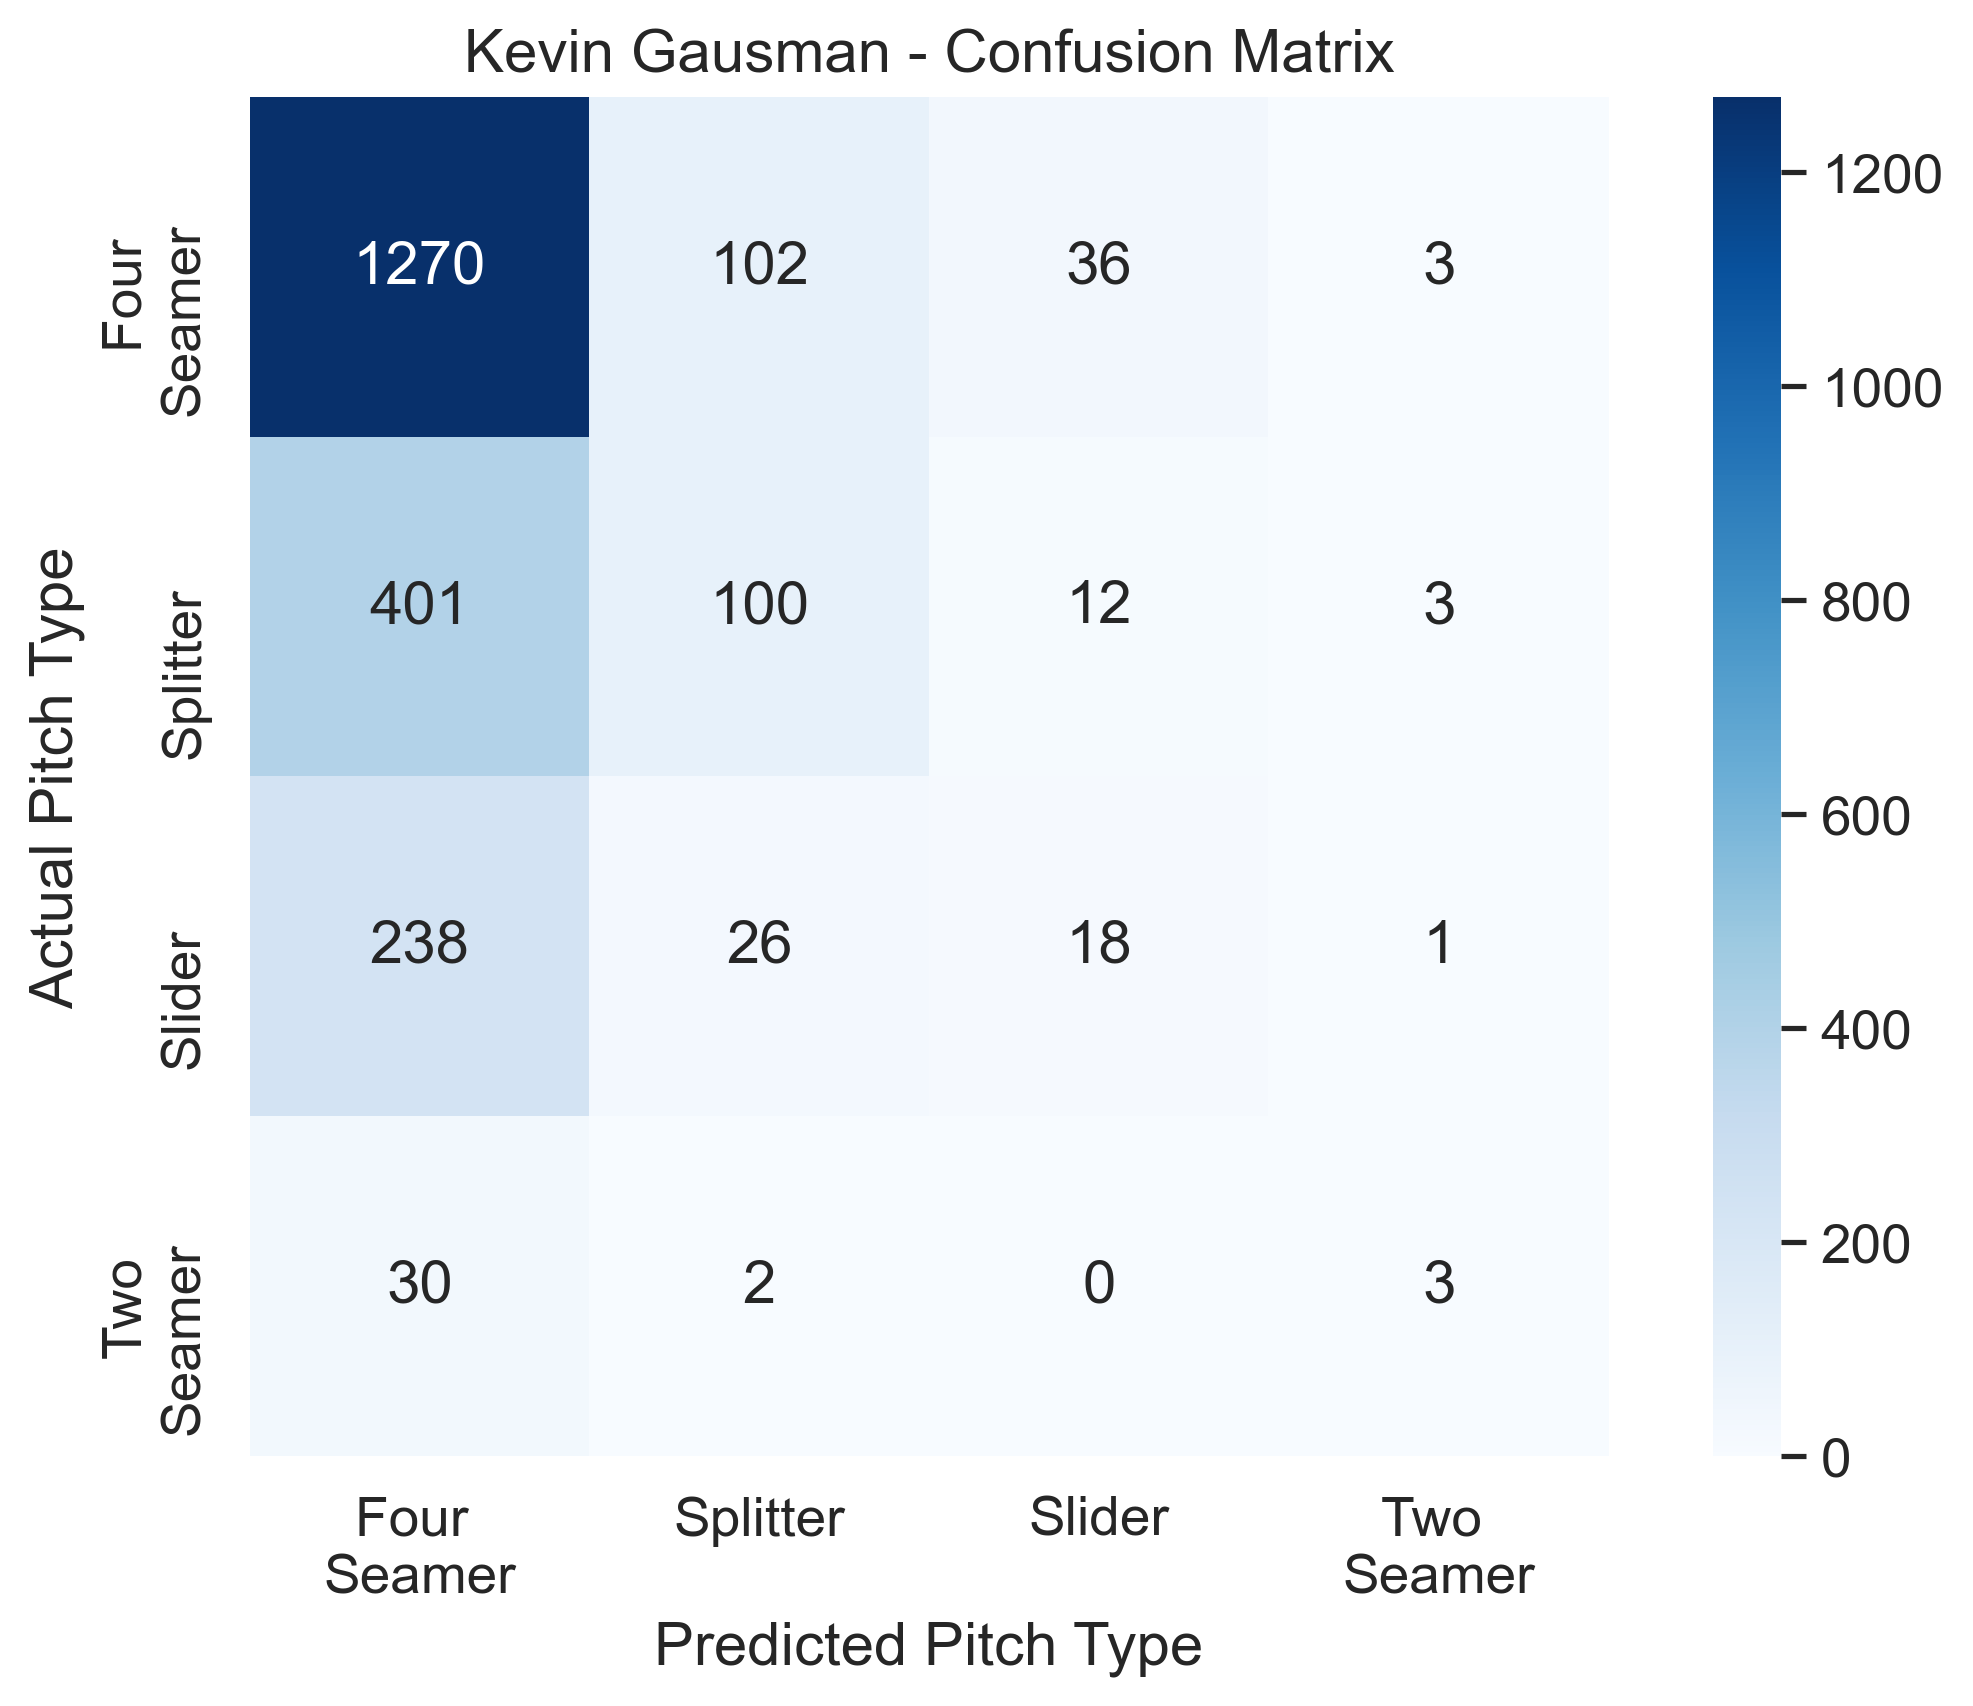

In [162]:
confusion_matrix_generator(cm, 'Kevin Gausman', kg_pitches)

In [166]:
combined_df[combined_df.pitcher_full_name == 'Kevin Gausman'].iloc[:, 35:48].tail(1)

,cumulative_ff_rate,cumulative_sl_rate,cumulative_ft_rate,cumulative_ch_rate,cumulative_cu_rate,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate
2844134,0.621824,0.132498,0.018172,0.0,0.0,0.0,0.0,0.0,0.227505,0.0,0.0,0.0,0.0


### Chris Sale:

In [168]:
cs_tr, cs_val = dataframe_setup_l5('Chris Sale',combined_df, split_size = 0.2)

Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FA': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FS': 4}
Actual Test Size: 0.24589511394168573


In [170]:
X_xg_train = cs_tr[xg_cols]
y_xg_train = cs_tr['Pitch_Type_Num']
X_xg_val = cs_val[xg_cols]
y_xg_val = cs_val['Pitch_Type_Num']

In [171]:
xg_model = XGBClassifier()
xg_model.fit(X_xg_train,y_xg_train)
y_xg_pred = xg_model.predict(X_xg_val)

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [172]:
cm = confusion_matrix(y_xg_val, y_xg_pred)

In [177]:
cs_pitches = ['Two \nSeamer', 'Slider', 'Changeup', 'Four \nSeamer']

In [178]:
cm

array([[567, 115, 122,  30],
       [232, 215,  74, 163],
       [234,  86, 154,  68],
       [ 21, 105,  41, 244]])

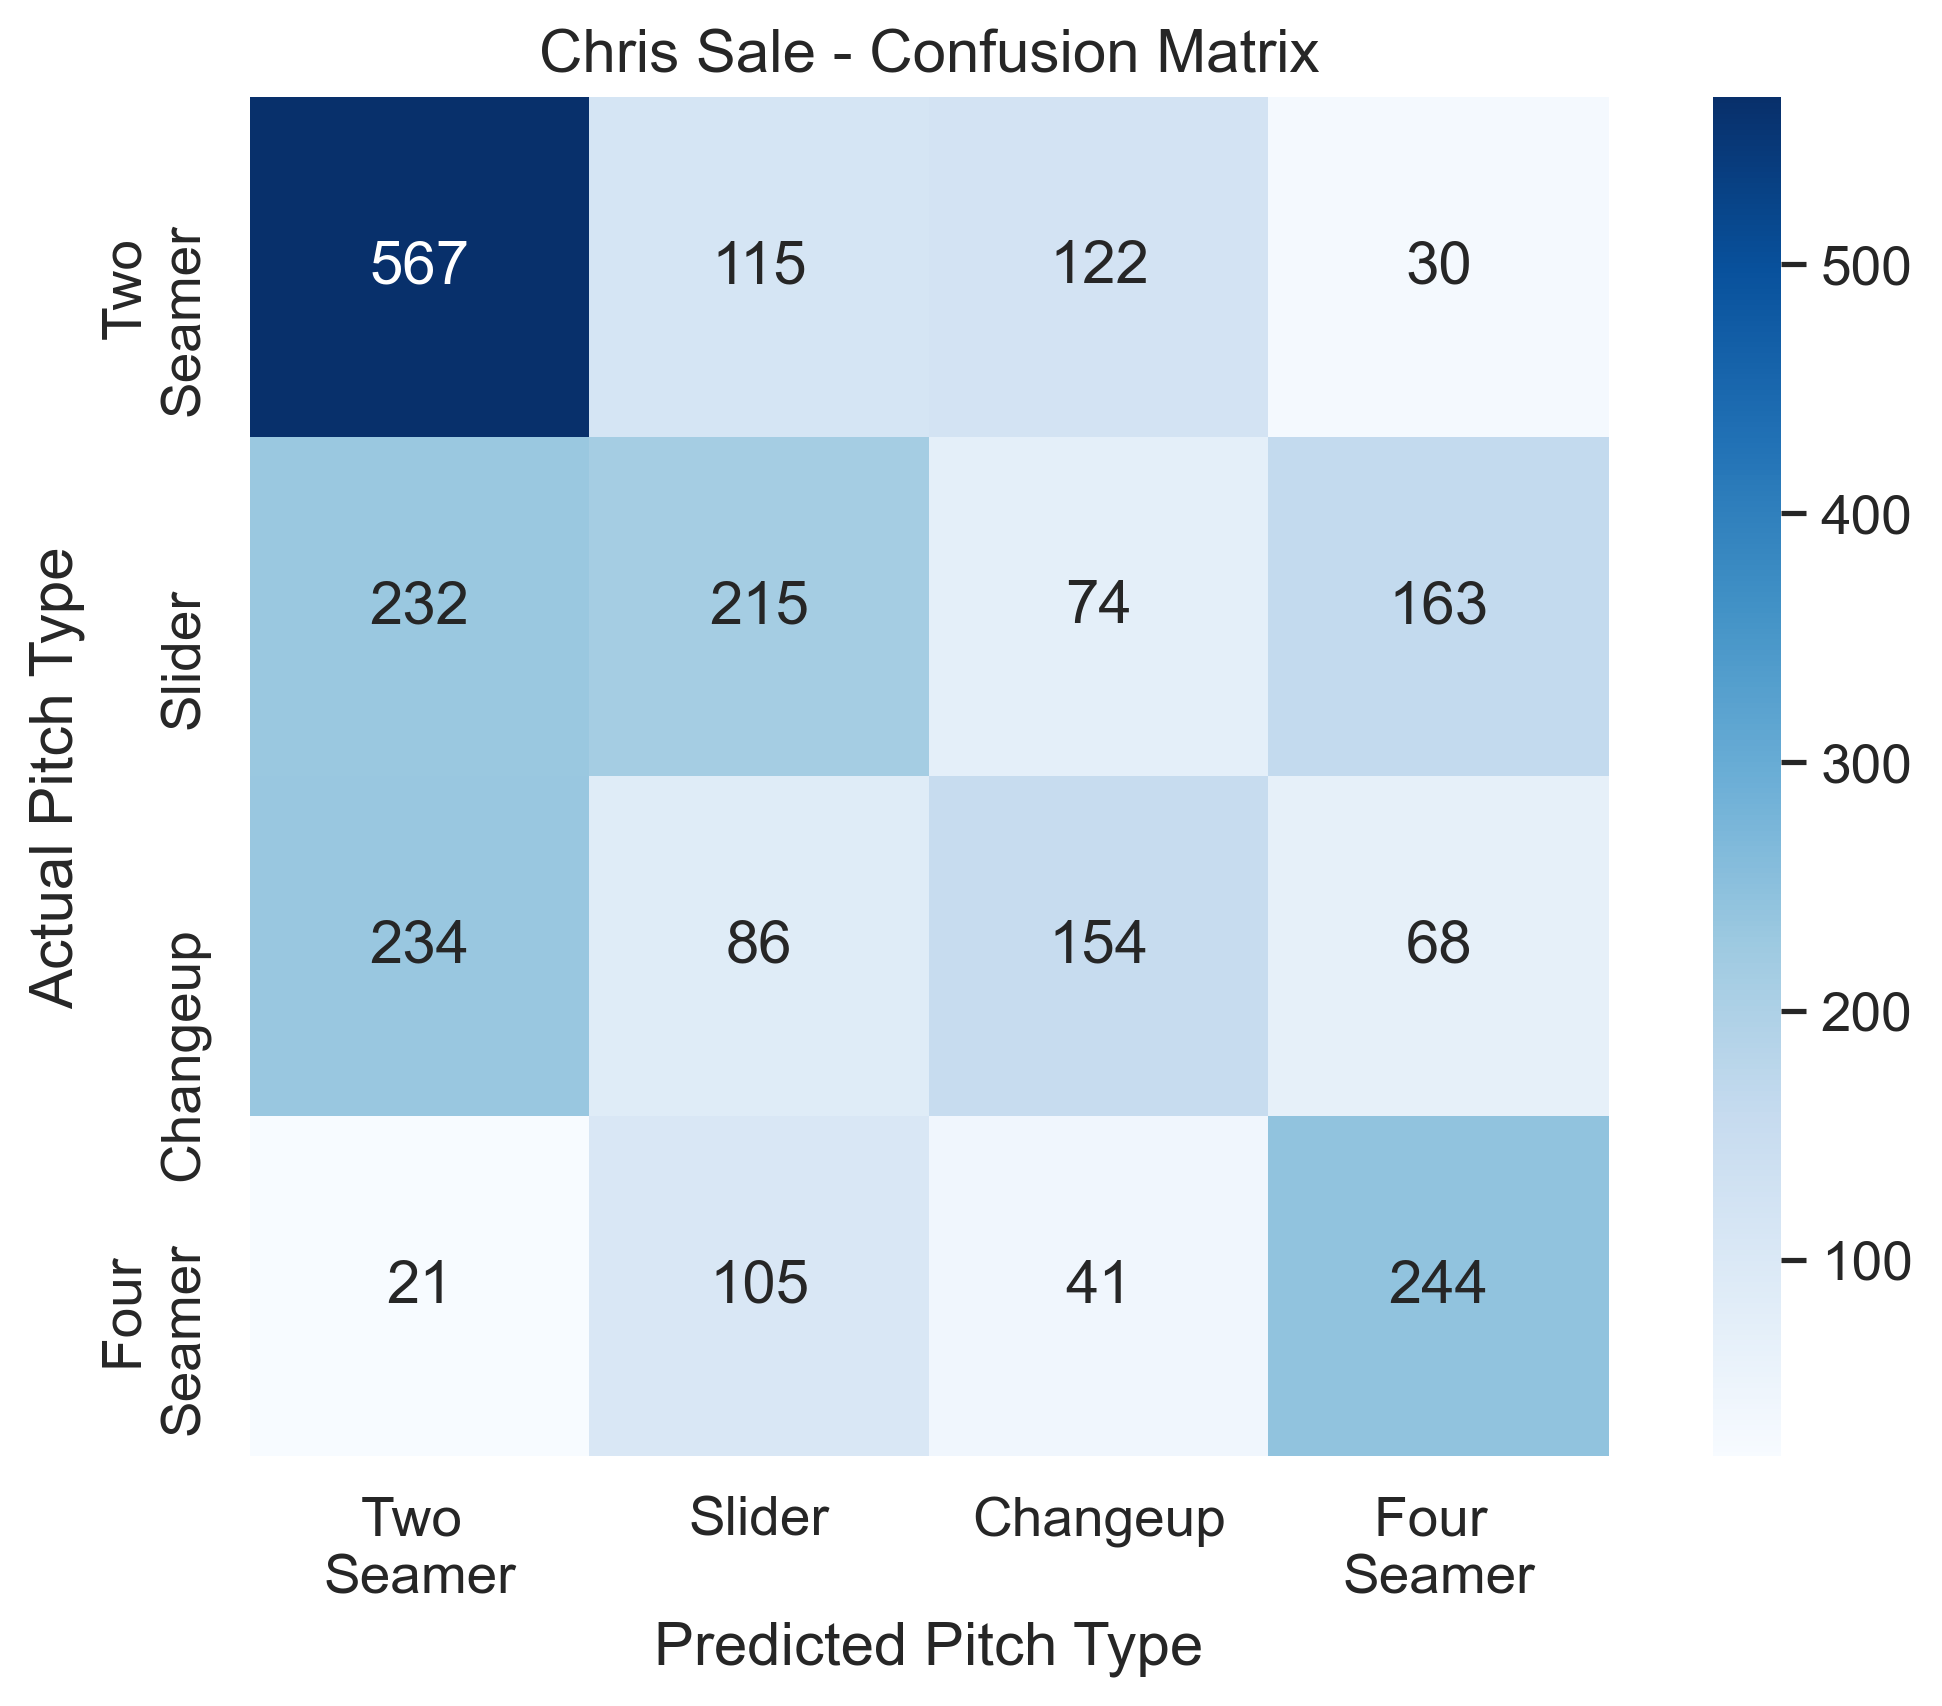

In [179]:
confusion_matrix_generator(cm, 'Chris Sale', cs_pitches)

In [181]:
combined_df[combined_df.pitcher_full_name == 'Kyle Hendricks'].iloc[:, 35:48].tail(1)

,cumulative_ff_rate,cumulative_sl_rate,cumulative_ft_rate,cumulative_ch_rate,cumulative_cu_rate,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate
2837901,0.113414,0.0,0.0,0.264542,0.076431,0.477765,0.067848,0.0,0.0,0.0,0.0,0.0,0.0


### Kyle Hendricks

In [182]:
kh_tr, kh_val = dataframe_setup_l5('Kyle Hendricks',combined_df, split_size = 0.2)

Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4}
Actual Test Size: 0.25280963967095355


In [183]:
X_xg_train = kh_tr[xg_cols]
y_xg_train = kh_tr['Pitch_Type_Num']
X_xg_val = kh_val[xg_cols]
y_xg_val = kh_val['Pitch_Type_Num']

In [184]:
xg_model = XGBClassifier()
xg_model.fit(X_xg_train,y_xg_train)
y_xg_pred = xg_model.predict(X_xg_val)

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [185]:
cm = confusion_matrix(y_xg_val, y_xg_pred)

In [187]:
kh_pitches = ['Sinker','Changeup', 'Four \nSeamer', 'Curveball', 'Cutter']

In [188]:
cm

array([[827, 150,  35,  17,  26],
       [249, 252,  35,  14,  14],
       [ 98,  75,  95,   7,   3],
       [ 65,  23,  19,  15,   4],
       [ 86,  30,   5,  10,  28]])

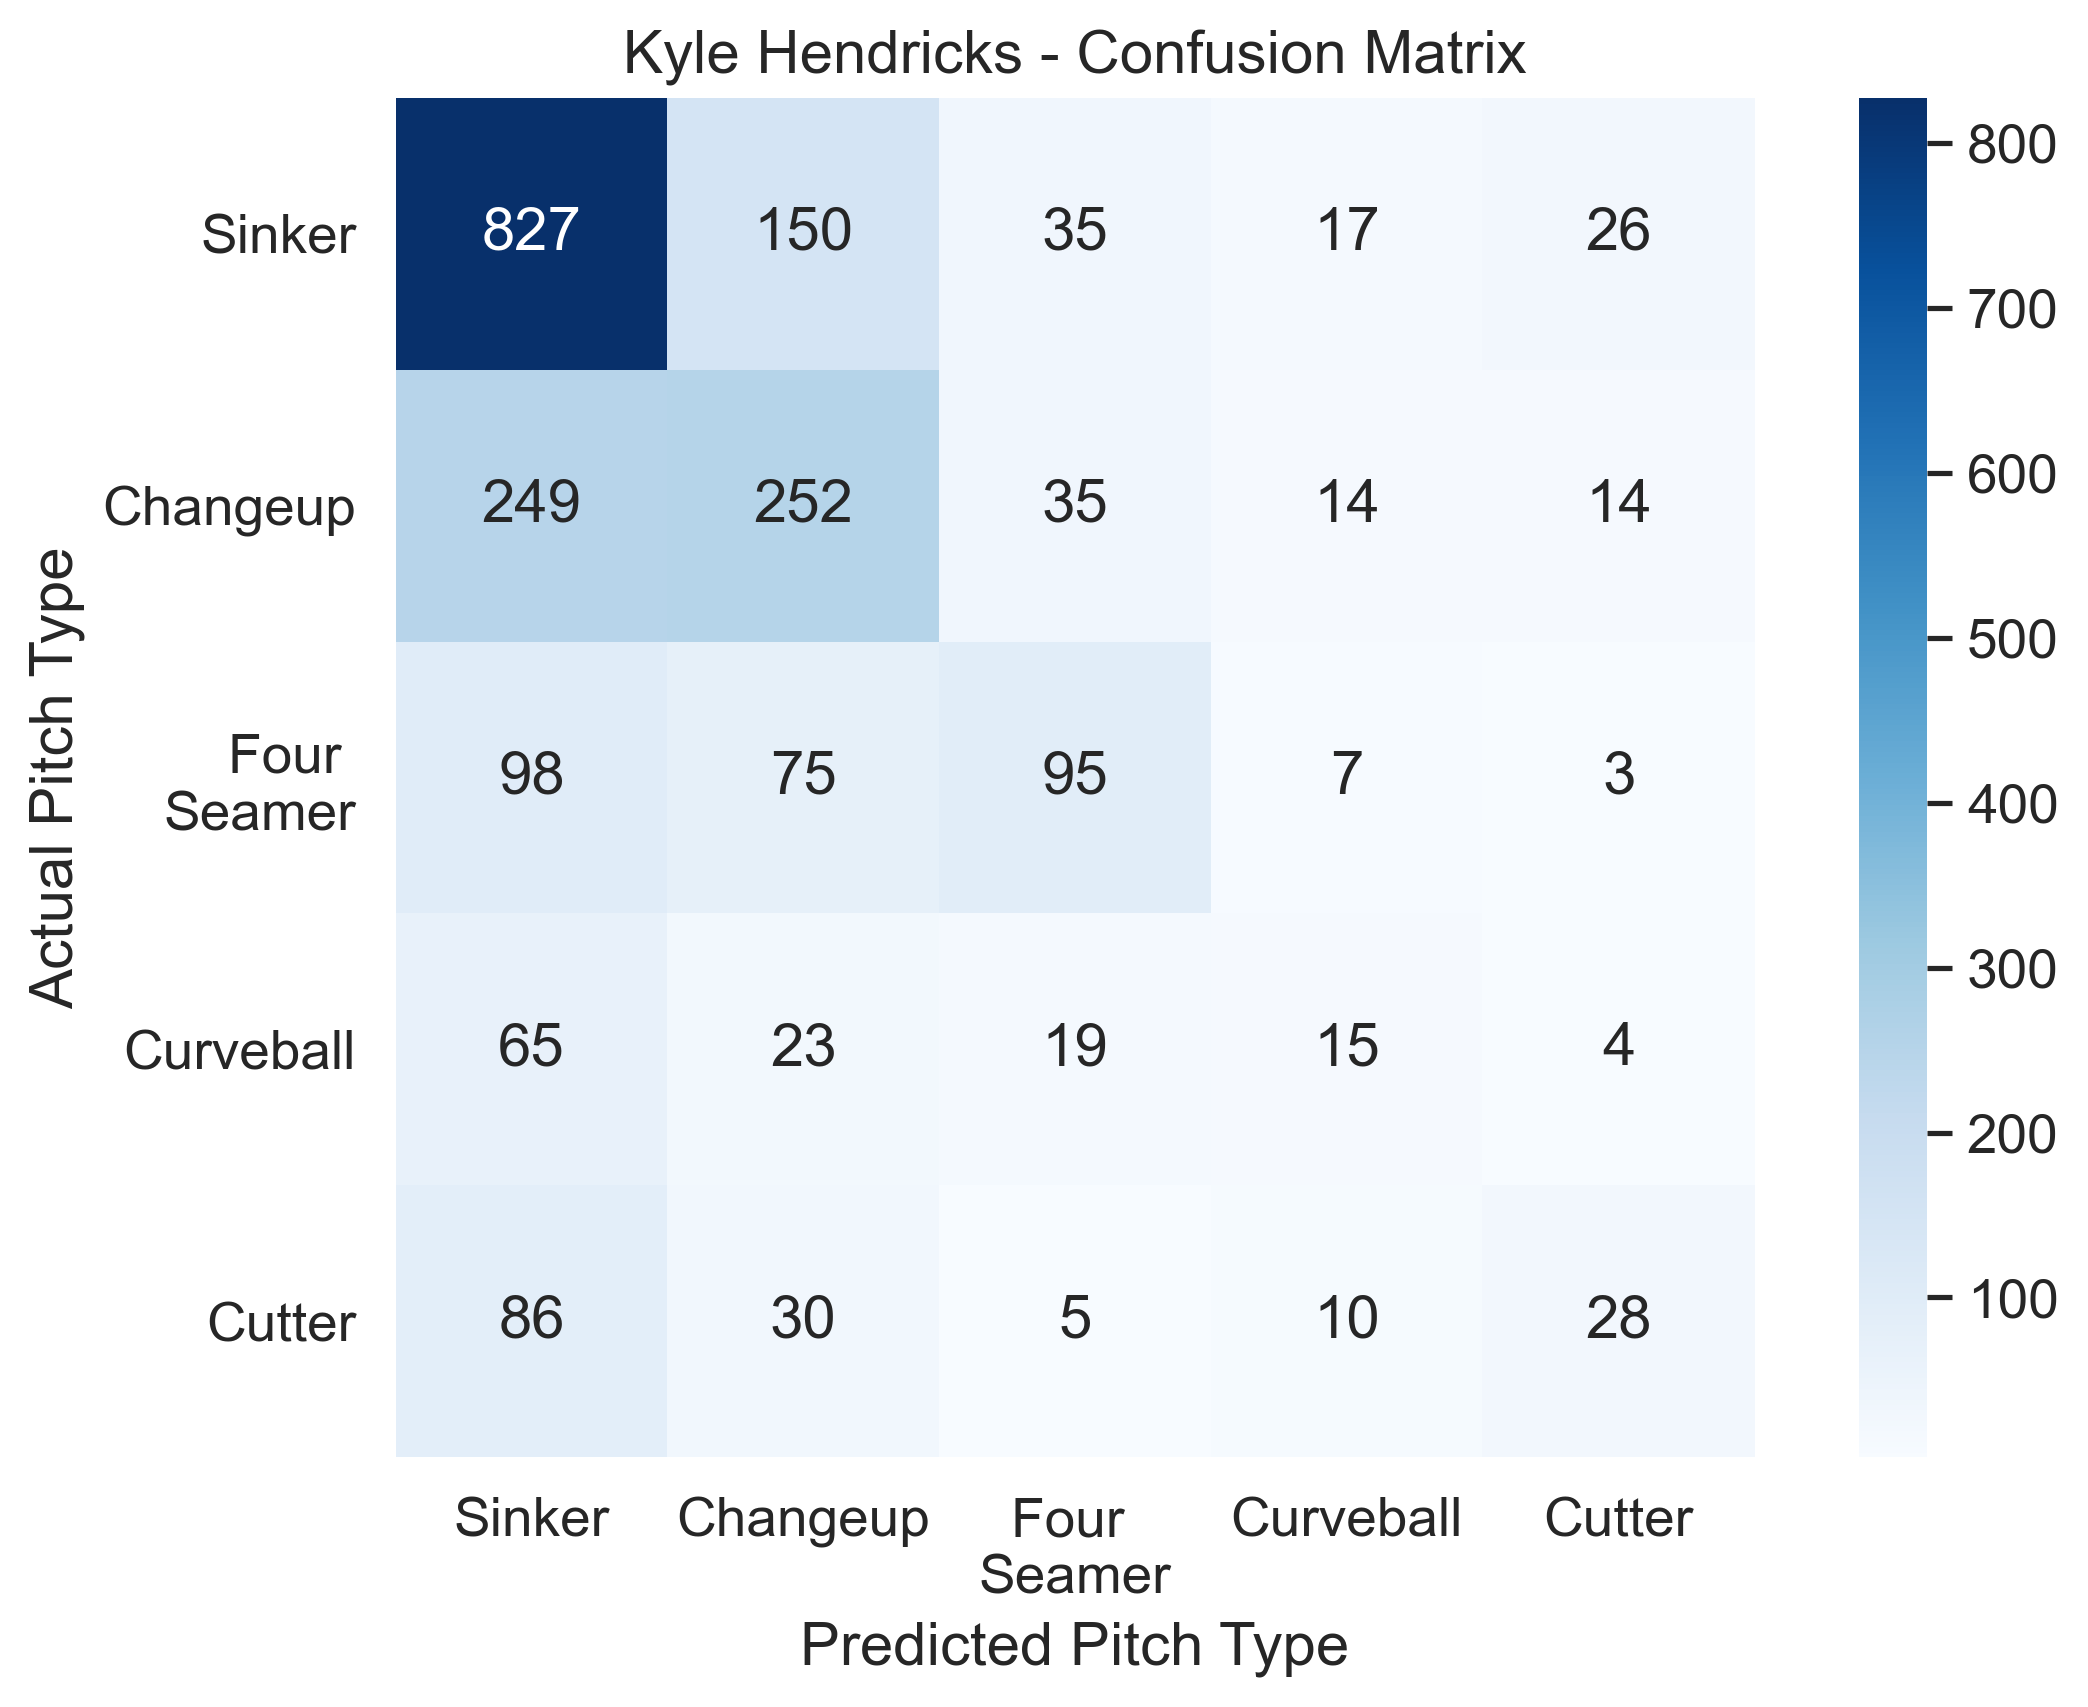

In [189]:
confusion_matrix_generator(cm, 'Kyle Hendricks', kh_pitches)

In [190]:
combined_df[combined_df.pitcher_full_name == 'Kyle Hendricks'].iloc[:, 35:48].tail(1)

,cumulative_ff_rate,cumulative_sl_rate,cumulative_ft_rate,cumulative_ch_rate,cumulative_cu_rate,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate
2837901,0.113414,0.0,0.0,0.264542,0.076431,0.477765,0.067848,0.0,0.0,0.0,0.0,0.0,0.0


### Oversampling

Just as a sanity check, testing out Oversampling with Kevin Gausman, as an exmaple of a pitcher with one dominant pitch type:

In [195]:
kg_tr, kg_val = dataframe_setup_l5('Kevin Gausman',combined_df, split_size = 0.2)

Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3}
Actual Test Size: 0.2519075403949731


In [196]:
import imblearn
from imblearn.over_sampling import SMOTE

In [197]:
X_xg_train = kg_tr[xg_cols]
y_xg_train = kg_tr['Pitch_Type_Num']
X_xg_val = kg_val[xg_cols]
y_xg_val = kg_val['Pitch_Type_Num']

In [198]:
oversample = SMOTE()
Xr_train, yr_train = oversample.fit_resample(X_xg_train, y_xg_train)

In [199]:
xg_model = XGBClassifier()
xg_model.fit(Xr_train,yr_train)
y_xg_pred = xg_model.predict(X_xg_val)

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [200]:
precision_score(y_xg_val, y_xg_pred, average='macro')

0.40723351024551513

In [201]:
cm = confusion_matrix(y_xg_val, y_xg_pred)

In [202]:
cm

array([[1210,  137,   59,    5],
       [ 370,  126,   15,    5],
       [ 226,   21,   35,    1],
       [  26,    5,    1,    3]])

In [203]:
recall_score(y_xg_val, y_xg_pred, average='macro')

0.3277807705747911

This is similar to the current model (w/in 1%).  Based on this, I don't think the modest gains justify drastically increasing the data.

# Test Data

Bringing in the test dataset, from Pitch_Classification_Intro.ipynb from this point:

In [214]:
with open('../Data/test_df_clusters.pickle','rb') as read_file:
    test_df_initial = pickle.load(read_file)

In [215]:
test_df_initial.shape

(707463, 49)

Last 10 dataframe:

In [216]:
last10_5_df_2019 = last10_5_df[last10_5_df.Season == 2019]

In [217]:
last10_5_df_2019.shape

(707463, 32)

In [218]:
last10_5_df_2019.tail()

,pitcher_id,batter_id,event,pitcher_full_name,pitch_type,Season,last_10_ff,last_10_sl,last_10_ft,last_10_ch,...,last_5_ch,last_5_cu,last_5_si,last_5_fc,last_5_kc,last_5_fs,last_5_kn,last_5_ep,last_5_fo,last_5_sc
3555829,571704,622110,Groundout,Ken Giles,FF,2019,2,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3555830,571704,605421,Strikeout,Ken Giles,SL,2019,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3555831,571704,605421,Strikeout,Ken Giles,FF,2019,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3555832,571704,605421,Strikeout,Ken Giles,SL,2019,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3555833,571704,605421,Strikeout,Ken Giles,SL,2019,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
test_df_initial.tail()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,cumulative_ch_rate,cumulative_cu_rate,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate
707458,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707459,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707460,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707461,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707462,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
last10_5_df_2019.reset_index(inplace=True)

In [227]:
last10_5_df_2019.columns

Index(['level_0', 'index', 'pitcher_id', 'batter_id', 'event',
       'pitcher_full_name', 'pitch_type', 'Season', 'last_10_ff', 'last_10_sl',
       'last_10_ft', 'last_10_ch', 'last_10_cu', 'last_10_si', 'last_10_fc',
       'last_10_kc', 'last_10_fs', 'last_10_kn', 'last_10_ep', 'last_10_fo',
       'last_10_sc', 'last_5_ff', 'last_5_sl', 'last_5_ft', 'last_5_ch',
       'last_5_cu', 'last_5_si', 'last_5_fc', 'last_5_kc', 'last_5_fs',
       'last_5_kn', 'last_5_ep', 'last_5_fo', 'last_5_sc'],
      dtype='object')

In [223]:
last10_5_df_2019.tail()

,level_0,index,pitcher_id,batter_id,event,pitcher_full_name,pitch_type,Season,last_10_ff,last_10_sl,...,last_5_ch,last_5_cu,last_5_si,last_5_fc,last_5_kc,last_5_fs,last_5_kn,last_5_ep,last_5_fo,last_5_sc
707458,707458,3555829,571704,622110,Groundout,Ken Giles,FF,2019,2,8,...,0,0,0,0,0,0,0,0,0,0
707459,707459,3555830,571704,605421,Strikeout,Ken Giles,SL,2019,3,7,...,0,0,0,0,0,0,0,0,0,0
707460,707460,3555831,571704,605421,Strikeout,Ken Giles,FF,2019,3,7,...,0,0,0,0,0,0,0,0,0,0
707461,707461,3555832,571704,605421,Strikeout,Ken Giles,SL,2019,3,7,...,0,0,0,0,0,0,0,0,0,0
707462,707462,3555833,571704,605421,Strikeout,Ken Giles,SL,2019,3,7,...,0,0,0,0,0,0,0,0,0,0


Resetting index on the last_10_5_2019 and merging:

In [230]:
merged_test_df = test_df_initial.merge(last10_5_df_2019.drop(columns=['level_0', 'index', 'pitcher_id', 'batter_id', 'event', 'pitcher_full_name', 'pitch_type', 'Season']), how='left', left_index=True, right_index=True)

In [231]:
merged_test_df.shape

(707463, 75)

In [232]:
merged_test_df.isnull().sum()

inning        0
batter_id     0
pitcher_id    0
top           0
ab_id         0
             ..
last_5_fs     0
last_5_kn     0
last_5_ep     0
last_5_fo     0
last_5_sc     0
Length: 75, dtype: int64

In [233]:
merged_test_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'Cluster', 'cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate', 'last_10_ff', 'last_10_sl', 'last_10_ft',
       'last_10_ch', 'last_10_cu', 'last_10_si', 'last_10_fc', 'last_10_kc',
       'last_10_fs', 'last_10_kn', 'last_10_ep', 'last_10_

Last step, removing outliers from the test data as in Pipeline_Part_2.ipynb:

In [234]:
right_rates_test = merged_test_df.copy()

In [235]:
#Defining interquartile range for Px and pz:
px_iqr = right_rates_test.px.quantile(0.75) - right_rates_test.px.quantile(0.25)
pz_iqr = right_rates_test.pz.quantile(0.75) - right_rates_test.pz.quantile(0.25)

#Whiskers are at 1.5 above and below the 25th/75th percentile:
px_lower = right_rates_test.px.quantile(0.25) - 1.5*px_iqr
px_upper = right_rates_test.px.quantile(0.75) + 1.5*px_iqr

pz_lower = right_rates_test.pz.quantile(0.25) - 1.5*pz_iqr
pz_upper = right_rates_test.pz.quantile(0.75) + 1.5*pz_iqr
print(px_lower, px_upper)
print(pz_lower, pz_upper)

-2.3049999999999997 2.375
-0.2549999999999999 4.745


In [237]:
outliers_removed_test = right_rates_test[((right_rates_test.px > px_lower) & (right_rates_test.px < px_upper)) & ((right_rates_test.pz > pz_lower) & (right_rates_test.pz < pz_upper))]

In [79]:
right_rates.shape

(707463, 49)

In [238]:
outliers_removed_test.shape

(694670, 75)

In [ ]:
Last step, removing outliers from the test data as in Pipeline_Part_2.ipynb:

right_rates = merged_test_df.copy()

#Defining interquartile range for Px and pz:
px_iqr = right_rates.px.quantile(0.75) - right_rates.px.quantile(0.25)
pz_iqr = right_rates.pz.quantile(0.75) - right_rates.pz.quantile(0.25)

#Whiskers are at 1.5 above and below the 25th/75th percentile:
px_lower = right_rates.px.quantile(0.25) - 1.5*px_iqr
px_upper = right_rates.px.quantile(0.75) + 1.5*px_iqr

pz_lower = right_rates.pz.quantile(0.25) - 1.5*pz_iqr
pz_upper = right_rates.pz.quantile(0.75) + 1.5*pz_iqr
print(px_lower, px_upper)
print(pz_lower, pz_upper)

outliers_removed = right_rates[((right_rates.px > px_lower) & (right_rates.px < px_upper)) & ((right_rates.pz > pz_lower) & (right_rates.pz < pz_upper))]

right_rates.shape

outliers_removed.shape

### Test Scoring:

Moving into scoring the models on the test.

In [326]:
pitcher_list_50

Index(['Max Scherzer', 'Justin Verlander', 'Chris Sale', 'Chris Archer',
       'Jose Quintana', 'Jon Lester', 'Corey Kluber', 'Rick Porcello',
       'Gio Gonzalez', 'Julio Teheran', 'Zack Greinke', 'Jake Arrieta',
       'Cole Hamels', 'Jacob deGrom', 'Gerrit Cole', 'Dallas Keuchel',
       'Trevor Bauer', 'Jake Odorizzi', 'Kyle Gibson', 'James Shields',
       'Marco Estrada', 'J.A. Happ', 'Kevin Gausman', 'Tanner Roark',
       'Mike Leake', 'David Price', 'Kyle Hendricks', 'Ian Kennedy',
       'Carlos Martinez', 'Carlos Carrasco', 'Mike Fiers', 'Andrew Cashner',
       'Jeff Samardzija', 'Madison Bumgarner', 'CC Sabathia',
       'Masahiro Tanaka', 'Jason Hammel', 'Robbie Ray', 'Wade Miley',
       'Bartolo Colon', 'Clayton Kershaw', 'Danny Duffy', 'Patrick Corbin',
       'Chase Anderson', 'Johnny Cueto', 'Sonny Gray', 'Francisco Liriano',
       'Jordan Zimmermann', 'Hector Santiago', 'Felix Hernandez'],
      dtype='object')

In [327]:
pitcher_list_50[39]

'Bartolo Colon'

In [328]:
test_pitchers = np.delete(pitcher_list_50, [19, 36, 39])

In [329]:
test_pitchers.shape

(47,)

In [305]:
np.delete(test_pitchers, 19)

Index(['Max Scherzer', 'Justin Verlander', 'Chris Sale', 'Chris Archer',
       'Jose Quintana', 'Jon Lester', 'Corey Kluber', 'Rick Porcello',
       'Gio Gonzalez', 'Julio Teheran', 'Zack Greinke', 'Jake Arrieta',
       'Cole Hamels', 'Jacob deGrom', 'Gerrit Cole', 'Dallas Keuchel',
       'Trevor Bauer', 'Jake Odorizzi', 'Kyle Gibson', 'Marco Estrada',
       'J.A. Happ', 'Kevin Gausman', 'Tanner Roark', 'Mike Leake',
       'David Price', 'Kyle Hendricks', 'Ian Kennedy', 'Carlos Martinez',
       'Carlos Carrasco', 'Mike Fiers', 'Andrew Cashner', 'Jeff Samardzija',
       'Madison Bumgarner', 'CC Sabathia', 'Masahiro Tanaka', 'Jason Hammel',
       'Robbie Ray', 'Wade Miley', 'Bartolo Colon', 'Clayton Kershaw',
       'Danny Duffy', 'Patrick Corbin', 'Chase Anderson', 'Johnny Cueto',
       'Sonny Gray', 'Francisco Liriano', 'Jordan Zimmermann',
       'Hector Santiago', 'Felix Hernandez'],
      dtype='object')

In [263]:
combined_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate',
       'Cluster', 'last_100_ff', 'last_100_sl', 'last_100_ft', 'last_100_ch',
       'last_100_cu', 'last_100_si', 'last_100_fc', 'last_100_kc',
       'last_100_fs', 'last_100_kn', 'last_100_ep'

In [330]:
from final_model_scorer__final_2__1 import *

In [306]:
test_pitchers

Index(['Max Scherzer', 'Justin Verlander', 'Chris Sale', 'Chris Archer',
       'Jose Quintana', 'Jon Lester', 'Corey Kluber', 'Rick Porcello',
       'Gio Gonzalez', 'Julio Teheran', 'Zack Greinke', 'Jake Arrieta',
       'Cole Hamels', 'Jacob deGrom', 'Gerrit Cole', 'Dallas Keuchel',
       'Trevor Bauer', 'Jake Odorizzi', 'Kyle Gibson', 'James Shields',
       'Marco Estrada', 'J.A. Happ', 'Kevin Gausman', 'Tanner Roark',
       'Mike Leake', 'David Price', 'Kyle Hendricks', 'Ian Kennedy',
       'Carlos Martinez', 'Carlos Carrasco', 'Mike Fiers', 'Andrew Cashner',
       'Jeff Samardzija', 'Madison Bumgarner', 'CC Sabathia',
       'Masahiro Tanaka', 'Jason Hammel', 'Robbie Ray', 'Wade Miley',
       'Bartolo Colon', 'Clayton Kershaw', 'Danny Duffy', 'Patrick Corbin',
       'Chase Anderson', 'Johnny Cueto', 'Sonny Gray', 'Francisco Liriano',
       'Jordan Zimmermann', 'Hector Santiago', 'Felix Hernandez'],
      dtype='object')

In [331]:
test_df = multiple_pitcher_scores(test_pitchers, outliers_removed_test[outliers_removed_test.pitch_type != 'EP'], model_dict, combined_df)

Pitch Modeling Test Set SCores for Max Scherzer
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.4832116788321168
Test Set Precision: (0.3426817836489163,)
Test Set Recall: 0.20686414473795817
XGBoost Pitch Classification confusion matrix test set results:
[[1295   26    6    5    1]
 [ 541   22    1    1    0]
 [ 373   15    4    3    1]
 [ 234    1    1    1    0]
 [ 204    1    2    0    2]]
Val Px MAE: 0.6547337083100271 ft.
Val Pz MAE: 0.6769012561270504 ft.




Pitch Modeling Test Set SCores for Justin Verlander
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FC': 4, 'FT': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.4965732087227414
Test Set Precision: (0.19926233628668122,)
Test Set Recall: 0.25510426696311195
XGBoost Pitch Classification confusion matrix test set results:
[[1573    0   28    0]
 [ 903    0   18    0]
 [ 532    1   21    0]
 [ 130    0    4    0]]
Val Px MAE: 0.5693220431679397 ft.
Val Pz MAE: 0.692632371654494 ft.




Pitch Modeling Test Set SCores for Chris Sale
Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FS': 4}
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'FA': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.23140495867768596
Test Set Precision: (0.32263612977425415,)
Test Set Recall: 0.2830261883875149
XGBoost Pitch Classification confusion matrix test set results:
[[ 15  42 139  57]
 [ 17  87 639 179]
 [  6   7 303  63]
 [ 14  43 654 155]]
Val Px MAE: 0.7195549811217903 ft.
Val Pz MAE: 0.622452522704871 ft.




Pitch Modeling Test Set SCores for Chris Archer
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.38095238095238093
Test Set Precision: (0.23031172818903944,)
Test Set Recall: 0.2284333441324587
XGBoost Pitch Classification confusion matrix test set results:
[[ 91 652  34   0  33]
 [ 47 660  18   1   7]
 [ 29 183  33   0  10]
 [ 38 161  11   0   7]
 [  8  32   3   0   0]]
Val Px MAE: 0.6274655567426556 ft.
Val Pz MAE: 0.8074651728294383 ft.




Pitch Modeling Test Set SCores for Jose Quintana
Here is the coding for pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4}
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'SI': 2, 'CH': 3, 'FT': 4, 'PO': 5, 'UN': 6, 'FA': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.3577570093457944
Test Set Precision: (0.3111531684170165,)
Test Set Recall: 0.26947554738758683
XGBoost Pitch Classification confusion matrix test set results:
[[709 246  10   0]
 [492 231   2   0]
 [476 199  17   0]
 [197  95   1   0]]
Val Px MAE: 0.5877775899424221 ft.
Val Pz MAE: 0.760987286405438 ft.




Pitch Modeling Test Set SCores for Jon Lester
Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4}
Here is the coding for last pitch type:
{'FF': 0, 'FC': 1, 'CU': 2, 'SI': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.2761744966442953
Test Set Precision: (0.1280172738774704,)
Test Set Recall: 0.2111949505627107
XGBoost Pitch Classification confusion matrix test set results:
[[775   2  11  68   0]
 [934   0  14  75   0]
 [402   0   6  27   0]
 [264   0   1  42   0]
 [331   1   2  25   0]]
Val Px MAE: 0.7099856725505009 ft.
Val Pz MAE: 0.5630383509353585 ft.




Pitch Modeling Test Set SCores for Corey Kluber
Here is the coding for pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5}
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'FF': 2, 'SL': 3, 'FC': 4, 'CH': 5, 'PO': 6}
Test Set Accuracy: 0.23205342237061768
Test Set Precision: (0.15723723723723723,)
Test Set Recall: 0.16755133117202084
XGBoost Pitch Classification confusion matrix test set results:
[[60  1 23 73  3]
 [63  1 14 56  1]
 [50  1  1 26  0]
 [81  0 14 77  2]
 [16  1  8 27  0]]
Val Px MAE: 0.6827698821593566 ft.
Val Pz MAE: 0.7115721478789039 ft.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)






Pitch Modeling Test Set SCores for Rick Porcello
Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CU': 3, 'CH': 4, 'SI': 5}
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'EP': 5, 'PO': 6, 'SI': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.1974544203646371
Test Set Precision: (0.2522988055168424,)
Test Set Recall: 0.24486346946997326
XGBoost Pitch Classification confusion matrix test set results:
[[147  26 127 437  19]
 [252  33  95 493  31]
 [105  20 118 286  17]
 [ 61   3  32 254   6]
 [101   9  31 182  22]]
Val Px MAE: 0.6389993313453854 ft.
Val Pz MAE: 0.7029403619829043 ft.




Pitch Modeling Test Set SCores for Gio Gonzalez
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'CH': 3, 'UN': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.30486008836524303
Test Set Precision: (0.3029293172248029,)
Test Set Recall: 0.27886396114896755
XGBoost Pitch Classification confusion matrix test set results:
[[ 98 162   9  88]
 [ 80 169  13  90]
 [ 45 101  11  50]
 [ 83 213  10 136]]
Val Px MAE: 0.6062926409021527 ft.
Val Pz MAE: 0.6739266071080288 ft.




Pitch Modeling Test Set SCores for Julio Teheran
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'PO': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.4179805434417981
Test Set Precision: (0.0836241610738255,)
Test Set Recall: 0.19983961507618284
XGBoost Pitch Classification confusion matrix test set results:
[[1246    1    0    0    0]
 [ 616    0    0    0    0]
 [ 682    0    0    0    0]
 [ 248    0    0    0    0]
 [ 188    0    0    0    0]]
Val Px MAE: 0.6990258531227899 ft.
Val Pz MAE: 0.6138212034073242 ft.




Pitch Modeling Test Set SCores for Zack Greinke
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FT': 4, 'EP': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.3737737083060824
Test Set Precision: (0.3135967935391012,)
Test Set Recall: 0.23988903800086397
XGBoost Pitch Classification confusion matrix test set results:
[[1030   54   19    0  171]
 [ 315   49    3    1  121]
 [ 570   21   21    1   67]
 [ 351   26    7    1   67]
 [ 102   19    0    0   42]]
Val Px MAE: 0.6549870820225977 ft.
Val Pz MAE: 0.6239299795838341 ft.




Pitch Modeling Test Set SCores for Jake Arrieta
Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'CU': 2, 'FF': 3, 'CH': 4}
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FF': 2, 'CU': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.15076779897626802
Test Set Precision: (0.2094172600615513,)
Test Set Recall: 0.20799039615451229
XGBoost Pitch Classification confusion matrix test set results:
[[  66 1107   29    4    0]
 [   9  244    8    0    0]
 [   8  256   14    0    0]
 [   2   19    0    0    0]
 [   9  362   12    0    0]]
Val Px MAE: 0.6669894208169789 ft.
Val Pz MAE: 0.6694883369931008 ft.




Pitch Modeling Test Set SCores for Cole Hamels
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'FC': 3, 'CU': 4, 'SL': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.33347457627118643
Test Set Precision: (0.21912207326864994,)
Test Set Recall: 0.1982163278964775
XGBoost Pitch Classification confusion matrix test set results:
[[537  25 210  59   6   0]
 [143  28  98  19   1   0]
 [244  19 189  51   3   1]
 [257  12 142  30   4   0]
 [151   4  93  30   3   1]
 [  0   0   0   0   0   0]]
Val Px MAE: 0.6331146636761728 ft.
Val Pz MAE: 0.6840154770632312 ft.




Pitch Modeling Test Set SCores for Jacob deGrom
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.34891064098515945
Test Set Precision: (0.228690137482984,)
Test Set Recall: 0.2053720203390128
XGBoost Pitch Classification confusion matrix test set results:
[[1063   15   51    5  392]
 [ 654   11   39    8  308]
 [  23    0    3    0    8]
 [ 318   16   26    8  126]
 [  68    0    2    3   20]]
Val Px MAE: 0.6174555733690815 ft.
Val Pz MAE: 0.6254770062020366 ft.




Pitch Modeling Test Set SCores for Gerrit Cole
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'KC': 2, 'SI': 3, 'CH': 4, 'FT': 5, 'CU': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.4368242199567501
Test Set Precision: (0.2836852469735273,)
Test Set Recall: 0.24400623496852747
XGBoost Pitch Classification confusion matrix test set results:
[[1203  182    5  268   15]
 [ 492  128    2  115    7]
 [ 324   67    6   97    4]
 [ 142   22    0   77    2]
 [  58   12    1    8    0]]
Val Px MAE: 0.5877142030316534 ft.
Val Pz MAE: 0.7152517355344159 ft.




Pitch Modeling Test Set SCores for Dallas Keuchel
Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FC': 3, 'FF': 4}
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FC': 2, 'CH': 3, 'FF': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.3300653594771242
Test Set Precision: (0.27657210880748717,)
Test Set Recall: 0.28318113705713566
XGBoost Pitch Classification confusion matrix test set results:
[[423 380  26  37  43]
 [ 56 120   8  10   8]
 [123  95  17  19  14]
 [115 173  23  26  30]
 [ 33  31   5   1  20]]
Val Px MAE: 0.7841867011253384 ft.
Val Pz MAE: 0.6200123488321014 ft.




Pitch Modeling Test Set SCores for Trevor Bauer
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'KC': 2, 'FC': 3, 'CH': 4, 'CU': 5, 'SL': 6}
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'FC': 2, 'FT': 3, 'CH': 4, 'CU': 5, 'SL': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.2599830076465591
Test Set Precision: (0.24976086145404186,)
Test Set Recall: 0.2667136052393013
XGBoost Pitch Classification confusion matrix test set results:
[[366  32  31 227 377 355]
 [ 50  10   2  18  26  27]
 [108  11  27 113 265 146]
 [ 91   6   8 134 157 196]
 [ 83   2  13  32 123  18]
 [ 63  17  14  74  51 258]]
Val Px MAE: 0.5997172380145158 ft.
Val Pz MAE: 0.7591621161949806 ft.




Pitch Modeling Test Set SCores for Jake Odorizzi
Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'FT': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'FC': 4, 'CU': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.44994539497633784
Test Set Precision: (0.18996575887880235,)
Test Set Recall: 0.19258740853208495
XGBoost Pitch Classification confusion matrix test set results:
[[1118  333  121    4    8]
 [ 335  115   24    0    5]
 [   0    0    0    0    0]
 [ 367   35  102    0    4]
 [ 112   37   24    0    3]]
Val Px MAE: 0.5608497593551 ft.
Val Pz MAE: 0.7456040771981692 ft.




Pitch Modeling Test Set SCores for Kyle Gibson
Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.32533234859675036
Test Set Precision: (0.2596394498822946,)
Test Set Recall: 0.22129088781566142
XGBoost Pitch Classification confusion matrix test set results:
[[770  96   3   9   0]
 [389  95   1   6   2]
 [492  58   1   9   0]
 [360  59   0  14   4]
 [295  42   0   2   1]]
Val Px MAE: 0.6712453233339101 ft.
Val Pz MAE: 0.7034415536984937 ft.




Pitch Modeling Test Set SCores for Marco Estrada
Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3}
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'FC': 2, 'CU': 3, 'PO': 4}
Test Set Accuracy: 0.37003058103975534
Test Set Precision: (0.25393892406426327,)
Test Set Recall: 0.3173380863886621
XGBoost Pitch Classification confusion matrix test set results:
[[62 71  1 38]
 [29 54  0 20]
 [17 10  0 12]
 [ 1  7  0  5]]
Val Px MAE: 0.5654441413776538 ft.
Val Pz MAE: 0.7299016103971373 ft.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)






Pitch Modeling Test Set SCores for J.A. Happ
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.4890648567119155
Test Set Precision: (0.3205348833561665,)
Test Set Recall: 0.21650896178973547
XGBoost Pitch Classification confusion matrix test set results:
[[1247    5   16   16    0]
 [ 438    7   22    3    0]
 [ 417    6   30    7    0]
 [ 399    1    3   13    0]
 [  20    0    0    2    0]]
Val Px MAE: 0.6556778105101019 ft.
Val Pz MAE: 0.6808090401631268 ft.




Pitch Modeling Test Set SCores for Kevin Gausman
Here is the coding for pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3}
Here is the coding for last pitch type:
{'FF': 0, 'FS': 1, 'SL': 2, 'FT': 3, 'PO': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.5151890886546807
Test Set Precision: (0.2828647552637761,)
Test Set Recall: 0.33332640629762333
XGBoost Pitch Classification confusion matrix test set results:
[[827   3 102]
 [568   1  85]
 [ 24   0   3]]
Val Px MAE: 0.6052007904432386 ft.
Val Pz MAE: 0.6334413033852995 ft.




Pitch Modeling Test Set SCores for Tanner Roark
Here is the coding for pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6}
Here is the coding for last pitch type:
{'SI': 0, 'FT': 1, 'SL': 2, 'CU': 3, 'FF': 4, 'CH': 5, 'FC': 6, 'PO': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.22226237802674376
Test Set Precision: (0.22234898739776612,)
Test Set Recall: 0.21930165590845596
XGBoost Pitch Classification confusion matrix test set results:
[[152 105 366  74 134  10]
 [ 99 105 216  67 110   2]
 [ 27  21 216  19  63   2]
 [115  48 348  80 107   6]
 [ 19  14 161  17  62   2]
 [  0   0   0   0   0   0]]
Val Px MAE: 0.6543974499496078 ft.
Val Pz MAE: 0.7551429540223309 ft.




Pitch Modeling Test Set SCores for Mike Leake
Here is the coding for pitch type:
{'SI': 0, 'FC': 1, 'CH': 2, 'SL': 3, 'KC': 4, 'FF': 5}
Here is the coding for last pitch type:
{'SI': 0, 'FC': 1, 'KC': 2, 'CH': 3, 'SL': 4, 'FF': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.18245967741935484
Test Set Precision: (0.11361890372400206,)
Test Set Recall: 0.17310967605854996
XGBoost Pitch Classification confusion matrix test set results:
[[520   0   1   5  16   0]
 [746   0   5   9  23   0]
 [585   0   2   8  30   0]
 [336   0   1   9  24   0]
 [212   0   0   8  12   0]
 [393   0   0  12  19   0]]
Val Px MAE: 0.6593220464827052 ft.
Val Pz MAE: 0.569984239784408 ft.




Pitch Modeling Test Set SCores for David Price
Here is the coding for pitch type:
{'FT': 0, 'CH': 1, 'FC': 2, 'FF': 3, 'KC': 4}
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'FC': 3, 'KC': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.25776566757493186
Test Set Precision: (0.23436852679164266,)
Test Set Recall: 0.23214863250051726
XGBoost Pitch Classification confusion matrix test set results:
[[226  48 200   6   0]
 [177  58 237  15   0]
 [108  34 173   6   0]
 [229  48 209  16   0]
 [ 12   3  29   1   0]]
Val Px MAE: 0.6666696237573603 ft.
Val Pz MAE: 0.6935133782829165 ft.




Pitch Modeling Test Set SCores for Kyle Hendricks
Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4}
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'FF': 2, 'CU': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.4722430607651913
Test Set Precision: (0.4555074872235149,)
Test Set Recall: 0.335476818930269
XGBoost Pitch Classification confusion matrix test set results:
[[1027    5   76    2]
 [ 561   43  145    5]
 [ 333   24  183    4]
 [ 190    1   61    6]]
Val Px MAE: 0.6069266196866572 ft.
Val Pz MAE: 0.7065123280663202 ft.




Pitch Modeling Test Set SCores for Ian Kennedy
Here is the coding for pitch type:
{'FF': 0, 'KC': 1, 'CH': 2, 'FT': 3, 'SL': 4}
Here is the coding for last pitch type:
{'FF': 0, 'KC': 1, 'SL': 2, 'CH': 3, 'FT': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.29029217719132894
Test Set Precision: (0.25779033159467624,)
Test Set Recall: 0.22404726498970912
XGBoost Pitch Classification confusion matrix test set results:
[[249 299 151 190]
 [ 36  54  37  26]
 [  6   8   5   0]
 [  0   0   0   0]]
Val Px MAE: 0.5966629003136715 ft.
Val Pz MAE: 0.6230324726421322 ft.




Pitch Modeling Test Set SCores for Carlos Martinez
Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Here is the coding for last pitch type:
{'FT': 0, 'FF': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.22563417890520696
Test Set Precision: (0.19512495333674368,)
Test Set Recall: 0.2166395608593355
XGBoost Pitch Classification confusion matrix test set results:
[[116   0  25   9   6]
 [149   1  48  19   9]
 [ 85   1  36  11   6]
 [167   3  16  16   8]
 [ 10   0   6   2   0]]
Val Px MAE: 0.7467171779897135 ft.
Val Pz MAE: 0.6598616463450878 ft.




Pitch Modeling Test Set SCores for Carlos Carrasco
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'FT': 3, 'CU': 4, 'PO': 5, 'AB': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.3509933774834437
Test Set Precision: (0.28206871436623154,)
Test Set Recall: 0.2946155498659081
XGBoost Pitch Classification confusion matrix test set results:
[[132 117  84  76   4]
 [121 140  78  68   3]
 [ 21  18  99  85   0]
 [ 30  13  47  53   1]
 [  3   2   9   4   0]]
Val Px MAE: 0.7156916074723821 ft.
Val Pz MAE: 0.6776051788568555 ft.




Pitch Modeling Test Set SCores for Mike Fiers
Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'SL': 3, 'FT': 4, 'FC': 5}
Here is the coding for last pitch type:
{'FF': 0, 'CU': 1, 'CH': 2, 'SL': 3, 'FT': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.3207126948775056
Test Set Precision: (0.10144821155791854,)
Test Set Recall: 0.2022082600318338
XGBoost Pitch Classification confusion matrix test set results:
[[857   7   1   0   0]
 [337   7   1   0   0]
 [452   2   0   0   0]
 [470  12   0   0   0]
 [537  10   1   0   0]]
Val Px MAE: 0.6270684816753626 ft.
Val Pz MAE: 0.7148827296657415 ft.




Pitch Modeling Test Set SCores for Andrew Cashner
Here is the coding for pitch type:
{'FT': 0, 'FF': 1, 'SL': 2, 'CH': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.16022544283413848
Test Set Precision: (0.2728462668716126,)
Test Set Recall: 0.25665040064252376
XGBoost Pitch Classification confusion matrix test set results:
[[ 49   3  17   2   1]
 [729 113 159 101  30]
 [176  29  91  11  17]
 [415  50  83 139  13]
 [165  24  28  33   6]]
Val Px MAE: 0.6187613278150986 ft.
Val Pz MAE: 0.7143319222261044 ft.




Pitch Modeling Test Set SCores for Jeff Samardzija
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'FC': 3, 'FS': 4, 'KC': 5, 'CU': 6, 'CH': 7, 'PO': 8}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.19863945578231293
Test Set Precision: (0.12584972108848388,)
Test Set Recall: 0.17297376781080478
XGBoost Pitch Classification confusion matrix test set results:
[[ 39 608 154   0   1  10]
 [ 14 428 105   0   1  17]
 [ 19 388 116   0   1  12]
 [ 32 511 179   0   2  18]
 [  6 157  54   0   0   5]
 [  0  39  23   0   0   1]]
Val Px MAE: 0.6797458334097264 ft.
Val Pz MAE: 0.6623943129049595 ft.




Pitch Modeling Test Set SCores for Madison Bumgarner
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'FC': 4, 'CH': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.04539762053850971
Test Set Precision: (0.14962642403304463,)
Test Set Recall: 0.17750387348917768
XGBoost Pitch Classification confusion matrix test set results:
[[   0 1143  211   19    0]
 [   0    2    1    0    0]
 [   0  463  110    6    0]
 [   1  854  181   33    0]
 [   0  137   30    3    0]]
Val Px MAE: 0.6537508039197244 ft.
Val Pz MAE: 0.650941489290561 ft.




Pitch Modeling Test Set SCores for CC Sabathia
Here is the coding for pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}
Here is the coding for last pitch type:
{'SI': 0, 'SL': 1, 'FC': 2, 'FF': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.4217008797653959
Test Set Precision: (0.17181024274718767,)
Test Set Recall: 0.20569105691056913
XGBoost Pitch Classification confusion matrix test set results:
[[  7   0 239   0   0]
 [  9   0 510   0   0]
 [  0   0 712   0   0]
 [  0   0  22   0   0]
 [  0   0 206   0   0]]
Val Px MAE: 0.6644396245726473 ft.
Val Pz MAE: 0.7218699705475505 ft.




Pitch Modeling Test Set SCores for Masahiro Tanaka
Here is the coding for pitch type:
{'SL': 0, 'FS': 1, 'SI': 2, 'FF': 3, 'FC': 4, 'CU': 5}
Here is the coding for last pitch type:
{'SL': 0, 'FS': 1, 'FF': 2, 'SI': 3, 'CU': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.3135875601629026
Test Set Precision: (0.2305084890912388,)
Test Set Recall: 0.2243159232434945
XGBoost Pitch Classification confusion matrix test set results:
[[232 377   1 244   1 138]
 [134 398   2 112   0  70]
 [ 38  47   1  35   0   8]
 [130 323   0 191   0  87]
 [ 12  20   0  10   0   3]
 [ 16  19   0  27   0  25]]
Val Px MAE: 0.5341191289224041 ft.
Val Pz MAE: 0.6536756631997077 ft.




Pitch Modeling Test Set SCores for Robbie Ray
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'CU': 3, 'CH': 4, 'UN': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.09929078014184398
Test Set Precision: (0.3959908350575628,)
Test Set Recall: 0.29048007848450763
XGBoost Pitch Classification confusion matrix test set results:
[[ 283    0    0 1477]
 [ 167    1    0  721]
 [  38    0    0  264]
 [   0    0    0   10]]
Val Px MAE: 0.6431464815841565 ft.
Val Pz MAE: 0.8112447078460017 ft.




Pitch Modeling Test Set SCores for Wade Miley
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'CU': 4, 'FC': 5}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5, 'UN': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.2269982238010657
Test Set Precision: (0.20114200549391467,)
Test Set Recall: 0.19657890225417365
XGBoost Pitch Classification confusion matrix test set results:
[[  5  34  43   0 208 150]
 [  3  24  13   5  85  51]
 [  3  44  77   2 318 141]
 [  0   1  10   1  13   3]
 [  4  24  17   2 141  57]
 [ 12 146 125   4 658 391]]
Val Px MAE: 0.6893869244765294 ft.
Val Pz MAE: 0.7011704079001393 ft.




Pitch Modeling Test Set SCores for Clayton Kershaw
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.4340836012861736
Test Set Precision: (0.2651239113635458,)
Test Set Recall: 0.25128163924697816
XGBoost Pitch Classification confusion matrix test set results:
[[898 193   9   0]
 [808 179   2   0]
 [317  66   3   0]
 [  8   5   0   0]]
Val Px MAE: 0.5505754494351962 ft.
Val Pz MAE: 0.7511896207318474 ft.




Pitch Modeling Test Set SCores for Danny Duffy
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'FC': 5}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'CU': 3, 'SL': 4, 'EP': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.16286644951140064
Test Set Precision: (0.18330393037922557,)
Test Set Recall: 0.2396920726679949
XGBoost Pitch Classification confusion matrix test set results:
[[ 90 298 561   4   1]
 [  9  51 127   1   3]
 [  4  37 208   0   0]
 [ 12  44 128   0   4]
 [ 43 195 325   3   1]]
Val Px MAE: 0.6317643355391378 ft.
Val Pz MAE: 0.67532096943688 ft.




Pitch Modeling Test Set SCores for Patrick Corbin
Here is the coding for pitch type:
{'SL': 0, 'FT': 1, 'FF': 2, 'CH': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'FF': 2, 'CH': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.25209562247749145
Test Set Precision: (0.22197280441674355,)
Test Set Recall: 0.21579936550435427
XGBoost Pitch Classification confusion matrix test set results:
[[212 161 728   0  67]
 [100 234 696   0  93]
 [136 101 351   0  47]
 [ 14  28 122   0  21]
 [ 17  26  52   0  15]]
Val Px MAE: 0.7111230789008497 ft.
Val Pz MAE: 0.6755991792254077 ft.




Pitch Modeling Test Set SCores for Chase Anderson
Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4}
Here is the coding for last pitch type:
{'FF': 0, 'CH': 1, 'CU': 2, 'FT': 3, 'FC': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Test Set Accuracy: 0.3583738400353513
Test Set Precision: (0.2340038723000807,)
Test Set Recall: 0.24179924087941873
XGBoost Pitch Classification confusion matrix test set results:
[[697  29  77 174   4]
 [333  33  56 131   2]
 [137  15  24  44   3]
 [ 95   8  10  55   1]
 [190  30  26  87   2]]
Val Px MAE: 0.678485938243645 ft.
Val Pz MAE: 0.6794573924466388 ft.




Pitch Modeling Test Set SCores for Johnny Cueto
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CH': 2, 'SL': 3, 'FC': 4, 'CU': 5}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'FA': 6}
Test Set Accuracy: 0.3359073359073359
Test Set Precision: (0.24530075187969924,)
Test Set Recall: 0.27838936372269707
XGBoost Pitch Classification confusion matrix test set results:
[[31 23  5 22  0]
 [ 3 30  5 12  0]
 [14 17  2 17  0]
 [10 28  3 24  0]
 [ 4  7  1  1  0]]
Val Px MAE: 0.6388535816747247 ft.
Val Pz MAE: 0.704966049133562 ft.


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))






Pitch Modeling Test Set SCores for Sonny Gray
Here is the coding for pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5}
Here is the coding for last pitch type:
{'FF': 0, 'FT': 1, 'CU': 2, 'SL': 3, 'CH': 4, 'FC': 5, 'PO': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.24306326304106549
Test Set Precision: (0.10501088678364744,)
Test Set Recall: 0.17737313913800543
XGBoost Pitch Classification confusion matrix test set results:
[[266 509   2   1   0   0]
 [149 390   1   1   0   0]
 [159 530   1   0   0   0]
 [165 376   7   0   0   0]
 [ 55  77   0   0   0   0]
 [  5   9   0   0   0   0]]
Val Px MAE: 0.6671052904863383 ft.
Val Pz MAE: 0.7332917180132177 ft.




Pitch Modeling Test Set SCores for Francisco Liriano
Here is the coding for pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}
Here is the coding for last pitch type:
{'FT': 0, 'SL': 1, 'CH': 2, 'FF': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.36199095022624433
Test Set Precision: (0.22529457297669217,)
Test Set Recall: 0.2601784889983074
XGBoost Pitch Classification confusion matrix test set results:
[[376  11   1   0]
 [310  24   1   0]
 [281   7   0   0]
 [ 90   2   2   0]]
Val Px MAE: 0.6938812920869458 ft.
Val Pz MAE: 0.7534315593671348 ft.




Pitch Modeling Test Set SCores for Jordan Zimmermann
Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'CH': 3, 'FT': 4}
Here is the coding for last pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4, 'PO': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.34415584415584416
Test Set Precision: (0.16879739978331526,)
Test Set Recall: 0.20002509316504896
XGBoost Pitch Classification confusion matrix test set results:
[[635   1   0   0   0]
 [588   1   0   0   0]
 [359   0   0   0   0]
 [ 37   0   0   0   0]
 [227   0   0   0   0]]
Val Px MAE: 0.6361981402941422 ft.
Val Pz MAE: 0.5654975111010935 ft.




Pitch Modeling Test Set SCores for Hector Santiago
Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6}
Here is the coding for last pitch type:
{'SI': 0, 'CH': 1, 'SL': 2, 'FC': 3, 'CU': 4, 'SC': 5, 'FF': 6, 'UN': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.049132947976878616
Test Set Precision: (0.05173258738832509,)
Test Set Recall: 0.2628330995792426
XGBoost Pitch Classification confusion matrix test set results:
[[  1   0   0   0   0]
 [102  30   0   6   0]
 [ 84  25   0   4   0]
 [ 19   9   0   3   0]
 [282  98   0  29   0]]
Val Px MAE: 0.6741780836177369 ft.
Val Pz MAE: 0.7616738581909441 ft.




Pitch Modeling Test Set SCores for Felix Hernandez
Here is the coding for pitch type:
{'SI': 0, 'CH': 1, 'CU': 2, 'FF': 3, 'SL': 4, 'FC': 5}
Here is the coding for last pitch type:
{'SI': 0, 'CU': 1, 'CH': 2, 'FF': 3, 'SL': 4, 'PO': 5, 'FC': 6}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.3260135135135135
Test Set Precision: (0.18841560150158643,)
Test Set Recall: 0.20586823823608
XGBoost Pitch Classification confusion matrix test set results:
[[250  54  50  27   1   3]
 [ 73  64  26  20   0   4]
 [229  81  64  46   0   2]
 [ 62   8   8   8   0   1]
 [ 68  20  10   3   0   2]
 [  0   0   0   0   0   0]]
Val Px MAE: 0.669679159648309 ft.
Val Pz MAE: 0.6820286889648451 ft.






I hadn't considered players retiring after 2018.  Based on errors in running the above, I need to remove the following players:
- James Shields, Jason Hammel, Bartolo Colon
- Zack Greinke started throwing a cut fastball 'FC': update function to re-impute the most common pitch (decision point)

Based on initial runs, I hadn't considered the pitch codes changing.  I'll need to re-write my code to match the numbers from the train/validation set, combined_df.